In [1]:
# Import libraries

import sys 
import os 
import json
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 
from tqdm import tqdm
import time 
import torch
from rouge_score import rouge_scorer
from summarizer import Summarizer
from transformers import *

import string
import re
import nltk
import warnings
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
warnings.filterwarnings("ignore", category=UserWarning)

import pyarrow as pa 
import pyarrow.parquet as pq

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ubuntu/.local/lib/python3.8/site-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/transformers/generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(
[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nl

True

## <font color="purple">TEXT SUMMARIZATION</font>

In our project, we have used Kaggle’s Covid-19 open research dataset (CORD-19) for article retrieval and summarization, and we have combined our assignment datasets used by our teammates in assignment 2. We made sure that our combined dataset did not have repeated data by using the testing function. The total size of the dataset is 12010. We divided our dataset into training, validation, and testing datasets. We used 60% of the dataset for training, 20% for validation, and the remaining 20% for testing. For Information retrieval model we used dataset which contains articles, title, abstract and body text whereas, summarization models are trained using the body text as independent data and abstract as dependent data (target). 

**<font color="red">Importing datasets</font>**

In [2]:
# dataset load 
df_summary = pd.read_csv("newabs_df.csv")
df_summary = df_summary[["document", "summary"]]

In [3]:
# top 3 data
df_summary.head(3)

document  \
0  As a consequence of the global COVID-19 pandem...   
1  Se calcula que en España existen cerca de 367....   
2  Introduction and objectives: The COVID-19 outb...   

                                             summary  
0  Objective: An at home-test for differentiating...  
1  Contribución de los autores: Rocío Menéndez Co...  
2  Introduction and objectives: The COVID-19 outb...

**<font color="red">text preprocessing pipeline</font>**

Our project starts with the text pre-processing. Since our dataset is large, we built the pipeline for processing the texts, and the pipeline consisted of the following pre-processing steps: 

* Lowercase the texts
* stemming
* lemmatization
* removing stop words (in English), numbers, punctuation, non-alphanumeric, and website URLs. 

In our text processing, we used two versions of processed data. First, we have fully cleaned data, and then we have partially cleaned data. We used two versions of the data because, while extracting keywords from the corpus, the fully cleaned data, will use above 4 methods for text processing. However, during this full cleaned process, words such as "covid-19" or "sars-cov-2" will be converted to "covid" and sarscov," and this will affect the extraction of the word from the word embeddings because the word embeddings like word2vec are trained on scientific papers have vocabulary such as "covid-19" and "sars-cov-2," and hence, while extracting the vectors, we might miss these important details and embeddings for these words will be missed as out of vocabulary (OOV). Hence, we used partial cleaning data, which involves processing such as lowercase Thus, it makes sure that we have good, processed data which would be used later for better article extraction through the keywords. 


In [4]:
# pre processing 

# processing text

# Functions for preprocessing texts

# Lower case
def lowercasefn(text):
    '''Convert text into lower case'''
    return text.lower() 

# Stopword - english
def stopwordfn(text):
    '''Remove stopwords from the texts'''
    en_stopwords = stopwords.words('english')
    pattern = re.compile(r'\b(' + r'|'.join(en_stopwords) + r')\b\s*')
    return pattern.sub('', text)
    

# remove punctuations
def removepunctuations(text):
    '''Remove all punctuations of following
    '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~' '''
    return text.translate(str.maketrans('','',string.punctuation))

# remove non-alpha numeric
def removenonalphanumeric(text):
    '''Remove and keep only alphanumeric text
    alphanumeric texts are texts only with A_Z or a_z or digits
    0_9'''
    tword = text.split()
    sew = []
    for tfw in tword: 
        wds = []
        for w in tfw:
            if w.isalnum():
                wds.append(w)
        sew.append("".join(wds))
    
    return " ".join(sew)

# stemming
def stemming(text):
    
    '''Stemming the words using Porter stemmer'''
    
    port_stem = PorterStemmer()
    tword = text.split()
    
    stem_word = []
    for w in tword:
        stem_word.append(port_stem.stem(w))
        
    return " ".join(stem_word)

# lemmatization
def lemmatize(text):
    
    '''Lemmatization of text using wordnet lemmatizer'''
    
    lemma_ = WordNetLemmatizer()
    tword = text.split() 
    
    lemm_word = []
    for w in tword: 
        lemm_word.append(lemma_.lemmatize(w))
        
    return " ".join(lemm_word)

# word tokenization
def tokenword(text):
    """Tokenize the words from text"""
    return word_tokenize(text)

# sentence tokenization
def tokensentence(text):
    """Tokenize the sentences"""
    return sent_tokenize(text)

# remove number from text
def removenumber(text):
    '''Remove number from words'''
    pattern = r'[0-9]' 
    return re.sub(pattern, '', text)   

# remove url from text
def removeurls(text):
    '''Remove URL from text'''
    pattern = r"http\S+"
    text = re.sub(pattern, "", text)
    pattern = r"www.\S+"
    return re.sub(pattern, "", text)

# Function for parsing actions based on user requirement 
def getactnfn(actions):
    
    '''This function returns all the actions fucntions as per 
    user requirements'''
    
    # action list
    actnlist = []
    
    # atleast one action should present 
    if len(actions)>0:
    
        for a in actions:
            
            if a=="stopwords":
                actnlist.append(stopwordfn)
                
            elif a=="punctuations":
                actnlist.append(removepunctuations)
                
            elif a=="removenonalnum":
                actnlist.append(removenonalphanumeric)
                
            elif a=="lowercase":
                actnlist.append(lowercasefn)
                
            elif a=="stemming":
                actnlist.append(stemming)
                
            elif a=="lemmatize":
                actnlist.append(lemmatize)
                
            elif a=="removenumber":
                actnlist.append(removenumber)
                
            elif a=="removeurls":
                actnlist.append(removeurls)
                
    return actnlist

# Run functions processes all actions required by the user
def run(text, actions):
    '''
    This functions processes all the actions using for loop
    '''
    getactnfnlist = getactnfn(actions)
    for act in getactnfnlist:
        text = act(text)
    return text

**<font color="red">cleaning the data</font>**

In [5]:
# cleaned text version 1

cleaned_body_text_v1 = []
cleaned_summary_text_v1 = []

bodytext_df_v1 = list(df_summary["document"])
summtext_df_v1 = list(df_summary["summary"])

for ix in tqdm(range(len(bodytext_df_v1)), total=len(bodytext_df_v1)):
    
    text_body = bodytext_df_v1[ix]
    text_sum = summtext_df_v1[ix]
    cleaned_body_text_v1.append(run(text_body, ["lowercase","punctuations", "removenumber", "removeurls","removenonalnum",
                                    "stopwords"]))
    cleaned_summary_text_v1.append(run(text_sum, ["lowercase","punctuations", "removenumber", "removeurls","removenonalnum",
                                    "stopwords"]))

100%|██████████| 12010/12010 [01:38<00:00, 121.87it/s]


In [6]:
# cleaned text version 2

cleaned_body_text_v2 = []
cleaned_summary_text_v2 = []

bodytext_df_v2 = list(df_summary["document"])
summtext_df_v2 = list(df_summary["summary"])

for ix in tqdm(range(len(bodytext_df_v2)), total=len(bodytext_df_v2)):
    
    text_body = bodytext_df_v2[ix]
    text_sum = summtext_df_v2[ix]
    cleaned_body_text_v2.append(run(text_body, ["lowercase","punctuations"]))
    cleaned_summary_text_v2.append(run(text_sum, ["lowercase","punctuations"]))

100%|██████████| 12010/12010 [00:16<00:00, 708.70it/s]


In [7]:
# Dataframe for verison 1 data 
datas_df_v1 = df_summary.copy()
datas_df_v1["cleaned_body_text"] = cleaned_body_text_v1
datas_df_v1["cleaned_summ_text"] = cleaned_summary_text_v1

In [8]:
# Dataframe for verison 2 data 
datas_df_v2 = df_summary.copy()
datas_df_v2["cleaned_body_text"] = cleaned_body_text_v2
datas_df_v2["cleaned_summ_text"] = cleaned_summary_text_v2

In [11]:
# save both version of the datasets 

datas_df_v1.to_csv("datadf_v1_summary.csv", index=False)
datas_df_v2.to_csv("datadf_v2_summary.csv", index=False)

In [4]:
datas_df_v1 = pd.read_csv("datadf_v1_summary.csv")
datas_df_v2 = pd.read_csv("datadf_v2_summary.csv")

In [9]:
from sklearn.model_selection import train_test_split

**<font color="red">Dividing the dataset into training, validation and testing</font>**

We divided our dataset into training, validation, and testing datasets. We used 60% of the dataset for training, 20% for validation, and the remaining 20% for testing. For Information retrieval model we used dataset which contains articles, title, abstract and body text whereas, summarization models are trained using the body text as independent data and abstract as dependent data (target). 

In [10]:
# dividing the dataset for both the versions

X_v1 = np.array(datas_df_v1["cleaned_body_text"])
Y_v1 = np.array(datas_df_v1["cleaned_summ_text"])

X_v2 = np.array(datas_df_v2["cleaned_body_text"])
Y_v2 = np.array(datas_df_v2["cleaned_summ_text"])

In [11]:
# splitting the datasets 

train_x_v1, dev_x_v1, train_y_v1, dev_y_v1 = train_test_split(X_v1, Y_v1, test_size=0.2, shuffle=False)
valid_x_v1, test_x_v1, valid_y_v1, test_y_v1 = train_test_split(dev_x_v1, dev_y_v1, test_size=0.5, shuffle=False)

train_x_v2, dev_x_v2, train_y_v2, dev_y_v2 = train_test_split(X_v2, Y_v2, test_size=0.2, shuffle=False)
valid_x_v2, test_x_v2, valid_y_v2, test_y_v2 = train_test_split(dev_x_v2, dev_y_v2, test_size=0.5, shuffle=False)

**<font color="red">Summarization modeling</font>**

Summarization is a task for crating the shorter version of lengthier document while containing important information. In our project we have used extractive and abstractive summarization. Our aim here is to develop a summarization model which is used for summarizing the top 5 articles retrieved using the information retrieval method. For summarization task randomly divided data for training, validation, and testing.

**In extractive summarization method, we have used the TextRank method** to obtain the summary of the articles. In this approach, the articles is divided into several sentences and it is ranked according to the important words in the sentence. The important words have higher score while compared lower importance words and these importance are calculated by their word frequency and the importance is further normalized by dividing the maximum frequency. We evaluated the summary obtained from the TextRank with respect to the test data using the ROGUE score. 

To obtain the sentence score we used following steps:

1. Each sentence contains multiple words,



2. We calculate the sentence scores by calculating the importance of each in the sentence by calculating the total amount of times words appeared in the corpus to the maximum frequency. Later we add all words scores to obtain the total sentence scores



By using this method, we were able to extract the important sentences from the whole articles hence, it gives good precision score as the words and sentences are present in the article but lacks in semantic meaning.

**For abstractive summarization we have used the following models:**
* Seq2Seq RNN attention model
* Finetuning T5 transformer 
* Pre-trained Pegasus large covid model
* Pre-trained SciBert model

We trained and evaluated the above models using the ROGUE score and while comparing the model, we observed that SciBert and Pegasus-large model achieved ROGUE score close to 0.98 in ROGUE 1, ROGUE 2 and ROGUE L but, during the article retrieval the latency of the article retrieval matters and the SciBert is much faster compared to Pegasus thus we selected our best model as SciBert. 

### <font color="red">Extractive summarization - TextRank method</font>

In [20]:
# import libraries

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation

In [23]:
# initialising the Spacy model with default weights 

stopwords = list(STOP_WORDS)
nlp = spacy.load('en_core_web_sm')

In [85]:
# text summarisation using the text rank method

def textranksummarize(text): 
    
    # text processing 
    
    text = run(text, ["lowercase", "stropwords"])
    text_ent = nlp(text)
    
    # token 
    
    tokens = [tok.text for tok in text_ent]
    
    # frequency 
    cls, freq = np.unique(tokens, return_counts=True)
    word_imp = {w:f/max(freq) for w, f in zip(cls, freq)}
    
    # sent scores 
    sent_score = {}
    for s in text_ent.sents:
        temp_ = 0
        sx = str(s).split()
        for sw in sx:
            try:
                temp_+=word_imp[sw]
            except:
                g = " "
        sent_score[s] = temp_
        
    # sorting 
    df_text_rank = pd.DataFrame()
    df_text_rank["text"] = list(sent_score.keys())
    df_text_rank["scores"] = list(sent_score.values())
    df_text_rank = df_text_rank.sort_values(by="scores", ascending=False)
    df_text_rank = df_text_rank.reset_index(drop=True)
    summary_text = " ".join([str(x) for x in list(df_text_rank["text"])[:5]])
    return summary_text

In [104]:
# text rank output 
text = df_summary.iloc[78]["document"]
resp_sum = textranksummarize(text)
resp_sum

'thus, although the proposed functional specialization of dc subsets is an intriguing and helpful concept, it might also be an oversimplification, since dc subsets have considerable plasticity and the induction of a specific type of immune response critically depends on the stimuli they receive from pathogens as well as from other immune cells (125) .high numbers of human dcs can be generated in vitro by culturing monocytes with cytokines (41) , and the large majority of studies on human dcs have been done with these monocytederived dcs. finally, in the human intestine, dc subsets that express cd11b and cd103 are similar to cd1c + and cd141 + dcs, respectively, and these intestinal dc subsets are also largely conserved between humans and mice (149) .although the similarities between human and mouse dc subsets are often emphasized, there are also some important differences in pathogen sensing by dcs in humans and mice (150) . using the functional diversity of dcs in vivo, and their spec

**<font color="red">Analysis</font>**

From the above analysis, we can see that our summarisation using the text rank method and we were able to extract the important sentences from the whole articles hence, it gives good precision score as the words and sentences are present in the article but lacks in semantic meaning.

In [105]:
# text rank output example 2
text = df_summary.iloc[10]["document"]
resp_sum = textranksummarize(text)
resp_sum

'after label propagation, the representation of the political communities in the validated retweet network (displayed in fig. 2 ) changes dramatically with respect to the case of the network of verified users: the center-right and right wing community is the most represented community in the whole network, with 11063 users (representing 21.1% of all the users in the validated network), followed by italia viva users with 8035 accounts (15.4% of all the accounts in the validated network). we can perform the same machinery of the section above, but for the extension of the degree sequence to a directed degree sequence, i.e. considering the in-and out-degrees for nodes on the layer l,(here m iα and n iα represent respectively the entry of matrices m and n) and for nodes on the layer γ,the definition of the bipartite directed configuration model (bidcm, [44] ), i.e. the extension of the bicm above, follows closely the same steps described in the previous subsection. it thus appears that fi-

**<font color="red">Analysis</font>**

From the above analysis, we can see that our summarisation using the text rank method and we were able to extract the important sentences from the whole articles hence, it gives good precision score as the words and sentences are present in the article but lacks in semantic meaning.

**<font color="red">TextRank method Rouge score analysis</font>**

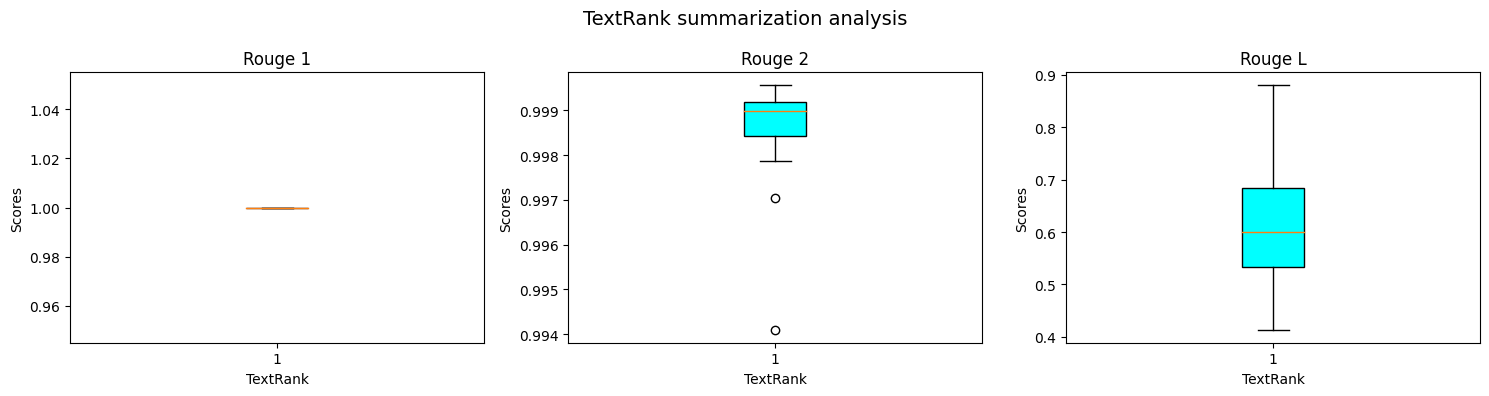

In [102]:
# scores
rank_rouge_1 = []
rank_rouge_2 = []
rank_rouge_L = []

# rouge score 
for i in tqdm(range(len(test_x_v2[:20])), total=len(test_x_v2[:20])):
    
    text = test_x_v2[i]
    resp_sum  = textranksummarize(text)
    scores = scorer.score(text, resp_sum)
    rank_rouge_1.append(scores["rouge1"].precision)
    rank_rouge_2.append(scores["rouge2"].precision)
    rank_rouge_L.append(scores["rougeL"].precision)

# sorting the scores
df_score_rank = pd.DataFrame()
df_score_rank["rouge1"] = rank_rouge_1
df_score_rank["rouge2"] = rank_rouge_2
df_score_rank["rougeL"] = rank_rouge_L

# plotting the analysis 
fig, axs = plt.subplots(1, 3, figsize=(15,4))

bp_ax_1 = axs[0].boxplot(df_score_rank["rouge1"],patch_artist=True)
bp_ax_2 = axs[1].boxplot(df_score_rank["rouge2"],patch_artist=True)
bp_ax_L  = axs[2].boxplot(df_score_rank["rougeL"],patch_artist=True)

axs[0].set_title('Rouge 1')
axs[1].set_title('Rouge 2')
axs[2].set_title('Rouge L')

axs[0].set_ylabel("Scores")
axs[1].set_ylabel("Scores")
axs[2].set_ylabel("Scores")

axs[0].set_xlabel("TextRank")
axs[1].set_xlabel("TextRank")
axs[2].set_xlabel("TextRank")

bp_ax_1["boxes"][0].set_facecolor("cyan")
bp_ax_2["boxes"][0].set_facecolor("cyan")
bp_ax_L["boxes"][0].set_facecolor("cyan")

plt.suptitle("TextRank summarization analysis", fontsize=14)
plt.tight_layout()
plt.show();

From the above figure we can see that for ROGUE 1 with unigram data we have obtained 100% precision however, ROGUE – L with longest sentence we can observe that score has decreased. We have better score here in ROGUE 1 and ROGUE 2 because, while extracting the sentences it is extracting the same sentence from the input and thus have higher precision and gives good ROGUE scores but the semantic meaning in the text will be missed. 

### <font color="red">Text summarization usig Fine tuning the T5 transformer</font>

We have fine-tuned the T5 transformer for summarization task and we observed that as we increase the epoch the loss was decreasing, and the generated summaries were better. But due to computation limitation we fine-tuned it for 10 epochs which took us 5 hours to train

In [12]:
# T5 transformer libraies 
from transformers import T5Tokenizer, T5ForConditionalGeneration, AutoTokenizer
from datasets import Dataset

In [19]:
# data format for T5

train_df = pd.DataFrame()
train_df["document"] = train_x_v1 
train_df["summary"] = train_y_v1

valid_df = pd.DataFrame()
valid_df["document"] = valid_x_v1 
valid_df["summary"] = valid_y_v1

# train and valid datasets 

train = Dataset.from_pandas(train_df)
valid = Dataset.from_pandas(valid_df)

tokenized_train = train.map(t5docbased, batched=True)
tokenized_valid = valid.map(t5docbased, batched=True)

Map:   0%|          | 0/9608 [00:00<?, ? examples/s]

Map:   0%|          | 0/1201 [00:00<?, ? examples/s]

In [17]:
# fucntion for T5 data format 
def t5docbased(data):
    
    doc_inp = ['summarize:' + art for art in data["document"]]
    t5_model_data = tokenizer(doc_inp, max_length=1024, truncation=True, padding='max_length')
    with tokenizer.as_target_tokenizer():
        t5_model_label = tokenizer(data["summary"], max_length=128, truncation=True)
    t5_model_data["labels"] = t5_model_label["input_ids"]
    return t5_model_data

In [ ]:
# Model for T5 with its pre trained weights 
model_checkpoint ='t5-small'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
pad_on_right = tokenizer.padding_side == "right"

# total input and output length
max_input_length = 1024
max_target_length = 128

In [24]:
from datasets import load_metric

In [29]:

# model
model_t5 = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

# batch size and data collator 
batch_size = 8
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_t5)

# training arguments 
train_args = Seq2SeqTrainingArguments(
    "t5-small-finetuned-newsarticles",
    evaluation_strategy = "epoch",
    learning_rate=2e-3,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.05,
    save_total_limit=3,
    num_train_epochs=4,
    predict_with_generate=True,
    fp16=True
)

# trainer 

trainer = Seq2SeqTrainer(
    model_t5,
    train_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_valid,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# load metrics 
metric = load_metric("rouge")

# trainer 
train_log_neww = trainer.train()

loading configuration file config.json from cache at /home/ubuntu/.cache/huggingface/hub/models--t5-small/snapshots/5bf53e1f76b1430d9302d735c613c5f5677e32a6/config.json
Model config T5Config {
  "_name_or_path": "t5-small",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 6,
  "num_heads": 8,
  "num_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size":

Saving model checkpoint to t5-small-finetuned-newsarticles/checkpoint-500
Configuration saved in t5-small-finetuned-newsarticles/checkpoint-500/config.json
Configuration saved in t5-small-finetuned-newsarticles/checkpoint-500/generation_config.json
Model weights saved in t5-small-finetuned-newsarticles/checkpoint-500/pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-newsarticles/checkpoint-500/tokenizer_config.json
Special tokens file saved in t5-small-finetuned-newsarticles/checkpoint-500/special_tokens_map.json
Deleting older checkpoint [t5-small-finetuned-newsarticles/checkpoint-2500] due to args.save_total_limit
Saving model checkpoint to t5-small-finetuned-newsarticles/checkpoint-1000
Configuration saved in t5-small-finetuned-newsarticles/checkpoint-1000/config.json
Configuration saved in t5-small-finetuned-newsarticles/checkpoint-1000/generation_config.json
Model weights saved in t5-small-finetuned-newsarticles/checkpoint-1000/pytorch_model.bin
tokenizer config 

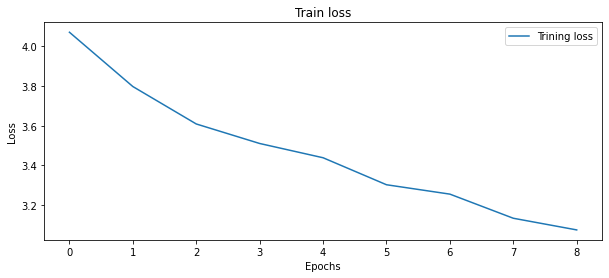

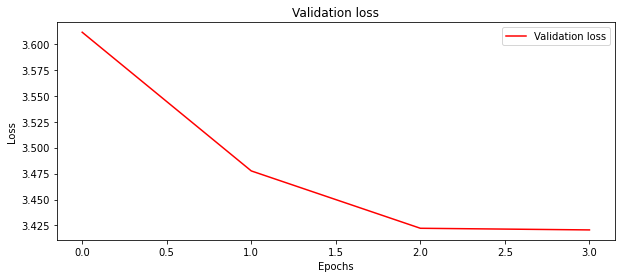

In [30]:
# Lossesare extracted from the state histroy 
train_loss = []
val_loss = []

for i in trainer.state.log_history:
    try: 
        if "eval_loss" in i.keys():
            val_loss.append(i["eval_loss"])
        else:
            train_loss.append(i["loss"])
    except:
        g =" "
plt.figure(figsize=(10, 4))
plt.plot(train_loss, label="Trining loss")
plt.title("Train loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show();

plt.figure(figsize=(10, 4))
plt.plot(val_loss, label="Validation loss", color="red")
plt.title("Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show();

we can see that training loss is decreased and we can also see that validation loss is decreasing too but we observed that our summary obtained using the model is not good because of the lower ROUGE scores

### <font color="red">Text summarization usig pegasus covid pretrained model</font>

In [ ]:
# pegasus model 
model_peg_cov_cp = "mayu0007/pegasus_large_covid"
tokenizer_peg_cov = AutoTokenizer.from_pretrained(model_peg_cov_cp)
model_peg_cov = PegasusForConditionalGeneration.from_pretrained(model_peg_cov_cp).to("cuda")

In [26]:
# pegasus output example 1
text = df_summary.iloc[90]["document"]
batch_peg_cov = tokenizer_peg_cov(text, truncation=True, padding='longest', return_tensors="pt").to("cuda")
translated_peg_cov = model_peg_cov.generate(**batch_peg_cov)
tgt_text_peg_cov = tokenizer_peg_cov.batch_decode(translated_peg_cov, skip_special_tokens=True)[0]
tgt_text_peg_cov

'Systemic inflammation is the hallmark of coronavirus disease 2019 (COVID-19) caused by the severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2). The result is an exaggerated inflammatory response of the innate and adaptive immune system known as cytokine release syndrome (CRS). When CRS occurs, several immunological alterations are taking place such as the production and secretion of a plethora of pro-inflammatory cytokines like interleukin (IL)-1b, IL-6, IL-18, and tumor necrosis factor alpha (TNFa) [1]. COVID-19 is a matter of concern and a huge challenge for the rheumatologists dealing with patients suffering from autoimmune rheumatic diseases (ARD), because several antirheumatic drugs are used at different stages of COVID-19 [2] [3] [4] ; these drugs include colchicine and cytokine inhibitors against IL-1b, IL-6, and TNFa [3] [4] [5]. However, none of the aforementioned treatment regimens have been proven to be completely efficacious. Colchicine is an old drug which has be

**<font color="red">Analysis</font>**

From the above analysis, we can see that our summarisation using the pegasus method and we were able good summary and the summary has sematic meaning.

In [28]:
# pegasus output example 2
text = df_summary.iloc[190]["document"]
batch_peg_cov = tokenizer_peg_cov(text, truncation=True, padding='longest', return_tensors="pt").to("cuda")
translated_peg_cov = model_peg_cov.generate(**batch_peg_cov)
tgt_text_peg_cov = tokenizer_peg_cov.batch_decode(translated_peg_cov, skip_special_tokens=True)[0]
tgt_text_peg_cov

"Specific scale; (2) identifying the precise context across multiple spatial and temporal scales to understand how tangible biosignatures may or may not be preserved; (3) increasing capability to mine big data sets to reveal relationships, for example, how Earth's mineral diversity may have evolved in conjunction with life; (4) leveraging cyberinfrastructure for data management of biosignature types, characteristics, and classifications; and (5) using three-dimensional to n-D representations of biotic and abiotic models overlain on multiple overlapping spatial and temporal relationships to provide new insights. Astrobiology is fundamentally referenced to Earth as the only known and accessible benchmark for comparison (a sample size of n = 1 problem), from the microscopic level up to the scale of our planet and its atmosphere, where life has perturbed planetary environments over long timescales (e.g., Judson, 2017). It has often been assumed that substances or objects in Earth's near-su

**<font color="red">Analysis</font>**

From the above analysis, we can see that our summarisation using the pegasus method and we were able good summary and the summary has sematic meaning.

In [30]:
# pegasus output example 3
text = df_summary.iloc[170]["document"]
batch_peg_cov = tokenizer_peg_cov(text, truncation=True, padding='longest', return_tensors="pt").to("cuda")
translated_peg_cov = model_peg_cov.generate(**batch_peg_cov)
tgt_text_peg_cov = tokenizer_peg_cov.batch_decode(translated_peg_cov, skip_special_tokens=True)[0]
tgt_text_peg_cov

'Polysplenia syndrome represents a type of left atrial isomerism characterized by multiple small spleens, often associated with cardiac malformations and with defects in the usual left-right distribution of the thoracic and abdominal organs. This is part of the spectrum of heterotaxy or situs ambiguus syndromes. In most cases, the cardiac malformations are mild and not life-threatening, in contrast to right atrial isomerism characterized by asplenia and frequent severe cardiac malformations. Atrioventricular canal and septal defects, inferior vena cava abnormalities, bilateral bilobation or trilobation of the lungs, midline liver, right-sided stomach, and a degree of intestinal malrotation are the most common described findings associated with polysplenia. In most cases, the cardiac malformations are mild and not life-threatening, in contrast to right atrial isomerism characterized by asplenia and frequent severe cardiac malformations. In most cases, the cardiac malformations are mild 

**<font color="red">Analysis</font>**

From the above analysis, we can see that our summarisation using the pegasus method and we were able good summary and the summary has sematic meaning.

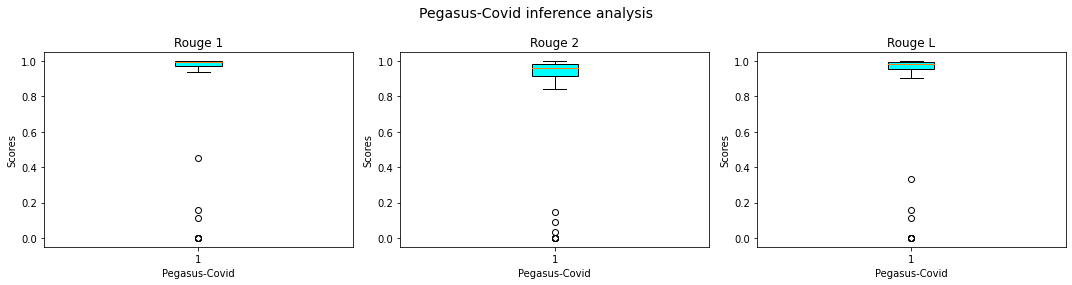

In [35]:
# pegasus scores
pegcov_rouge_1 = []
pegcov_rouge_2 = []
pegcov_rouge_L = []

# pegasus model
for n in tqdm(range(len(test_x_v1[:50])), total=len(test_x_v1[:50])):
    
    testX = test_x_v1[n]
    batch_peg_cov = tokenizer_peg_cov(testX, truncation=True, padding='longest', return_tensors="pt").to("cuda")
    translated_peg_cov = model_peg_cov.generate(**batch_peg_cov)
    tgt_text_peg_cov = tokenizer_peg_cov.batch_decode(translated_peg_cov, skip_special_tokens=True)[0]
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(testX, tgt_text_peg_cov)
    pegcov_rouge_1.append(scores["rouge1"].precision)
    pegcov_rouge_2.append(scores["rouge2"].precision)
    pegcov_rouge_L.append(scores["rougeL"].precision)

# sort the scores
df_score_pegcov = pd.DataFrame()
df_score_pegcov["rouge1"] = pegcov_rouge_1
df_score_pegcov["rouge2"] = pegcov_rouge_2
df_score_pegcov["rougeL"] = pegcov_rouge_L

# plotting
fig, axs = plt.subplots(1, 3, figsize=(15,4))

bp_ax_1 = axs[0].boxplot(df_score_pegcov["rouge1"],patch_artist=True)
bp_ax_2 = axs[1].boxplot(df_score_pegcov["rouge2"],patch_artist=True)
bp_ax_L  = axs[2].boxplot(df_score_pegcov["rougeL"],patch_artist=True)

axs[0].set_title('Rouge 1')
axs[1].set_title('Rouge 2')
axs[2].set_title('Rouge L')

axs[0].set_ylabel("Scores")
axs[1].set_ylabel("Scores")
axs[2].set_ylabel("Scores")

axs[0].set_xlabel("Pegasus-Covid")
axs[1].set_xlabel("Pegasus-Covid")
axs[2].set_xlabel("Pegasus-Covid")

bp_ax_1["boxes"][0].set_facecolor("cyan")
bp_ax_2["boxes"][0].set_facecolor("cyan")
bp_ax_L["boxes"][0].set_facecolor("cyan")

plt.suptitle("Pegasus-Covid inference analysis", fontsize=14)
plt.tight_layout()
plt.show();

**<font color="red">Analysis</font>**

From the above analysis we can see that, rouge scores for the pegasus model is around 0.9 but the time taken to complete the summarisation is bit longer.

### <font color="red">Text summarization usig SciBert covid pretrained model</font>

In [ ]:
# model scibert
model_scibert_cp = 'allenai/scibert_scivocab_uncased'
summary_ratios = 0.1
scibert_config = AutoConfig.from_pretrained(model_scibert_cp)
scibert_config.output_hidden_states=True
scibert_tokenizer = AutoTokenizer.from_pretrained(model_scibert_cp)
scibert_model = AutoModel.from_pretrained(model_scibert_cp, config=scibert_config)
model_scibert = Summarizer(custom_model=scibert_model, custom_tokenizer=scibert_tokenizer)

In [43]:
# example 1
text = df_summary.iloc[569]["document"]
resp = model_scibert(text, ratio=0.01) 
resp

'Skin is the tissue dedicated to the protection of the inner part of the body. As a pure compound, CinAc occurs as white crystalline scales with a melting point around 133 °C, it is slightly soluble in ethanol and other organic solvents, it is soluble in oils, but it is almost insoluble in water (logP = 2.13, water solubility 0.57 mg/mL).Thanks to their photo-protective and antimicrobial action, CinAc compounds have found vast utilization in the food industry as nutraceutical supplements, food flavoring (in candies, chewing gums, mouthwash, and toothpaste), and packaging additives for food preservation [31] . Moreover, the extract obtained from the plant Tragopogon graminifolius, rich in polyphenolic compounds, including CA, was seen to stimulate the wound closure successfully when topically administrated on second-degree burn wounds in a rat model [75] .As previously introduced, several MMPs isoforms, such as MMP-2 and MMP-9, are known to be overexpressed in UVB-irradiated skin tissue

**<font color="red">Analysis</font>**

From the above analysis, we can see that our summarisation using the scibert method and we were able good summary and the summary has sematic meaning.

In [46]:
# example 2
text = df_summary.iloc[7899]["document"]
resp = model_scibert(text, ratio=0.05) 
resp

"The macroeconomic impact of events originating in or propagating through oil markets is a major research topic. We develop several other measures of oil earnings uncertainty. One possible concern of using oil prices to measure uncertainty is that the oil price itself responds to changes in other macroeconomic aggregates, so that the direction of causality between oil prices and macroeconomic variables is unclearas underlined by Kilian (2009). Given that we develop some of our oil uncertainty measures based on forecast errors, our work is perhaps most closely related to Jo (2014). Section 6 concludes with a discussion of potential future work. Time is discrete and divided into days which are collected into months. Forecasts are not included unless they are confirmed within 6 months. Given that the literature suggests that aggregate uncertainty is related to recessions, this suggests that oil earnings uncertainty is different from overall uncertainty, and thus a factor of uncertainty th

**<font color="red">Analysis</font>**

From the above analysis, we can see that our summarisation using the scibert method and we were able good summary and the summary has sematic meaning.

In [48]:
# example 3
text = df_summary.iloc[4689]["document"]
resp = model_scibert(text, ratio=0.1) 
resp

'protective equipment (PPE) are contributing to its rapid diffusion across the world. 9 In this scenario and under the principles of "social distancing" and of "selfisolation," the clinical activities of many departments were drastically reduced, elective surgical procedures were postponed and a large proportion of outpatient consultations were canceled or are being moved to telemedicine. We retrospectively reviewed the official statistical data of all patients admitted to the ED of Careggi University Hospital, Florence, Italy from January 1, 2020, to May 17, 2020. It is a third-level referral hospital and hub trauma center for the central Italy where logistics, clinical, and surgical activity were profoundly reorganized and a distinct pathway of care for COVID-19 confirmed cases was established since the beginning of the pandemic: the interested reader is referred to another publication for a detailed description of these changes. By reviewing clinical records of the nine patients in 

**<font color="red">Analysis</font>**

From the above analysis, we can see that our summarisation using the scibert method and we were able good summary and the summary has sematic meaning.

100%|██████████| 50/50 [02:08<00:00,  2.56s/it]


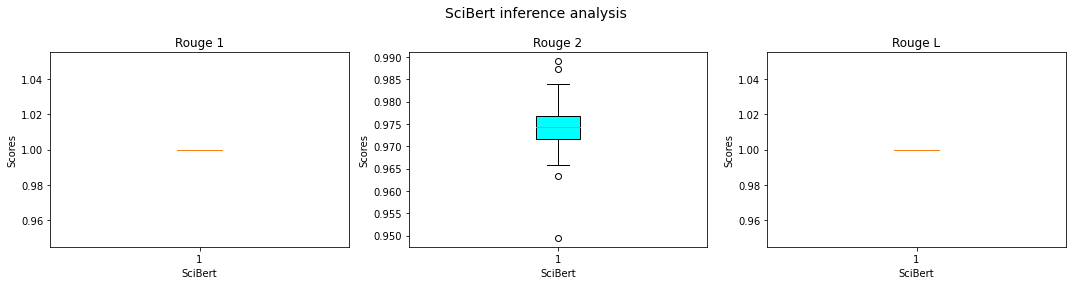

In [54]:
# testing the scibert model on ROGUE score 

# scores
scibert_rouge_1 = []
scibert_rouge_2 = []
scibert_rouge_L = []

# scibert model
for n in tqdm(range(len(test_x_v1[:50])), total=len(test_x_v1[:50])):
    
    testX = df_summary.iloc[n]["document"]
    resp = model_scibert(testX, ratio=0.2) 
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(testX, resp)
    scibert_rouge_1.append(scores["rouge1"].precision)
    scibert_rouge_2.append(scores["rouge2"].precision)
    scibert_rouge_L.append(scores["rougeL"].precision)
    
# sort scores
df_score_scibert = pd.DataFrame()
df_score_scibert["rouge1"] = scibert_rouge_1
df_score_scibert["rouge2"] = scibert_rouge_2
df_score_scibert["rougeL"] = scibert_rouge_L

fig, axs = plt.subplots(1, 3, figsize=(15,4))

bp_ax_1 = axs[0].boxplot(df_score_scibert["rouge1"],patch_artist=True)
bp_ax_2 = axs[1].boxplot(df_score_scibert["rouge2"],patch_artist=True)
bp_ax_L  = axs[2].boxplot(df_score_scibert["rougeL"],patch_artist=True)

axs[0].set_title('Rouge 1')
axs[1].set_title('Rouge 2')
axs[2].set_title('Rouge L')

axs[0].set_ylabel("Scores")
axs[1].set_ylabel("Scores")
axs[2].set_ylabel("Scores")

axs[0].set_xlabel("SciBert")
axs[1].set_xlabel("SciBert")
axs[2].set_xlabel("SciBert")

bp_ax_1["boxes"][0].set_facecolor("cyan")
bp_ax_2["boxes"][0].set_facecolor("cyan")
bp_ax_L["boxes"][0].set_facecolor("cyan")

plt.suptitle("SciBert inference analysis", fontsize=14)
plt.tight_layout()
plt.show();

**<font color="red">Analysis</font>**

From the above analysis, we can see that our summarisation using the scibert method has good summary and our rouge scores near 0.98 but compairng the Pegasus model the SciBert is faster compared to Pegasus.
We trained and evaluated the above models using the ROGUE score and while comparing the model, we observed that SciBert and Pegasus-large model achieved ROGUE score close to 0.98 in ROGUE 1, ROGUE 2 and ROGUE L but, during the article retrieval the latency of the article retrieval matters and the SciBert is much faster compared to Pegasus thus we selected our best model as SciBert. 

## <font color="purple">INFORMATION RETRIEVAL</font>

#### <font color="RED">READ AND PROCESS DATASET</font>

During the dataset inspection, we found that pdf_json and pmc_json files are very same. In metadatset provided in the dataset fodler, we found that each file in the folders pdf_json and pmc_json has same articles in each other. It was provided t use either of them. 

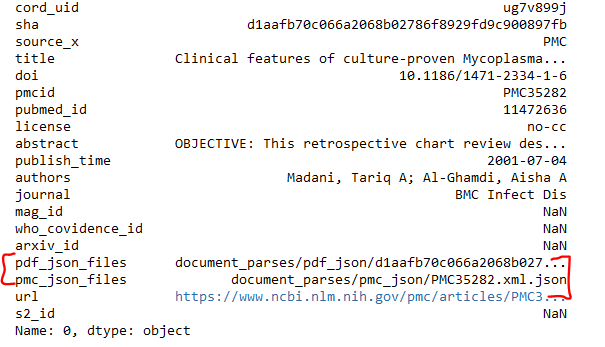

From the above figure we can see that, column name painted in red color are the pdf_json and pmc_json files in the dataset and their values are path for each of these articles. Therefore they are same. 

Therefore, in our analysis at the first we thought these two files are different so we used 6000 articles from each of these folder that is, pdf_json and pmc_json totaling 12000 articles. After thorough inspection we changed the datasets.

We dropped the plan of using the pdf_json and pmc_json togetehr not only because they are same dataset but also because would be using the same words in theinverted index and total keywords extarcted will be small and while at etsting we would not be able to answer queries for complex questions. Having same set of copied data will also result in small dataset and this is will be easier to extarct the articles, but using the large dataset and extarcting the good articles will increase the trust in the system output. 

Now, we have used the dataset from pdf_json files only. While extarcting the files we made sure that these files are also present in the pmc_json because, later at the development stage we want to use the URL of these files to be used at the article extraction process. 

In this analysis, we have used 12010 articles where last 10 articles are the test dataset. During the article text extraction we extracted the title, abstract and bodytext. We extracted the whole articles text because using these full text can extract the better results. 

**Analysis on various approach on dataset extraction**

1. In the first analysis, we used only title of the articles to extract the articles and we found that articles extraction was faster but similarity score for query and article context was very small. Therefore we shifted into another strategy.

2. In this data strategy, we used title and abstarct dataset. In this method were able to extract the articles better comapred to our first approach. But, we knew that using the full text we have more advantage compared to using only title and abstract. Therefore we tested on another strategy.

3. In this our best dataset format, we used whole dataset that is, title, abstract and body text. Using this method, we were able to extract better artilces with respect to user queries. But we had an issue of large dataset and processing time was slower compared to our second approach. However, we solved our slow processing into faster using below method.

**Challeneges in the reading dataset and solutions**

During the dataset extarction we found that dataset with title and abstract were smaller compared to title, abstract and bodytext. Thus full text was slower compared to above any other approach during text procesisng and data reading. 

To solve this issues, we used dataset format method. We used **parquet by apache arrow** dataset format instead of csv file format. Using the parquet file format we deastically reduced our file size and we increased our text processing and text reading. 

Our dataset has total size of 590MB and loading these large data in pandas take long time and it consumes lot of memory. Using the parquet format we reduced dataset size to 160MB from 590MB. This in turn helpe dus in faster reading processing the texts. 

Here is our dataset snippet:


**Steps to solve**

* Step 1: Extract the dataset 
* Step 2: Store the data in parquet format 
* Step 3: Save the parquet files 
* Step 4: Text processing 

Since, we have larget dataset in the pdf_json file, we extract 20000 articles randomly without repeatations, later, we extract only 12010 articles which is present in both pdf_json and pmc_json files. 

#### Extracting and loading the dataset 

In [2]:
def get_json_data(pathdir):
    
    '''Here we extract paperid, title, abstract and full body text from the 
    given article'''
    
    switch = False
    paperid, text, titles = [],  [], []
    file = open(pathdir, "rb")
    json_data = json.load(file)
    
    # extract paper id
    paperid.append(json_data["paper_id"])
    
    # extract title
    title = json_data["metadata"]["title"]
    titles.append(title)
    
    # extrcat abstract, we skip abstract if there is no abstract field
    abs_ = ""
    try:
        for field in json_data["abstract"]:
            abs_+= field["text"]
    except:
        abs_ = ""
        
    # extract body text
    body_ = ""
    try:
        for field in json_data["body_text"]:
            body_+= field["text"]
    except:
        body_ = ""
        
    # combine all text as one article
    full_text = title+" "+abs_+" "+body_
    text.append(full_text)
    
    # if the article has no words, we do not use those
    if full_text=="":
        switch = True
        
    return paperid, text, titles, switch 

**Here we combined the data from our team members, and we extracted the unique data, we put all our JSON files together 
and we used the random sample to collect 20000 files**

In [4]:
# path files for main data and test data 

pdf_path = "D:/team_project_data/pdf_json_files/"

pdf_files = sorted(os.listdir(pdf_path))

In [3]:
import random

In [7]:
# selecting the random 20K files without repeatations from our team data 
selected_pdf_files = random.sample(pdf_files, 20000)

In [2]:
# Metadata has details of our dataset for both and pdf and pmc and details regarding the 
# referene regarding where the dataset is taken from 

metadata_df = pd.read_csv("D:/covid19_data/archive/metadata.csv")

C:\Users\perei\AppData\Local\Temp\ipykernel_17232\3002632601.py:4: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata_df = pd.read_csv("D:/covid19_data/archive/metadata.csv")


**Since we are using Melroy's recommendation method we will use the same amount of data the Melroy used**

In [21]:
# Selected 12010 articles path 
selected_pdf_files_12k = []

total = 0

for file in tqdm(selected_pdf_files, total=20000):
    
    # path of the pdf json files
    pathpdf = "team_project_data/pdf_json_files/"+file
    
    # total requirements (12000 for main data and 10 for test data)
    if total>=12010:
        break 
    
    # If the pdf file is present in metadata then it will listout the details
    if len(metadata_df[metadata_df["pdf_json_files"]==pathpdf])>=1:
        selected_pdf_files_12k.append(file)
        total+=1        

 69%|████████████████████████████████████████████████████▍                       | 13784/20000 [06:35<02:58, 34.83it/s]


In [6]:
def extract_json_df(paper, dict_path, dict_file):
    
    '''This function will extract the deatils of the articles and returns
    the dataframe of the 12010 articles'''
    
    paperid_ls, text_ls, title_ls = [], [], []
    counter_sucess = 0
    path_dir = dict_path[paper]
    path_files = dict_files[paper]
    total_file = len(path_files)
    for i in tqdm(range(total_file)):
        path_ = path_dir+path_files[i]
        paperid, text, titles, switch = get_json_data(path_)
        # If the extracted article has no words we do not use those articles
        # switch = False if there is articles with words
        if switch==False:
            paperid_ls.append(paperid[0])
            text_ls.append(text[0]) 
            title_ls.append(titles[0])
            counter_sucess+=1 
            if counter_sucess >= total:
                break 
    data_df = pd.DataFrame()
    data_df["PaperId"] = paperid_ls 
    data_df["Title"] = title_ls
    data_df["Text"] = text_ls
    return data_df

In [24]:
# pdf files and its path

dict_path = {"pdf": pdf_path}

dict_files = {"pdf": selected_pdf_files_12k}

In [26]:
# Extracting the datasets 

df_pdf = extract_json_df("pdf", dict_path, dict_files)

100%|███████████████████████████████████████████████████████████████████████████▉| 12009/12010 [11:34<00:00, 17.28it/s]


**Once the dataset is extarcted, we need to make sure that these 12010 articles are unique and there is no copy or duplicates. Therefore, we use testing fucntion where we check if the dataset has duplicates**

In [7]:
def testuniques(data):
    '''This function checks if the rerieved articles are unique
    for uniques articles, length of the articles should be same as uniques and maximum
    frequency of each articles ID is only once'''
    cls, freq = np.unique(data, return_counts=True)
    if len(cls)==len(data) and max(freq)==1:
        print("Dataset has unique articles")
    else:
        print("Dataset is not unique")

In [33]:
testuniques(list(df_pdf["PaperId"]))

Dataset has unique articles


**From the above analysis, we can see that our articles are unique and they have no duplicates.**

In [41]:
# size of the whole data is 584mb, we will use parquet to read and write teh file
# convering bytes to GB
sys.getsizeof(df_pdf)*1e-9

0.584764909

**From the above file size we can see that whole dataset is 584MB which is large to process and read using pandas. Therefore, we use parquet format to compress and read data faster**

In [43]:
# read dataframe as parquet table data 
data_df_tb = pa.Table.from_pandas(df_pdf)

# save the parquet data file 
pq.write_table(data_df_tb, 'datadf.parquet')

**Load the dataframe using parquet file format**

In [2]:
# original data (RUN)
table_1 = pq.read_table("datadf.parquet")

# converting parquet table to dataframe 
data_df = table_1.to_pandas()

In [75]:
# size of the whole data is 384mb, and the compressed file size is 165MB
# convering bytes to GB

sys.getsizeof(table_1)*1e-9

0.32920972400000004

**<font color="purple">Text pre-procesisng</font>**

**In preprocessing, we are using two types of datasets:**

* **1. Full cleaned dataset -> version 1**
* **2. Partially cleaned dataset -> version 2**

We are using two version of dataset because, in version 1 dataset, we later use this dataset for TFIDF keyword extraction whereas, verison 2 dataset is used NER keywords. Two datasets playsimportant role in manintaining the importance of words. 

For example, "covid" is not recognised in our NER model, however, "covid19" can be recognised. Therefore numbers has relevance and importance for NER entity extraction. Therefore, we used two sets of datasets.

**Text procesing steps:**

In our text processing pipeline, for first version dataset, we used following methods:
1. lowercase
2. remove punctuations 
3. remove number
4. remove non alpha numeric charcters
5. remove stopwords 

In our text processing pipeline, for second version dataset, we used following methods:
1. lowercase
2. remove punctuations


**Challenges in text processing and solution**

While text procesisng we found that, text processing was very slow when we used stopwords with list comphression and for loop method. Howevever, using regular expression and pattern matching we were able to process texts very faster. 

In old approach it was taking 50-80minutes to text processing because of slower stopword removal, however, using the regualr expression it took the whole process in 10-20 minutex maximum. 

**<font color="red">NOTE: FOR TEXT PROCESSING WE HAVE USED SAME PROCESSING FUNCTION FROM OUR SECOND
ASSIGNMENT</font>**

In [6]:
import seaborn as sns 

100%|███████████████████████████████████████████████████████████████████| 1056660/1056660 [00:00<00:00, 2021812.85it/s]


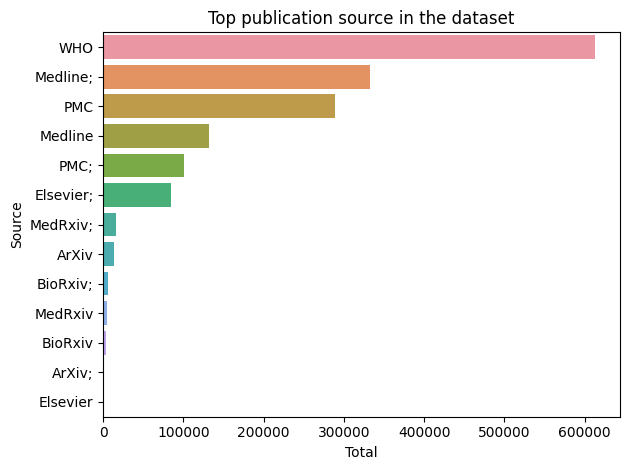

In [9]:
most_source = []
for s in tqdm(metadata_df["source_x"]):
    most_source+=s.split()
    
most_cls, most_frq = np.unique(most_source, return_counts=True)

most_src_Df = pd.DataFrame()
most_src_Df["Source"] = most_cls
most_src_Df["Total"] = most_frq
most_src_Df = most_src_Df.sort_values(by="Total", ascending=False)

sns.barplot(x="Total", y="Source", data=most_src_Df)
plt.title("Top publication source in the dataset")
plt.ylabel("Source")
plt.xlabel("Total")
plt.tight_layout()
plt.show()

**<font color="red">analysis</font>**

From the above analysis, we can see that most publication source in the dataset was from the WHO, followed by Medicine, PMC and Elsevier. Therefore these are resources were most of the clinical publications are published.

In [3]:
# processing text

# Functions for preprocessing texts

# Lower case
def lowercasefn(text):
    '''Convert text into lower case'''
    return text.lower() 

# Stopword - english
def stopwordfn(text):
    '''Remove stopwords from the texts'''
    en_stopwords = stopwords.words('english')
    pattern = re.compile(r'\b(' + r'|'.join(en_stopwords) + r')\b\s*')
    return pattern.sub('', text)
    

# remove punctuations
def removepunctuations(text):
    '''Remove all punctuations of following
    '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~' '''
    return text.translate(str.maketrans('','',string.punctuation))

# remove non-alpha numeric
def removenonalphanumeric(text):
    '''Remove and keep only alphanumeric text
    alphanumeric texts are texts only with A_Z or a_z or digits
    0_9'''
    tword = text.split()
    sew = []
    for tfw in tword: 
        wds = []
        for w in tfw:
            if w.isalnum():
                wds.append(w)
        sew.append("".join(wds))
    
    return " ".join(sew)

# stemming
def stemming(text):
    
    '''Stemming the words using Porter stemmer'''
    
    port_stem = PorterStemmer()
    tword = text.split()
    
    stem_word = []
    for w in tword:
        stem_word.append(port_stem.stem(w))
        
    return " ".join(stem_word)

# lemmatization
def lemmatize(text):
    
    '''Lemmatization of text using wordnet lemmatizer'''
    
    lemma_ = WordNetLemmatizer()
    tword = text.split() 
    
    lemm_word = []
    for w in tword: 
        lemm_word.append(lemma_.lemmatize(w))
        
    return " ".join(lemm_word)

# word tokenization
def tokenword(text):
    """Tokenize the words from text"""
    return word_tokenize(text)

# sentence tokenization
def tokensentence(text):
    """Tokenize the sentences"""
    return sent_tokenize(text)

# remove number from text
def removenumber(text):
    '''Remove number from words'''
    pattern = r'[0-9]' 
    return re.sub(pattern, '', text)   

# remove url from text
def removeurls(text):
    '''Remove URL from text'''
    pattern = r"http\S+"
    text = re.sub(pattern, "", text)
    pattern = r"www.\S+"
    return re.sub(pattern, "", text)

# Function for parsing actions based on user requirement 
def getactnfn(actions):
    
    '''This function returns all the actions fucntions as per 
    user requirements'''
    
    # action list
    actnlist = []
    
    # atleast one action should present 
    if len(actions)>0:
    
        for a in actions:
            
            if a=="stopwords":
                actnlist.append(stopwordfn)
                
            elif a=="punctuations":
                actnlist.append(removepunctuations)
                
            elif a=="removenonalnum":
                actnlist.append(removenonalphanumeric)
                
            elif a=="lowercase":
                actnlist.append(lowercasefn)
                
            elif a=="stemming":
                actnlist.append(stemming)
                
            elif a=="lemmatize":
                actnlist.append(lemmatize)
                
            elif a=="removenumber":
                actnlist.append(removenumber)
                
            elif a=="removeurls":
                actnlist.append(removeurls)
                
    return actnlist

# Run functions processes all actions required by the user
def run(text, actions):
    '''
    This functions processes all the actions using for loop
    '''
    getactnfnlist = getactnfn(actions)
    for act in getactnfnlist:
        text = act(text)
    return text

In [5]:
# cleaned text version 1

cleaned_text_v1 = []
text_df_v1 = list(data_df["Text"])
for ix in tqdm(range(len(text_df_v1)), total=len(text_df_v1)):
    
    text_ = text_df_v1[ix]
    cleaned_text_v1.append(run(text_, ["lowercase","punctuations", "removenumber", "removeurls","removenonalnum",
                                    "stopwords"]))

100%|███████████████████████████████████████████████████████████████████████████| 12010/12010 [01:54<00:00, 105.21it/s]


In [6]:
# cleaned text version 2

cleaned_text_v2 = []
text_df_v2 = list(data_df["Text"])
for ix in tqdm(range(len(text_df_v2)), total=len(text_df_v2)):
    
    text_ = text_df_v2[ix]
    cleaned_text_v2.append(run(text_, ["lowercase","punctuations"]))

100%|███████████████████████████████████████████████████████████████████████████| 12010/12010 [00:18<00:00, 656.52it/s]


In [9]:
# Dataframe for verison 1 data 
data_df_v1 = data_df.copy()
data_df_v1["cleaned_text"] = cleaned_text_v1

In [10]:
# Dataframe for verison 2 data 
data_df_v2 = data_df.copy()
data_df_v2["cleaned_text"] = cleaned_text_v2

In [11]:
# Displaying the verson 1 data
data_df_v1.tail(5)

PaperId  \
12005  80e3b987da656dbd065c081da61c94f2b54eb619   
12006  7611f620358c645a8800084f07217a9ad3f6de7f   
12007  dc9dd2cb404931202705a59387df2b7305ece728   
12008  3150f31687f2775f3515ee8def82557e05b06f06   
12009  5c8058ce4241d59c7febb7925f41880643827980   

                                                   Title  \
12005  Estimation of World Seroprevalence of SARS-CoV...   
12006  Case report Hemothorax after oocyte retrieval ...   
12007  High resolution copy number inference in cance...   
12008  Nursing Surge Capacity Strategies for Manageme...   
12009  Access to Epidemic Information and Life Satisf...   

                                                    Text  \
12005  Estimation of World Seroprevalence of SARS-CoV...   
12006  Case report Hemothorax after oocyte retrieval ...   
12007  High resolution copy number inference in cance...   
12008  Nursing Surge Capacity Strategies for Manageme...   
12009  Access to Epidemic Information and Life Satisf...   

                                            cleaned_text  
12005  estimation world seroprevalence sarscov antibo...  
12006  case report hemothorax oocyte retrieval patien...  
12007  high resolution copy number inference cancer u...  
12008  nursing surge capacity strategies management c...  
12009  access epidemic information life satisfaction ...

In [12]:
# Displaying the verson 2 data
data_df_v2.tail(5)

PaperId  \
12005  80e3b987da656dbd065c081da61c94f2b54eb619   
12006  7611f620358c645a8800084f07217a9ad3f6de7f   
12007  dc9dd2cb404931202705a59387df2b7305ece728   
12008  3150f31687f2775f3515ee8def82557e05b06f06   
12009  5c8058ce4241d59c7febb7925f41880643827980   

                                                   Title  \
12005  Estimation of World Seroprevalence of SARS-CoV...   
12006  Case report Hemothorax after oocyte retrieval ...   
12007  High resolution copy number inference in cance...   
12008  Nursing Surge Capacity Strategies for Manageme...   
12009  Access to Epidemic Information and Life Satisf...   

                                                    Text  \
12005  Estimation of World Seroprevalence of SARS-CoV...   
12006  Case report Hemothorax after oocyte retrieval ...   
12007  High resolution copy number inference in cance...   
12008  Nursing Surge Capacity Strategies for Manageme...   
12009  Access to Epidemic Information and Life Satisf...   

                                            cleaned_text  
12005  estimation of world seroprevalence of sarscov2...  
12006  case report hemothorax after oocyte retrieval ...  
12007  high resolution copy number inference in cance...  
12008  nursing surge capacity strategies for manageme...  
12009  access to epidemic information and life satisf...

* **<font color="red">Dataset distributions in version 1 and version 2 dataset</font>**

100%|██████████████████████████████████████████████████████████████████████████| 12010/12010 [00:02<00:00, 4443.60it/s]


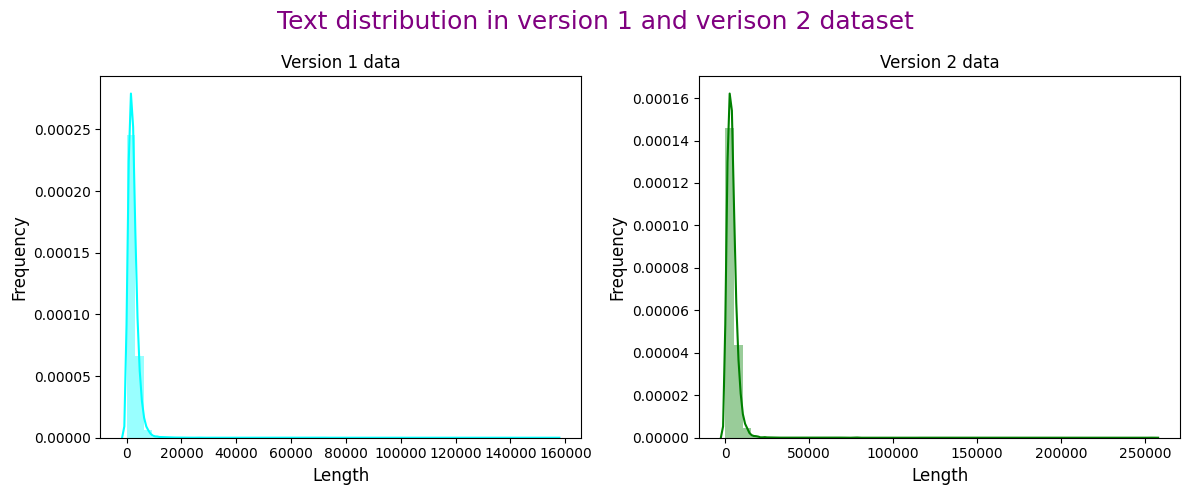

In [17]:
# cleaned dataset version 1 
clean_len_v1 = []
for i in tqdm(cleaned_text_v1):
    clean_len_v1.append(len(i.split()))
    
# cleaned dataset version 2
clean_len_v2 = []
for i in tqdm(cleaned_text_v2):
    clean_len_v2.append(len(i.split()))
    
# Distribution plot 
fig, axes = plt.subplots(1,2, figsize=(12, 5))
sns.distplot(clean_len_v1, ax=axes[0], color="cyan");
sns.distplot(clean_len_v2, ax=axes[1], color="green");
fig.suptitle("Text distribution in version 1 and verison 2 dataset", size=18, color="purple")
axes[0].set_title("Version 1 data", size=12)
axes[0].set_xlabel("Length",size=12)
axes[0].set_ylabel("Frequency",size=12)
axes[1].set_title("Version 2 data",size=12)
axes[1].set_xlabel("Length", size=12)
axes[1].set_ylabel("Frequency",size=12)
fig.tight_layout()
plt.show()

**<font color="red">analysis</font>**

From the above analysis, we cans see that maximum words present in the text articles in version 1 dataset is about 160000 whereas, in version 2 dataset the maximum words present are 250000. We can see that version 2 dataset has more words compared to version 1. This is because verison 1 data uses stopwords whereas version2  dataset does not. 

However, most of the words in both the dataset lies in the range of 1000 to 10000 words. 

* **<font color="red">POSTAG analysis</font>**

In this analysis, we have used the TextBlob to extact the POS tags from the version 2 datasets

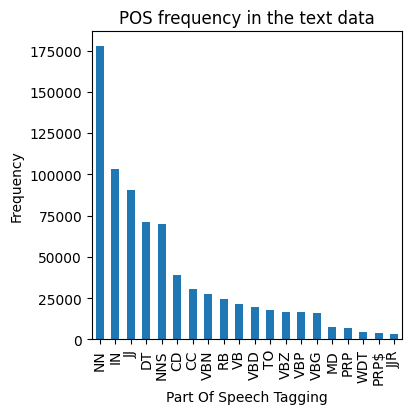

In [18]:
from textblob import TextBlob, Word, Blobber

blobs = TextBlob(str(cleaned_text_v2[:200]))
posdata = pd.DataFrame(blobs.tags, columns = ['word', 'postag'])
posdata = posdata.postag.value_counts()[:20]
posdata.plot(kind='bar', xlabel = "Part Of Speech Tagging", ylabel = "Frequency",
           title = "POS frequency in the text data", figsize=(4,4));

**<font color="red">analysis</font>**

From the above analysis on 200 text data, we can see that most of the words are Noun followed by Adjectives. It is obvious that most of the words are in clinical terms and hence there are many noun in the text data.

**<font color="red">Conclusion</font>**

* We discovered that pdf_json and pmc_json have same data, so we used only pdf_json files. 

* We extracted 12010 articles from the pdf_json data for our developement of question answering system.

* While extracting and reading dataset, due to the large in size of the dataset file, we used parquet data format to compress the dataset size and read faster. 

* While text processing we solved the issue of slow text processing stopwords by replacing the regular expression pattern matching. 

## <font color="purple">2. ARTICLE INDEXING</font>

In this section, we are using the article indexing. Article indexing is important step in any search engine because using indexing we can retrieve the articles faster than looking into each articles for finding the query words. In this analysis, we are using inverted index approach to build the article indexing. 

**Inverted index:**

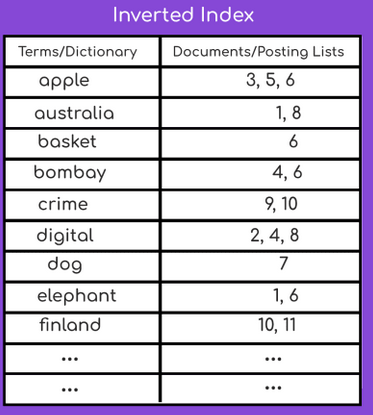

(Reference: https://dev.to/im_bhatman/introduction-to-inverted-indexes-l04)

In the inverted index, we keep all the unique words from all the articles in one coloumns and we use another coloumn where list out all the documents consisting these words. 

We tested various approach such as,

1. using inverted index using only TFIDF keywords
2. using keywords from the articles without considering the stopwords
3. using TFIDF and NER from medical terms 

**Analysis on testing approaches:**

**1. using inverted index using only TFIDF keywords**

Using the TFIDF we obtained the keywords but we know that TFIDF gives lower score for words that appear frequently in all documents. Since, we are using articles related to "covid19" and most of the words are similar and repeated and thus it gives lower score for words like "incubation" and we know that "incubation" is an important word for analysing the incubation period of an virus and these could be because of "incubation" has appeared frequently in most of the articles. Therefore obtianed lower score using this approach. 

**2. using keywords from the articles without considering the stopwords**

We considered using all unique words from the whole documents. It is a good approahc because we have all the words from articles. But we found that this method is very time consuming and response time for retrieving the articles are slower. 

**3. using TFIDF and NER from medical terms**

This approach is our best one. Earlier, we found that using TFIDF we found keywords but it was not extracting keywords from medical terms that appear frequently and since, our task is to retrieve the medical articles we need those keywords from medical. Therefore we used Spacy's medical model for NER method and it was able to extract all teh relevant medical keywords. Therefore, we used two methods one is, TFIDF and NER from medical data. We combined the keywords from the both methods to get the inverted index keywords and its corresponding documents paths.

After obtaining the keywords from both method, we concat both dataframe together to get the inverted index. However, we found that using inverted index through pandas dataframe is very slow due to large datasets. Therefore, we used python dictionary format to store any keywords, thus we also remove any repated words because dictionary can only keep unique keys. 

Using dictionary format our process much faster than using inverte index using pandas dataframe to fetch keywords and their corresponding documents. 


**Steps to solve**

* Step 1: Extract TFIDF keywords using version 1 dataset 
* Step 2: Extract NER medical keywords using version 2 dataset
* Step 3: Combined two keywords dataframes 
* Step 4: Extract all document ID corresponding to each words and store in dictionary format
* Step 5: Save the inverted index dictionary file in the pickle format 
* Step 5: Display the inverted index using dataframe

Here, we are using the version 1 dataset for TFIDF and this dataset is full cleaned hence, we will avoid extracting the stopwords or any number and punctuations. However, for NER model we are using the version2 dataset and it is partially cleaned and we are using this dataset because, we need numbers from the words such as "covid19" or "sarscov2". Thus NER can recognize these medical terms. Without numners on these words the model will not reciognize. Hence, version 2 dataset is used for NER model.

#### EXTRACT TFIDF KEYWORDS USING VERSION 1 DATASET

In [16]:
# for artilce indexing, we first extract all the keywords wrt to the document using tfidf

# version 1 dataset
text_corp = list(data_df_v1["cleaned_text"])
# count vectorizer
cv = CountVectorizer(max_df=0.7)
word_count = cv.fit_transform(text_corp)

# tfidf
tfidf_tran = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf_tran.fit(word_count)

# vocabulary 
vocab_kw = cv.vocabulary_
vocab_to_ix = {v:k for k, v in zip(vocab_kw.keys(), vocab_kw.values())}

In [17]:
def extractkeyw(tfidf_text, feature_name, total):
    
    '''This function extarcts keywords for each 
    feature names from tfidf
    
    input arguments: 
    tfidf_text: text 
    fetaure_name: fetaur ename for tfidf score
    total: extarct only specified amount of keywords from the text
    
    '''
    df_kw = pd.DataFrame()
    # keywords
    df_kw["word"] = [feature_name[x] for x in tfidf_text.tocoo().col]
    # score
    df_kw["score"] = tfidf_text.tocoo().data
    df_kw = df_kw.sort_values(by="score", ascending=False)
    return list(df_kw.iloc[:total, :]["word"])

In [18]:
# we extract 50 keywords from each article using tfidf 
keywords_ = []

# loop each articles for tfidf
for text in tqdm(cleaned_text_v1, total=len(cleaned_text_v1)):
    doc_tfidf = tfidf_tran.transform(cv.transform([text]))
    keywords_.append(extractkeyw(doc_tfidf, vocab_to_ix, 50))

100%|████████████████████████████████████████████████████████████████████████████| 12010/12010 [03:12<00:00, 62.25it/s]


In [19]:
# keywords to doc id
# we need keywords and its corresponding docuemnt where the keywords are from.

doc_ids = 0

# keywords 
allkeys_ = []

# document path
docid_ls = []

# loop each keywords 
for k in keywords_:
    allkeys_+=k 
    docid_ls+=[doc_ids]*len(k)
    doc_ids+=1

In [20]:
# Keywords from the TFIDF and its corresponding document path

df_kw_docid = pd.DataFrame()
df_kw_docid["docid"] = docid_ls 
df_kw_docid["word"] = allkeys_

**keywords from tfidf in each articles**

In [21]:
df_kw_docid

docid          word
0           0         vrdal
1           0      seeplexh
2           0           piv
3           0            rv
4           0     multiplex
...       ...           ...
599699  12009           low
599700  12009        social
599701  12009     karatzias
599702  12009  participants
599703  12009        higher

[599704 rows x 2 columns]

#### EXTRACT KEYWORDS USING NER MEDICAL TERMS USING VERSION 2 DATASET

In [9]:
# NER model from Spacy (https://allenai.github.io/scispacy/)
# We load the model for extarcting the NER

import en_core_sci_sm

# Load NER
nlp_ner_kw = en_core_sci_sm.load()

In [27]:
# NER words
medical_kw = []

# Document path for each NER words
doc_id_kw = []

doc_no = 0

# loop each articles, and we use only first 2500 words from article text for easy computation
for doc_text in tqdm(cleaned_text_v2, total=len(cleaned_text_v2)):
    # extract first 2500 words
    doc_text = " ".join(doc_text.split()[:2500])
    # NER model for extarcting NER entity
    kw_doc = nlp_ner_kw(doc_text)
    # store the words in medical_kw
    medical_kw+=[str(x) for x in kw_doc.ents]
    # store the docuemnt path in doc_id_kw
    doc_id_kw+=[doc_no]*len(kw_doc.ents)
    doc_no+=1
    
# keywords from the medical terms using the NER model

df_kw_ner = pd.DataFrame()
df_kw_ner["docid"] = doc_id_kw
df_kw_ner["word"] = medical_kw

100%|████████████████████████████████████████████████████████████████████████████| 12010/12010 [53:57<00:00,  3.71it/s]


In [28]:
# save keywords from the NER (we save the NER keywords because it takes 30 minutes to extarct keywords from all the 12010 articles)

df_kw_ner.to_csv("df_kw_ner.csv", index=False)

In [16]:
# read ner keywords from the NER model 

df_kw_ner = pd.read_csv("df_kw_ner.csv")

**keywords from the NER model**

In [17]:
df_kw_ner

docid                     word
0            0                incidence
1            0                 multiple
2            0         viral infections
3            0  upper respiratory tract
4            0                 infected
...        ...                      ...
7019213  12009                    items
7019214  12009                 conflict
7019215  12009                 betrayal
7019216  12009                    items
7019217  12009                     item

[7019218 rows x 2 columns]

#### COMBINING THE KEYWORDS FROM TFIDF AND NER MODEL

In [25]:
# concat 2 keyword df

keyword_df = pd.concat([df_kw_docid, df_kw_ner])

In [32]:
# We save the keywords for later developement on application 

keyword_df.to_csv("invertedindexkeywords.csv", index=False)

In [5]:
# load all the keywords 

keyword_df = pd.read_csv("invertedindexkeywords.csv")

In [6]:
keyword_df

docid       word
0            0      vrdal
1            0   seeplexh
2            0        piv
3            0         rv
4            0  multiplex
...        ...        ...
7618917  12009      items
7618918  12009   conflict
7618919  12009   betrayal
7618920  12009      items
7618921  12009       item

[7618922 rows x 2 columns]

#### BUILDING THE INVERTED INDEX

In [22]:
# keywords from the dataset into list format 
allword = list(keyword_df["word"])

# document path of the keywords into list format
alldoc = list(keyword_df["docid"])

In [23]:
# Storing keywords in dictionary format, so w ekeep unique keywords without repeatations
imp_keys_doc_path = {w:[] for w in allword}

In [24]:
# We store all the document path for each keywords 
for w, x in zip(allword, alldoc):
    imp_keys_doc_path[w]+=[x]

In [11]:
import pickle 

#### SAVE THE KEYWORDS FROM INVERTED INDEX INTO PICKLE FORMAT

We use pickel format to store the dataset because they can compress the whole dataset in small size and we read them faster. 

In [38]:
# save the keywords from inverted index
with open('impkeydocpath.pkl', 'wb') as impdocpath:
    pickle.dump(imp_keys_doc_path, impdocpath)

In [24]:
# load keyword pickle 

with open('impkeydocpath.pkl', 'rb') as impdocpath:
    imp_keys_doc_path = pickle.load(impdocpath)

#### DISPLAYING THE INVERTED INDEX IN DATAFRAME FORMAT

We dispay the inverted index in dataframe. However, while using we use dictionary format of the inverted index because they are faster to fetch than the dataframe

In [31]:
# Inverted index 
inverted_index_df = pd.DataFrame()
inverted_index_df["word"] = list(imp_keys_doc_path.keys())
inverted_index_df["document_path"] = list(imp_keys_doc_path.values())

In [32]:
# Displaying the inverted index keywords and its corresponding document path 
inverted_index_df.iloc[2:5]

word                                      document_path
2        piv  [0, 328, 629, 691, 844, 1339, 1552, 1766, 1844...
3         rv  [0, 168, 364, 396, 1152, 1691, 1978, 2023, 209...
4  multiplex  [0, 179, 344, 629, 968, 1344, 1469, 1552, 1792...

**<font color="purple">Word cloud analysis on keywords of inverted index**</font>

**We know that we have extracted keywords using TFIDF and NER model. However, we can visulize th ectracted keywords using the wordcloud**

In [33]:
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns

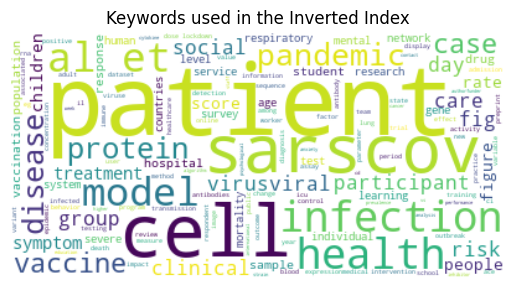

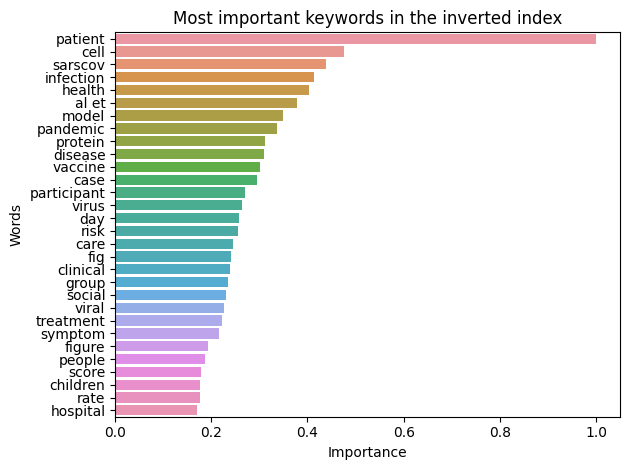

In [129]:
# some words from version2 dataset has numbers, sow e convert them to string
str_words = [str(x) for x in list(keyword_df["word"])]

# word cloud using 80000 words
word_kw = " ".join(str_words[:80000])

# word cloud
wrd_cloud = WordCloud(background_color='white', max_words=500)
wrd_cloud.generate(word_kw)

# keyword frequency
wrd_words_rank = wrd_cloud.words_
df_wrd_rank = pd.DataFrame()
df_wrd_rank["Words"] = wrd_words_rank.keys()
df_wrd_rank["Total"] = wrd_words_rank.values()

# plot word cloud
plt.imshow(wrd_cloud, interpolation="bilinear")
plt.title("Keywords used in the Inverted Index")
plt.axis("off")
plt.show()

# plot frequency
sns.barplot(x="Total", y="Words", data=df_wrd_rank.iloc[:30])
plt.title("Most important keywords in the inverted index")
plt.ylabel("Words")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

**<font color="red">analysis</font>**

* From the above analysis we can see that using word cloud we can clealry identify we have extracted better keywords because, all the words we observe are clinical terms. The extracted keywords contains "Sarscov", "disese", "virus", "pandemic" and "vaccine" and these words much related to any covid19 articles and having these clinical terms will help us in extarcting the better articles.

* In the Inverted Index, we can also observe that most important keywords from covid19 articles are related to "patient", "cell", "sarscov", "infection", "pandemic" and "vaccine". This gives trust in the developed inverted index using the two approach that is, TFIDF and NER model that inverted index can retrieve good articles based on user query

**<font color="red">Conclusion</font>**

From the above analysis, we can see that we have extarcted keywords from TFIDF and NER model and used them as Inverted index. Each keywords consists of its corresponding document path. We also found that, using the dataframe for inverted index is slower, but using the dictonary format we were able to extarct and fetch keywords faster. 

To store the keywords from the inverted index, we used pickel format instead csv because pickle format compresses the dataset size and has faster read and write. 

In the Inverted Index, we can also observe that most important keywords from covid19 articles are related to "patient", "cell", "sarscov", "infection", "pandemic" and "vaccine". This gives trust in the developed inverted index using the two approach that is, TFIDF and NER model that inverted index can retrieve good articles based on user query

## <font color="purple">3. NAMED ENTITY RECOGNITION and KNOWLEDGE BASE (KNOWLEDGE GRAPH)</font>

In this section, we develop knowledge base. Knoweledge base is also called as knowledge graph. To develop knowledge graph we use NER model to extract the entities and use the dependencies to extract the relation between the entities. 

**Our aim from knowledge graph is to extract the articles very rleant therefore we need good entities and as many possible relations between them**

**Approaches used to solve NER**

In this analysis we found that using regualr default NER model from Spacy does not extract the most of the medical words used because the default model was not trained on medical data therefore, we used another variant of Spacy model which is used for medical entities taht is "SciSpacy". Using this model for extracting the entity we were able to extract good clinical terms. 


**Approaches used to solve knowledge graph**

In this analysis, we used various approaches such as;

1. using the coreference resolution to obtain the relation between the words
2. using the whole articles and extracting two entity and one relation based on article 
3. using sentences from articles to extract entites and relation within them
4. sing the NER model to extract the entities and making a pair between the entities along with the relations between them.


**1. using the coreference resolution to obtain the relation between the words**

In this strategy of knowledge graph building, when we used coreference resolution to extract the relations, they were based on very common words such as "help", "aapplied", or "process". These each relations will connect many knowledge graph data because these words were very common in the dataset. Therefore, locating the articles using such large knowledge graph will slower the response time. 

**2. using the whole articles and extracting two entity and one relation based on article**

In this strategy, we extracted two entities out of the articles and one verb words that matches these two entity such as, eg: facemak lowers spread. Here, "lowers" is a relation. But we observed that using one verb for whole article  is not a good method because it does not resemble the whole article. 

**3. using sentences from articles to extract entites and relation within them**

In this strategy, we extracted sentences from each articles and extarcted two entities and one relations. This approach was better compared to previous method but using sentence tokensization on each articles will make lot more dataset and processing time increased. Therefore used below best approahc.

**4. using the NER model to extract the entities and making a pair between the entities along with the relations between them.**

We know that spacy can extarct NER entities and it can also extract the dependency of the article. That is, words that relates most of the words in the article. It represent dependecies as "ROOT". The ROOT word relates the articles. Since, we know that whole article cannot be dependent on one ROOT word, we used only 2500 words of articles and extracted one ROOT word and used this ROOT word as a relation between all the pairs of entities extracted using NER. We found that this method works much betetr compared to other method.


**Steps to solve**

* Step 1: Extract entities using NER model based on medical data. 
* Step 2: Extract the relations of the sentences in the articles using the Spacy dependencies.
* Step 3: Make a pair between the entities and their corresponding relations
* Step 4: Testing the knowledge graph using queries

**Document wise keywords for query**

Extarct the entities corresponding to the documents

In [18]:
# documents wrt entities
docwise_kw = {"doc"+str(x):[] for x in range(len(data_df_v2))}

In [19]:
# extracting entites wrt documents, select top 10 entities
for i in tqdm(range(len(data_df_v2)), total=len(data_df_v2)):
    docwise_kw["doc"+str(i)] = (df_kw_ner[df_kw_ner["docid"]==i]["word"]).to_list()[:10]

100%|███████████████████████████████████████████████████████████████████████████| 12010/12010 [01:38<00:00, 121.35it/s]


**Extracting NER from the articles**

In [5]:
# NER library
import spacy
import en_core_sci_sm
from spacy.matcher import Matcher
from spacy.tokens import Span

In [13]:
# Extracting smaller sample from the text
sample_text = " ".join(cleaned_text_v2[4846].split()[:500])
sample_text

In [6]:
# Extracting the NER from the text
# Load NER
nlp_ner_kw = en_core_sci_sm.load()

# First 10 entities from the model
nlp_ner_kw(sample_text).ents[:10]

From the above analysis, we can see that we were able to extract the entites from the NER model. Here we have extracted the clinical term such as liver injury, covid19, coranvirus. These clinical term extarction using the deafult model from Spacy is not possible as tehya re trained using different data. 

In [28]:
# Extracting smaller sample from the text
sample_text = " ".join(cleaned_text_v2[0].split()[:500])
sample_text

'high incidence of multiple viral infections identified in upper respiratory tract infected children under three years of age in shanghai china background upper respiratory tract infection urti is a major reason for hospitalization in childhood more than 80 of urtis are viral etiological diagnosis of urtis is important to make correct clinical decisions on treatment methods however data for viral spectrum of urtis are very limited in shanghai childrenmethods nasopharyngeal swabs were collected from a group of 164 children aged below 3 years who were hospitalized due to acute respiratory infection from may 2009 to july 2010 in shanghai a vrdal multiplex pcr for 10 common respiratory viruses was performed on collected specimens compared with the seeplexh rv15 ace detection kit for 15 respiratory virusesresults viruses were detected in 84 512 patients by vrdal multiplex pcr and 8 49 of cases were mixed infections using the seeplexh rv15 ace detection kit viruses were detected in 129 787 p

In [29]:
# First 10 entities from the model
nlp_ner_kw(sample_text).ents[:10]

(incidence,
 multiple,
 viral infections,
 upper respiratory tract,
 infected,
 children,
 years,
 age,
 shanghai china,
 upper respiratory tract infection)

From the above analysis, we can see that we were able to extract the entites from the NER model. Here we have extracted the clinical term such as viral infections, infected and upper respiratory tract infection. These clinical term extarction using the deafult model from Spacy is not possible as tehya re trained using different data. 

**<font color="purple">Named Entity Disambiguation (NED)</font>**

While developing the NER we sometime extarct the entites that we assume has same meaning or property but it is not. For example, Apple was founded by Steve Jobs however, apple was also the key motivation for developing the Newtons gravitational laws.

In order to remove the disambiguity we perform linking and during linking we reduce the ambiguity by connecting the node to multiple entities. 

In this analysis, we used two approach for detecting the relation in the NER that is,
1. Coreference resolution
2. Dependency analysis 

We found that using the coreference resolution we sometime capture the relatuions such as "needed", "apply" whcih are not medical terms but dependency analysis was able to retierve the most probable inking word for building the knowledge graph. 

* **<font color="red">Coreference resolution</font>**

In [65]:
import spacy_experimental

In [69]:
# extracting the dependency 
coref_res_ = spacy.load("en_coreference_web_trf")

# extracting small sample text for dependency 
sample_text = " ".join(cleaned_text_v2[4846].split()[:150])
sample_text

'liver injury with covid19 laboratory and histopathological outcomesystematic review and metaanalysis background the novel coronavirus severe acute respiratory syndrome coronavirus 2 sarscov2 infection has been predominantly linked to respiratory distress syndrome but hepatic injury has also been reported the mechanism of liver injury is poorly understoodthis review aimed to systematically review the current data through laboratory tests and liver tissue pathology to ascertain the correlation of liver involvement in sarscov2 infection patientsthe pubmed scopus science direct and web of science databases were searched systematically we included peerreviewed published papers available online as clinical cases cohort studies and retrospective studies for both in vitro and in vivo human studies independent extraction of the data was done by two independent authorsresults a total of 15 articles were finally included in the systematic review process and metaanalysis after exclusion of studie

In [70]:
# depency analysis 
coref_text = coref_res_(sample_text)

# displaying the text, pos, and dependency
coref_text.spans

{'coref_clusters_1': [review, understoodthis review, we], 'coref_clusters_2': [coronavirus 2 sarscov2 infection, sarscov2 infection], 'coref_clusters_3': [the current data, the data]}

**<font color="red">analysis</font>**

From the above analysis, we can see that in cluster 1: it has "review, understoodthis reciew, we" are the words. It means that these words share the same meaning. Thus reduces ambiguity while developing the NER entities. Whereas words like, coronavirus, sarscov2 shares the same property. But we understood while deploying this idea there are cases where it makes most of the relation using the words like "them", "Apply" or "needed" which does not resemble the clinical terms. Therefore we are using another approach to reduce ambiguity while developing the entities and knowledge graph.

* **<font color="red">Dependency analysis</font>**

In [21]:
from spacy import displacy

In [22]:
# extracting the dependency 
depens_ = spacy.load("en_core_web_sm")

In [24]:
# extracting small sample text for dependency 
sample_text = " ".join(cleaned_text_v2[4846].split()[:50])
sample_text

'liver injury with covid19 laboratory and histopathological outcomesystematic review and metaanalysis background the novel coronavirus severe acute respiratory syndrome coronavirus 2 sarscov2 infection has been predominantly linked to respiratory distress syndrome but hepatic injury has also been reported the mechanism of liver injury is poorly understoodthis review aimed to systematically'

In [25]:
# depency analysis 
dep_text = depens_(sample_text)

# displaying the text, pos, and dependency
for tok in dep_text:
    print(tok.text, "->",tok.pos_, "->",tok.dep_)

liver -> NOUN -> compound
injury -> NOUN -> ROOT
with -> ADP -> prep
covid19 -> PROPN -> compound
laboratory -> PROPN -> pobj
and -> CCONJ -> cc
histopathological -> ADJ -> amod
outcomesystematic -> ADJ -> amod
review -> NOUN -> conj
and -> CCONJ -> cc
metaanalysis -> VERB -> compound
background -> NOUN -> conj
the -> DET -> det
novel -> ADJ -> amod
coronavirus -> PROPN -> nmod
severe -> ADJ -> amod
acute -> ADJ -> nmod
respiratory -> ADJ -> amod
syndrome -> NOUN -> compound
coronavirus -> PROPN -> appos
2 -> NUM -> nummod
sarscov2 -> NOUN -> compound
infection -> NOUN -> nsubjpass
has -> AUX -> aux
been -> AUX -> auxpass
predominantly -> ADV -> advmod
linked -> VERB -> ROOT
to -> ADP -> prep
respiratory -> ADJ -> amod
distress -> NOUN -> nmod
syndrome -> NOUN -> pobj
but -> CCONJ -> cc
hepatic -> ADJ -> amod
injury -> NOUN -> nsubjpass
has -> AUX -> aux
also -> ADV -> advmod
been -> AUX -> auxpass
reported -> VERB -> conj
the -> DET -> det
mechanism -> NOUN -> nsubj
of -> ADP -> prep


In [26]:
displacy.serve(dep_text, style="dep")


Using the 'dep' visualizer
Serving on http://0.0.0.0:5000 ...

Shutting down server on port 5000.


**<font color="red">analysis</font>**

From the above analysis, we can see that ROOT words are "injury" which shows that most of the words are related to this word. Sometime, due large in article we have multiple ROOTS. 

In our analysis, we consider using the ROOT as our relation in the entities for building the knowledge graph. Our models worked betetr using this approach for finindg the relations between the entites while compairng the use of coreference resolution approach.

**Building the knowledge graph using NER**

In [7]:
def relationextract(sent, model_ner):
    
    '''This function is used for obtaining the relations between the articles
    
    input argument:
    sent: text
    model_ner: NER model
    '''
    # select the first 2500 words
    sent = " ".join(sent.split()[:2500])
    # NER 
    fg = model_ner(sent) 
    # vocab
    match = Matcher(model_ner.vocab)
    # patterns as ROOT
    pattern = [{'DEP':'ROOT'}] 
    match.add("HAS_sentence", [pattern]) 
    matches = match(fg)
    # If no ROOT in the sentence, we assign relation as NOROOT
    for mid, s, e in matches:
        span = fg[s:e]
        break 
    if str(span)==' ':
        return "_NOROOT_"
    else:
        return span

In [8]:
def extract_entity_relations(model_ner, texts, docwise_kw):
    
    '''This fucntion is used for extracting the entities using
    NER mdoel
    
    input arguments: 
    
    model_ner = NER model
    texts: articles
    dockwise_kw: document wise entities
    '''
    ent_pair_ = []
    doc_id_ls = []
    ent_reltn = []
    
    doc_id_x = 0
    
    # loop articles
    for texts_kg in tqdm(texts, total=len(texts)):
        # extract relations
        extract_root_relation = relationextract(texts_kg, model_ner)
        # entities based on document
        doc_ent_ner = docwise_kw["doc"+str(doc_id_x)]
        # pair wise 
        pairs_ents = list(itertools.permutations(doc_ent_ner, 2))
        ent_pair_+=pairs_ents
        doc_id_ls+=[doc_id_x]*len(pairs_ents)
        ent_reltn+=[str(extract_root_relation)]*len(pairs_ents)
        doc_id_x+=1  
    return ent_pair_, ent_reltn, doc_id_ls

In [9]:
import itertools

In [ ]:
# Building the knowledge graph 

ent_pair_, ent_reltn, doc_ent =extract_entity_relations(nlp_ner_kw, 
                                                        list(data_df_v2["cleaned_text"]),
                                                       docwise_kw)

In [ ]:
# knowledge graph dataframe 

df_kg = pd.DataFrame()
df_kg["docID"] = doc_ent
df_kg["subject"] = [x[0] for x in ent_pair_]
df_kg["target"] = [x[1] for x in ent_pair_]
df_kg["relation"] = ent_reltn

In [73]:
# saving knowledge graph data

df_kg.to_csv("dfkg.csv", index=False)

In [10]:
# loading the knowledge graph data 

df_kg = pd.read_csv("dfkg.csv")

In [11]:
# displaying the knowledge graph relations

df_kg 

docID    subject                   target   relation
0            0  incidence                 multiple  performed
1            0  incidence         viral infections  performed
2            0  incidence  upper respiratory tract  performed
3            0  incidence                 infected  performed
4            0  incidence                 children  performed
...        ...        ...                      ...        ...
1080379  12009      study                  covid19    focused
1080380  12009      study                perceived    focused
1080381  12009      study                   stress    focused
1080382  12009      study               friendship    focused
1080383  12009      study                  quality    focused

[1080384 rows x 4 columns]

**Knowledge graph testing**

In this analysis, we test our knowledge  graph using the queries from the user. Here, we take query and plot the knowledge graph of the query.

In [12]:
import networkx as nx

In [13]:
# query from user 
query = "risk associated with a more severe course of COVID-19 among multiple sclerosis (MS) patients?"


# text processing
query = run(query, ["lowercase", "punctuations"])

In [14]:
# Extracting the relation from the query 
relationextract(query, nlp_ner_kw)

risk

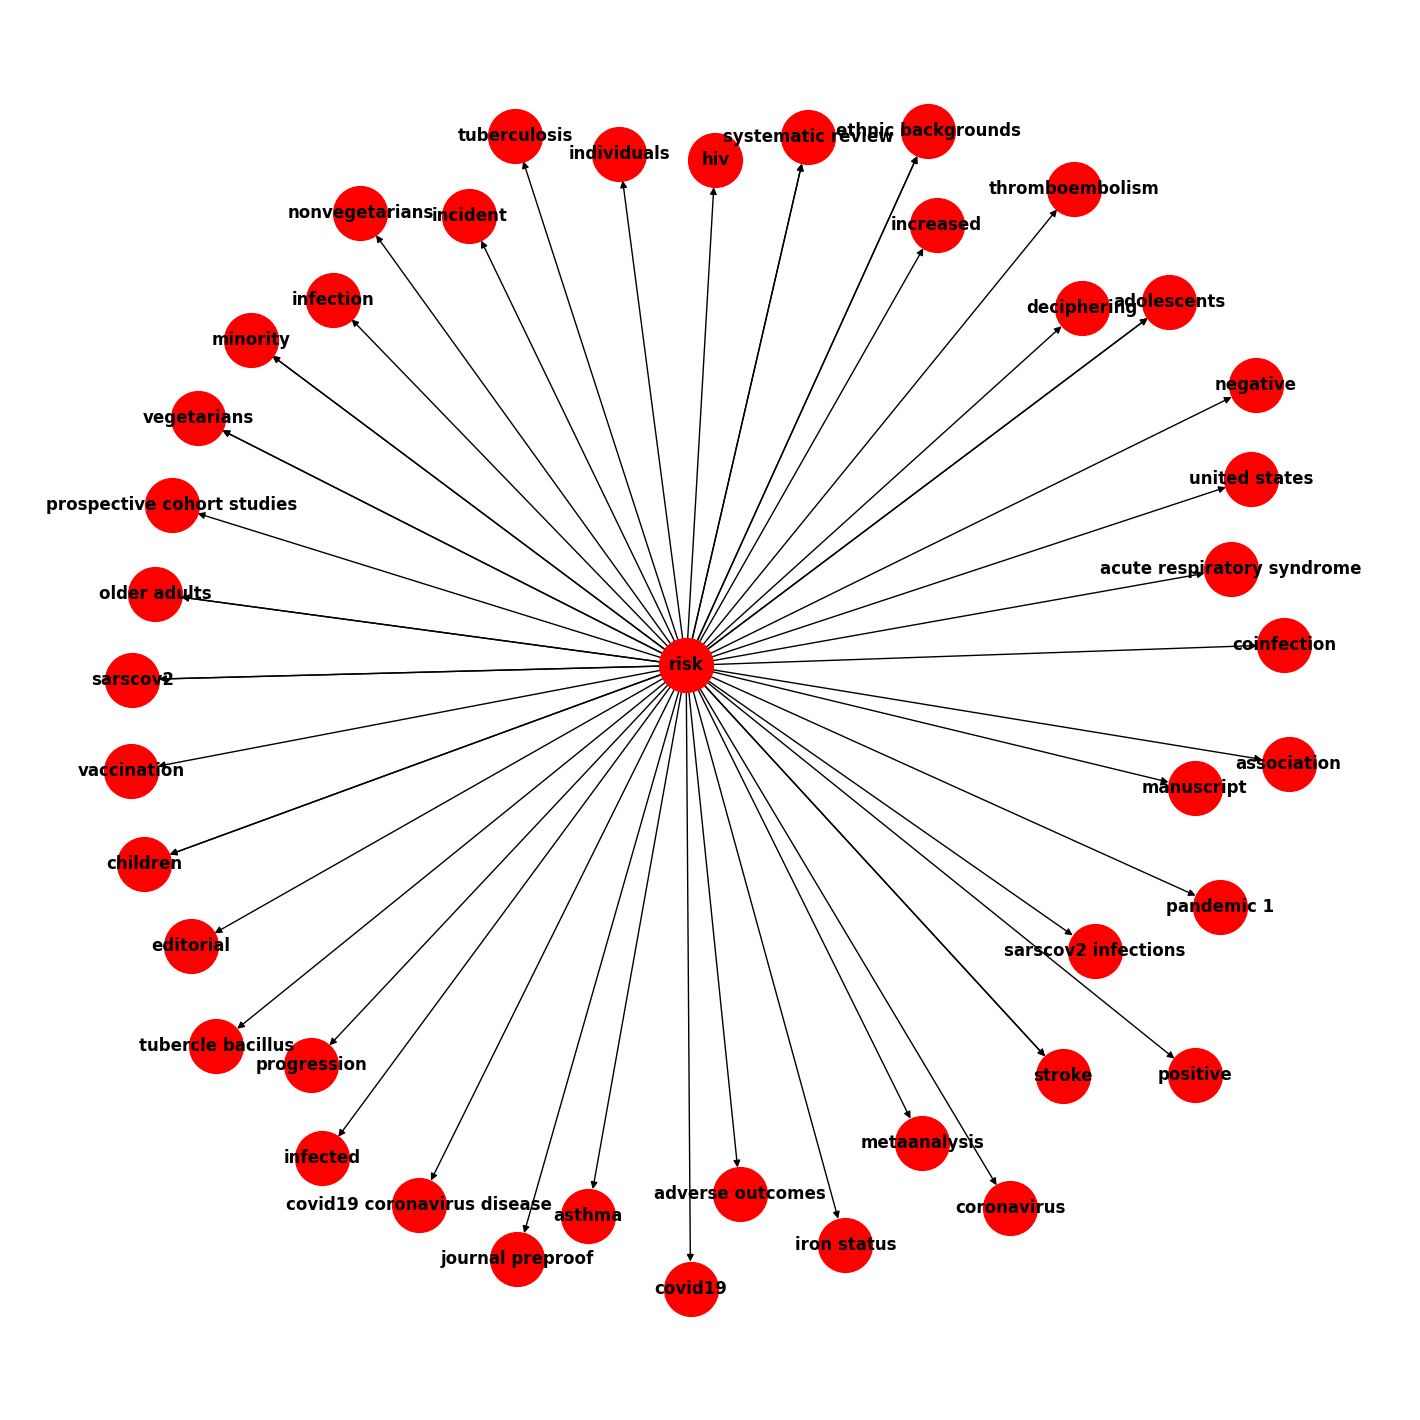

In [35]:
# knowledge graph plot 
G=nx.from_pandas_edgelist(df_kg[df_kg['subject']=="risk"].iloc[:50], "subject", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(14, 14))
pos_ = nx.spring_layout(G, k = 0.5) 
nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos_, font_weight='bold')
plt.show()

**<font color="red">analysis</font>**

In this analysis, we can see that our relation "risk" is related to various knowledges such as, vaccination, sarscov-2, pandemic or asthama. Word "risk" is associated to many knowledges however, we only need articles that is related to covid19 which is further extarcted using the inverted index. 

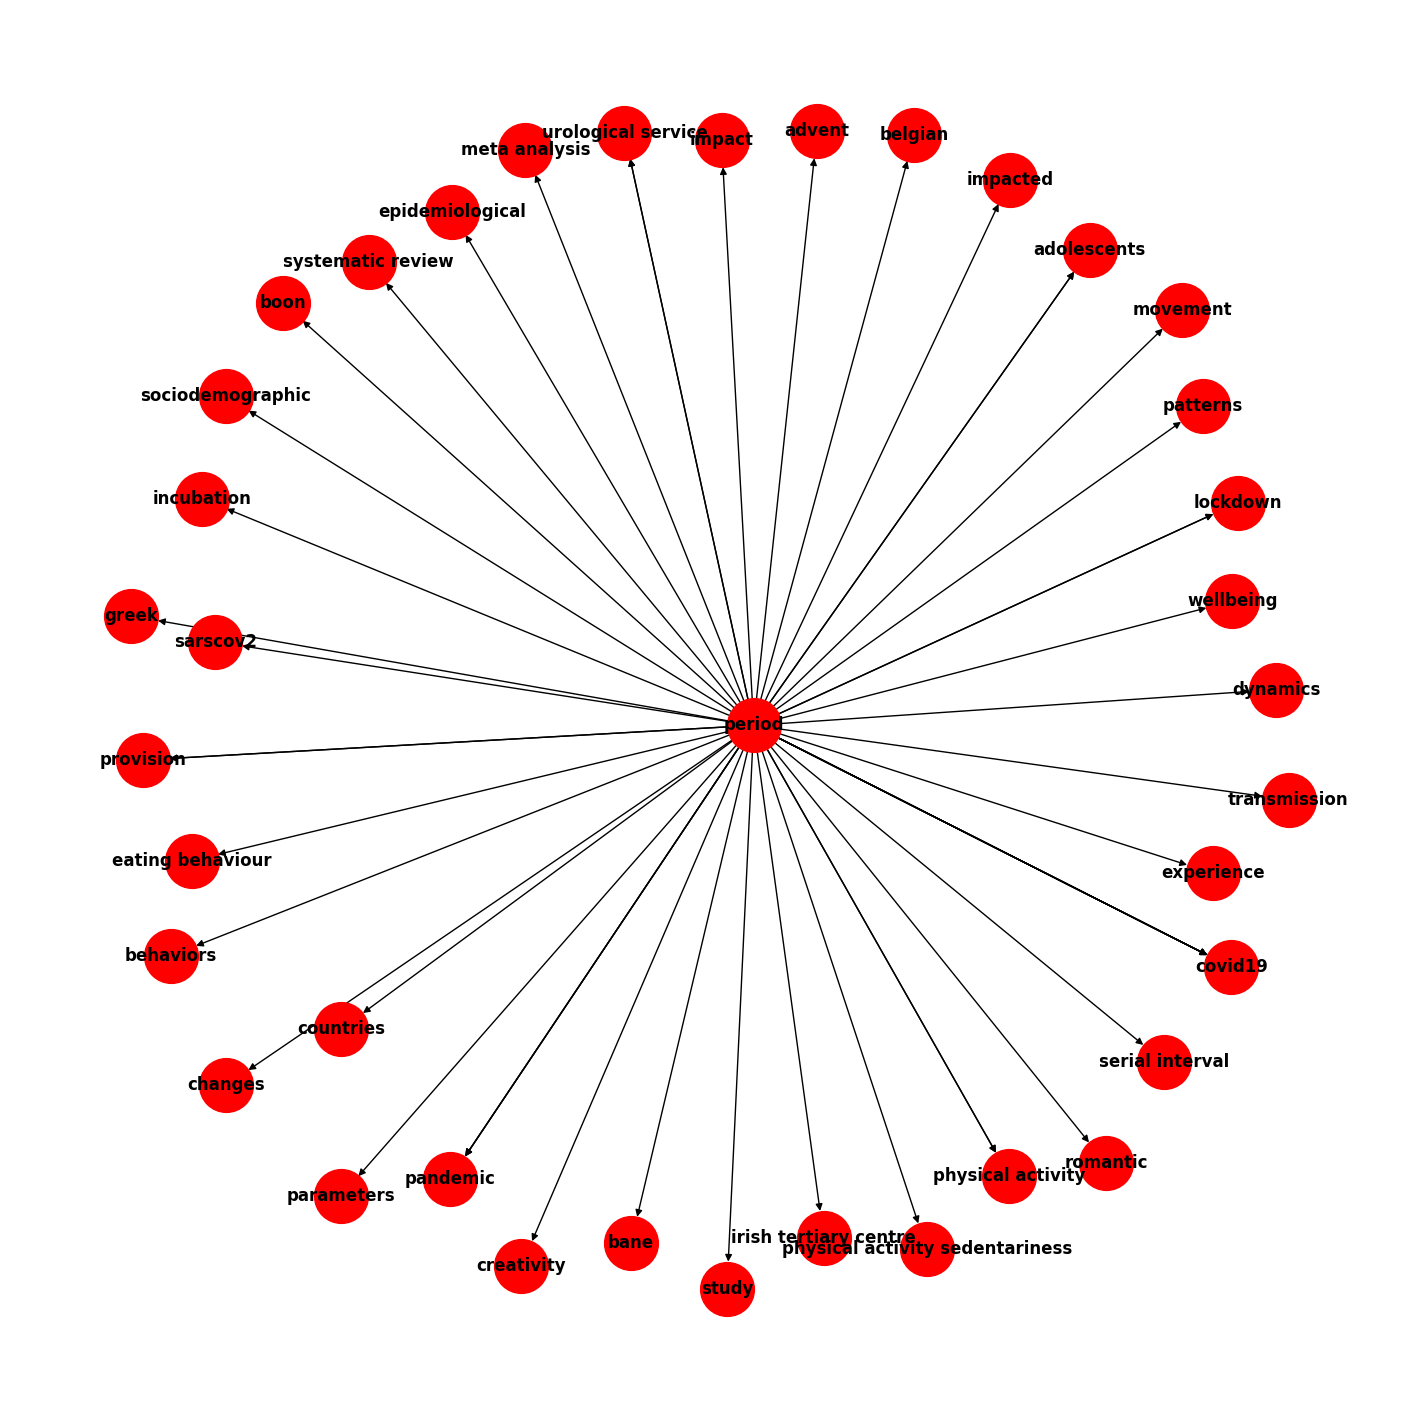

In [36]:
# query from user
query = "incubation period for covid19?"

# text processing
query = run(query, ["lowercase", "punctuations"])

# knoeledge graph
G=nx.from_pandas_edgelist(df_kg[df_kg['subject']==str(relationextract(query, nlp_ner_kw))].iloc[:50], "subject", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(14,14))
pos_ = nx.spring_layout(G, k = 0.5) 
nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos_, font_weight='bold')
plt.show()

**<font color="red">analysis</font>**

In this analysis, we can see that our relation "period" is related to various knowledges such as, incubation, lockdown, pandemic or transmission. Word "period" is associated to many knowledges however, we only need articles that is related to covid19 which is further extarcted using the inverted index. 

However, we can see that our knowledge graph is extracting very much relavant knowledges for extracting articles.

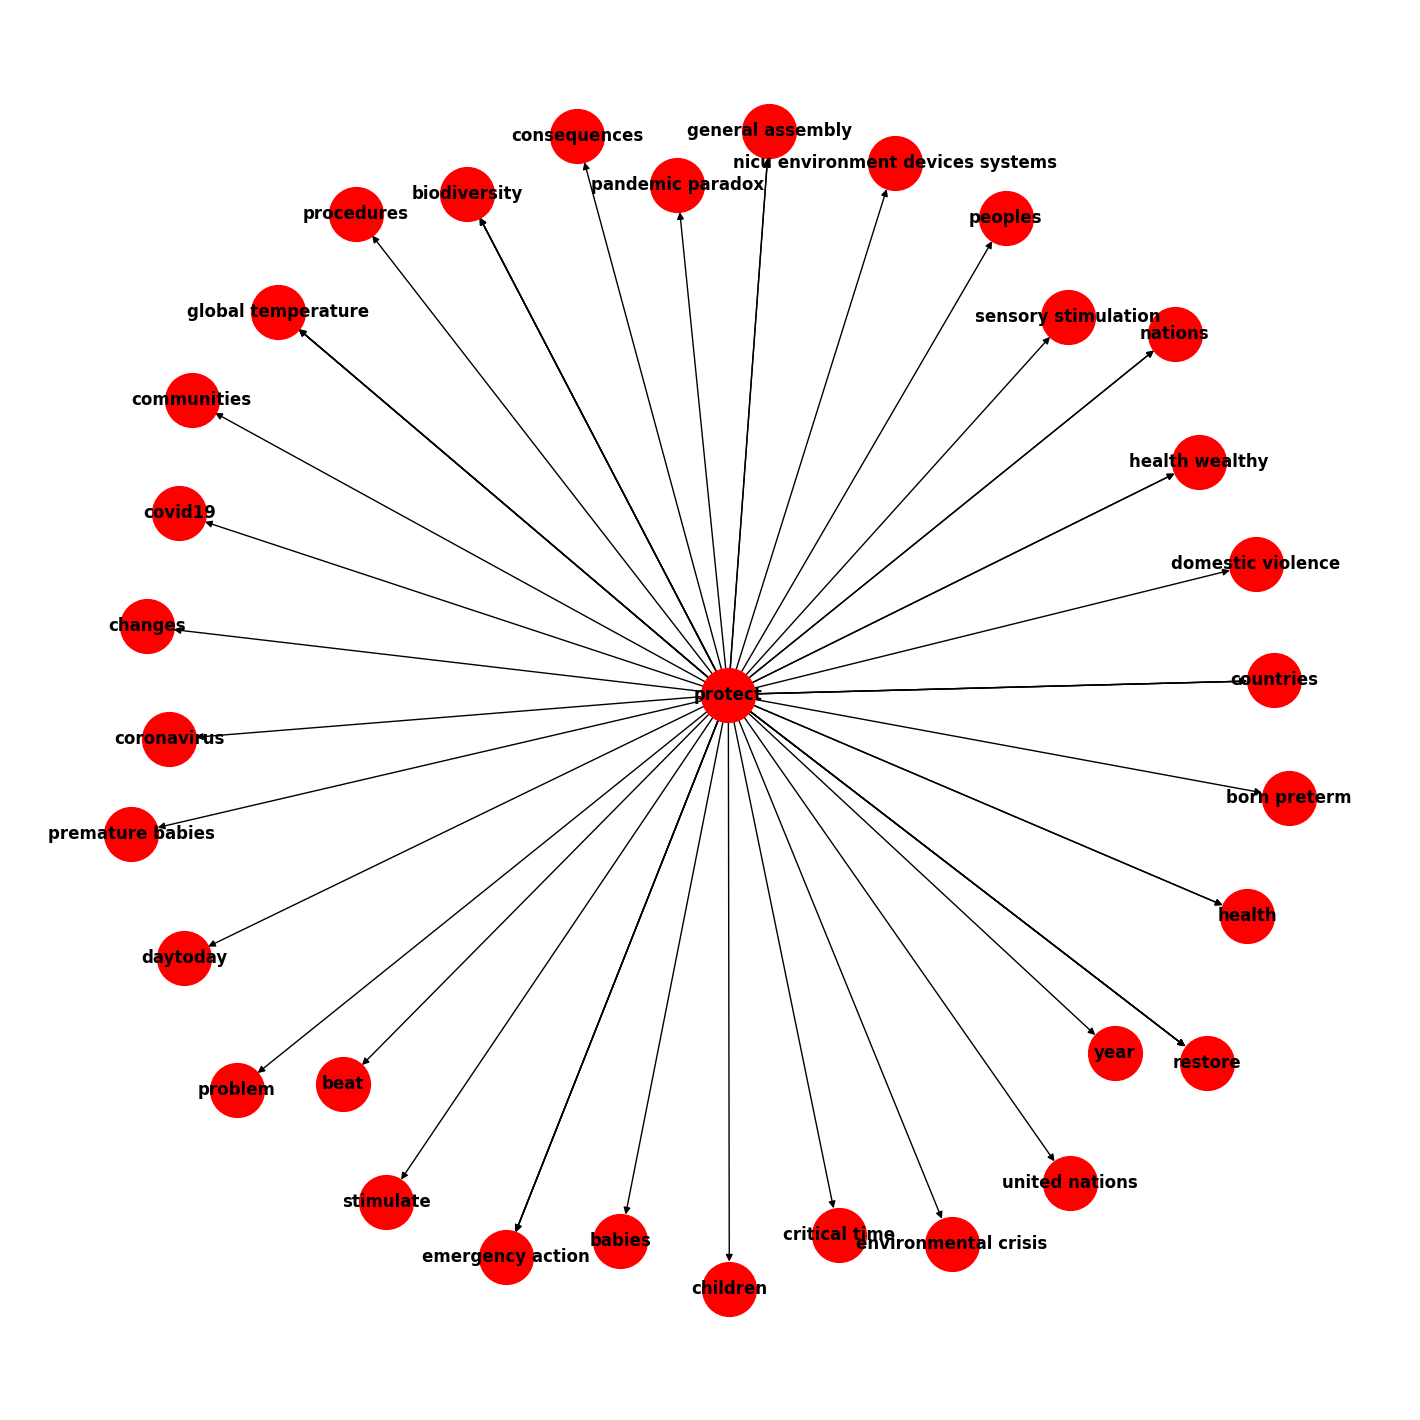

In [37]:
# query from user
query = "how to protect from covid19"

# text processing
query = run(query, ["lowercase", "punctuations"])

# knowledge graph
G=nx.from_pandas_edgelist(df_kg[df_kg['subject']==str(relationextract(query, nlp_ner_kw))].iloc[:50], "subject", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(14,14))
pos_ = nx.spring_layout(G, k = 0.5) 
nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos_, font_weight='bold')
plt.show()

**<font color="red">analysis</font>**

In this analysis, we can see that our relation "protect" is related to various knowledges such as, covid19, health, pandemic or pandemic. From the above knowledge graph we can observe that our knowledge relations are very much clear and using these relations we can extract the better articles.

**<font color="red">CONCLUSION</font>**

Our method for creating the knowledge graph was based on pairs and we can see that from the  knowledge graph output from the user query that our extracted papers are very relevant and these knowledge can later be used for extarcting betetr paper using inverted index and word embeddings. 

In [19]:
import pandas as pd
import pickle

In [26]:
docurl = list(data_df_v2["URL"])

## <font color="purple">4. TEXT MATCHING UTILITY WITH SUMMARIZATION</font>

To develop text matching utility we used several approahces:

1. Text matching using the knowledge graph
2. Text matching using the knowledge graph and Inverted index
3. Text matching using the Knowledge graph , Inverted index and word embeddings

**1. Text matching using the knowledge graph only**

In this strategy, we passed our query to testing function and we used relations from the query to extract the sub-part of knowledge graph and later extracted these paper and obtained the most appearing document. Articles were extracted using the most appearing articles numbers. However, using this method we found that sometime our relations does not really connects most of the articles and thus we had poor articles extractions. For example: word like"covid19" can apppear many time in the articles but that does not mean that is best articles according to the query because query has many other NER entities. 

**2. Text matching using the knowledge graph and Inverted index**

This strategy is extension of our first approach, here we did not only calculated most appearing document using the knowledge graph from user query words, we also included inverted index to look into other words and document. Using this approach and using inverted index it helped in obtaining the best top ranking articles. However, we found that sometime most of the top ranked articles have same appearance number that is example: doc78: 7 doc98:7  therefore, we needed some method to normalize this same top ranking score. Which is solved later using the word embeddings similaity score. 

**3. Text matching using the Knowledge graph , Inverted index and word embeddings**

Our strategy from the first is an extension to previous approach. In this strategy to overcome the issue of similar ranking documents, we used word embedding method. In our approahc we calculated the score using the following steps: 
1. Step 1: Extracted all the documents relating with knowledge graph 
2. Step 2: Extracted all the documents based on NER entities from the query 
3. Step 3: Using the knoeldge graph dataframe we reduced our search space two smaller search space by considering the unique dataframe extracted and we calculated the document embedding using the word embedidng.
4. Calculated cosine similrity score between the query and articles extracted from step3
5. Normalised the scores from articles extracted using inverted index by multiplying the cimilaity score to the appearance number. 

For example: if doc78 has appeared 7 times from theuser query and doc:98 has appeared 7 times then we obtain the cosine similarity for query and doc:78 and doc:98. Later we multiply the similaity score to normalise the actual score.

actual score of doc 78 = (7)*0.8567 = 9.99

actual score of doc 98 = (7)*0.769 = 5.38 

Therefore, we can see that even though had similar scores from inverted index, by using the cosine similaity we obtained the better scoring approach.  

Knowledge graph has been really usefull for extracting the sub-graph which reduces the search space for determining the similaitry between query and article by word embedidng otherwise, we should have checked with all the 12010 articles whcih takes very long time. 

Inverted Index has been useful for locating the documents that contains the user query words. But word embedding brings the similaity measure between the docuemnts and thus we have good extarcted articles.

All the extracted articles are related and similair to each other.


**Approach used for soloving word embedding issues**

In this analysis we used word2vec for word embedding. Here we did not train our own word embedding because when the user gives the query the words may not present in our trained vocabulary. Therefore we used previously traine model. However, problem here is we cannot use any word embedding methods. Because Glove pretrained model has been trained on wikipedia dataset and while calculating the similairy score the scores does not reflect the information thus we need word embedidngs from clinical data therefore we used clinical embedding for the word2vec using the below github. 

https://github.com/gweissman/clinical_embeddings

Using this embedidngs we were able to extract good word embeddings in relation with the query. However, we solved the issue of extracting good similaity but we came up with another issue of laoding large model and our notebook was hutting down everytime I loaded the model.

**Approached used to solve the word embedding loading issues**

In this analaysis, we know that we only need word embedidngs and nothing like similair words from word2vec therefore, I extarcted all the vocabulary and its corresponding 100 dimensional vector and stored in the dictonary format. Which is later furtehr compressed using the pickle data compression with highest protocol. This helped in laoding the word embeddings faster and fetch the embeddings faster. 

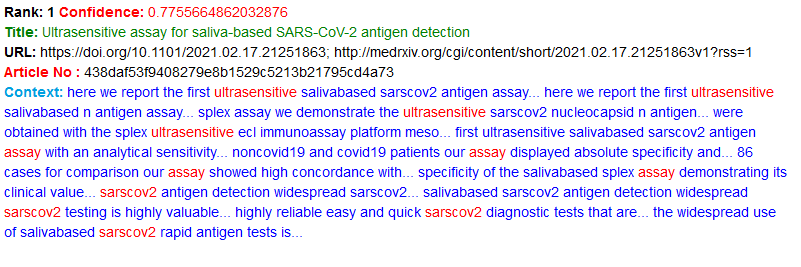

Above figure is an example of our extarcted articles based on the user query.

After fecting the top articles, we highlight articles with user query keywords and we use the HTML tags to highlight the query keywords. Use of highlight is to make the user easy to locate of the extarcted article has the required query and snippet context helps in understanding the extracted article have same required context by the user.

We can see that output has Rank number, confidence score, title, URL, article number and contexct with highlighting. 

We need rank number to specify if the article is top 1 rank or top 5 based on similairy match. Whereas, confidence score gives the insight that the extracted article has some probablity of relevance. Whereas, title is the extracted papers title. Article number is the paper ID of the article.

We also provide URL of the extracted paper, so that user can personally view the more details of the extracted paper and context extarcted helps in understanding if the extracted paper has the required query keywords. 

**Storing the word2vec embeddings**

In [ ]:
# clinicnal embedding 
from gensim.models import Word2Vec

# loading the original embeddings 
model_clinical = Word2Vec.load("D:/clinical_embed/W2V_100/w2v_oa_all_100d.bin")

# 
voc_w2v = model_clinical.wv.word_vec.vocab_

# creat keys from vocab 
d2v = {k:[] for k in voc_w2v}

# adding word embeddings for the dictionary 
for v in voc_w2v:
    d2v[v]=model_clinical.word_vec(v)
    
# saving the dictionary file in pickle format 
with open("clinicalembed_dict.pickle", "wb") as clinc:
    pickle.dump(d2v, clinc, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
from sklearn.metrics.pairwise import cosine_similarity 

In [21]:
# loading the word2vec embeddings 

with open("clinicalembed_dict.pickle", "rb") as clinc:
    model_clinical = pickle.load(clinc)

In [22]:
# articles from cleaned version 2
fullarticles = list(data_df_v2["cleaned_text"])

In [27]:
def testingutility(query, articles, nermodel, totalreturn=10, plot_kg=False, 
                   invertedindexkeys = imp_keys_doc_path,
                   wholedf = data_df,
                   dataversion = data_df_v2,
                   urldata = docurl,
                   knowledgegraph = df_kg, 
                   wordembeddings = model_clinical,
                   basedon = "relation",
                   extractpaper=True,
                   summary = True):
    
    '''This function is used for extracting top ranked articles 
    based on the query
    
    input argument: 
    
    query: query from user 
    articles: cleaned version 2 data 
    wholedf = original data 
    nermodel: NER model 
    totalreturn: total required ranked documents
    plot_kg: if True, we plot knowledge graph, else we dont  
    invertedindexkeys: inverted index keywords 
    dataversion: cleaned version in dataframe  
    urldata: documents URL
    knowledgegraph: knowledge graph dataframe 
    wordembeddings: word2vec word embeddings 
    basedon: knowledge graph plots based on relation/subject or target 
    extractpaper: if True, we extarct top ranked paper else we dont 
    summary = if True, we provide summary of the top 5 articles
    
    '''
    
    # Pre-processing input query
    query = run(query, ["lowercase", "punctuations"])
    
    # Extracting the relation from the query
    relations = relationextract(query, nermodel)
    
    # Extracting the NER entities of the medical terms
    doc_query = nermodel(query)
    
    # --------------------------Inverted Index ----------------------------------
    # Using inverted index to locate all the documents using the entities
    alldoc_path = []

    for ent in tqdm(doc_query.ents, total=len(doc_query.ents)):
        try:
            alldoc_path+=list(set(imp_keys_doc_path[str(ent)]))
        except:
            apath = " " 
            
    # Using document path from the inverted index, we located which document has most words from the query
    doc_kw, doc_freq = np.unique(alldoc_path, return_counts=True)
    dfkw_freq = {"doc"+str(x):v for x,v in zip(doc_kw, doc_freq)}
    dfkw_df = pd.DataFrame()
    dfkw_df["docID"] = list(dfkw_freq.keys())
    dfkw_df["Frequency"] = list(dfkw_freq.values())
    
    # Upon locationg the total frequency of documents, we sort it.
    dfkw_df = dfkw_df.sort_values(by="Frequency", ascending=False)
    
    # we extract top 20 articles article NO, as lower score articles are not needed 
    top20 = list(dfkw_df.iloc[:20]["docID"])
    
    # -------------------------------Knowledge Graph --------------------------------
    
    kgdoc_path = [] 
    
    # Extracting knowledge graph using the relation of the query
    relations_doc = list(knowledgegraph[knowledgegraph["relation"]==str(relations)]["docID"])
    
    # Query entities
    locators_kg = [x for x in doc_query.ents] 
    
    # Extracting the knowledge graph based on subject (subject and target are pair)
    for lkg in locators_kg:
        kgdoc_path+=list(knowledgegraph[knowledgegraph["subject"]==str(lkg)]["docID"])
    kgdoc_path+=relations_doc
    
    # Extracting the unique set of articles 
    kgdoc_path_unq = list(set(kgdoc_path))
    
    # --------------------- Combining the Inverted index and Knowledge graph -----------------------
    
    set_doc_unq = list(set([int(x[3:]) for x in top20]+kgdoc_path))
    
    # ----------------------------- Word2Vec word embedding --------------------------------
    
    # Here, we will use word2vec on set of unqiue articles to check similarity with query
    
    
    # Query embedding according to document method, 100 dimension vector
    query_embed = np.zeros(100,)
    doc_query_x = [str(x) for x in doc_query.ents]
    # For each entity, we use embedidng method
    for dqx in doc_query_x:
        try: 
            query_embed+=wordembeddings[str(dqx)]
        except:
            dg = " "
       
    # Cosine similarity with the unique articles and query embedding
    docscore = {}
    for docid in tqdm(top20, total=len(top20)):
        embedarr = np.zeros(100,)
        text_f = articles[int(docid[3:])]
        text_f = " ".join(text_f.split()[:2500])
        text_ents = nermodel(text_f).ents
        for entx in text_ents:
            try:
                embedarr+=wordembeddings[str(entx)]
            except:
                dg = " "
        docscore[docid] = cosine_similarity(query_embed.reshape(1,-1), embedarr.reshape(1,-1)).item()
        
        
    # Scoring the articles based on total frequency and cosine similarity
    scorearticle = {}
    for dc in docscore.keys():
        try:
            scorearticle[dc] = dfkw_freq[dc]*docscore[dc]
        except:
            dt = ""
        
    score_article_df = pd.DataFrame()
    score_article_df["docID"] = list(scorearticle.keys())
    score_article_df["score"] = list(scorearticle.values())
    score_article_df["cosine"] = list(docscore[x] for x in top20)
    score_article_df = score_article_df.sort_values(by="score", ascending=False)
    
    # Extracting the top X relevant documents 
    topX = score_article_df.iloc[:totalreturn] 
    
    if summary:
    
        # summary of the top 5 artilces 
        art_id = [int(x[3:]) for x in topX["docID"]][:5]
        summary_top5 = summarizetop5(art_id, wholedf, dataversion)
        html_summary = "<br>"+"<font color='blue'>"+"<b><u>Summary:</u></b> </br>"+"<font color='purple'>"+summary_top5+"</font>"

    # plotting knowledge graph
    
    if plot_kg:
        graph=nx.from_pandas_edgelist(knowledgegraph[knowledgegraph[basedon]==str(relations)].iloc[:50], "subject", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
        plt.figure(figsize=(12,12))
        plt.title("Knowledge Graph")
        pos = nx.spring_layout(graph, k = 0.5) # k regulates the distance between nodes
        nx.draw(graph, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos, font_weight='bold')
        plt.show()
        
        
    if extractpaper and summary:
        paper_Ex=" ".join(retrievenextractsnippet(topX, dataversion, nermodel, urldata))
        paper_Ex = "<br>"+html_summary+"</br>"+"<br>"+paper_Ex+"</br>" 
        display(Markdown(paper_Ex))
        
    if extractpaper and summary==False:
        paper_Ex=" ".join(retrievenextractsnippet(topX, dataversion, nermodel, urldata))
        display(Markdown(paper_Ex))
        
    return topX
    

In [28]:
def articlesnippet(sent):
    '''This function used for extracting the toke from articles 
    first 2500 words 
    
    input arguments:
    sent: text
    '''
    # first 2500 words
    sent = " ".join(sent.split()[:2500])
    word_tok = sent.split()
    return " ".join(word_tok)



def retrievenextractsnippet(topdata, data, nermodel, urls):
    
    '''This function used for outputting the extracted paper and produce highlight
    in the keywords of the articles based on user query
    
    input arguments:
    
    topdata: top ranked articles
    data: cleaned verison data 
    nermodel: NER model 
    urls: documents urls 
    '''
    
    # Extract the document numbers (Top x)
    #topdata = topdata.sort_values(by="cosine", ascending=False)
    listofdoc = list(topdata["docID"])
    listofdoc = [int(x[3:]) for x in listofdoc]
    
    # Titles
    titles_all = list(data["Title"])
    
    # articles
    articles = list(data["cleaned_text"])
    
    # paperids 
    paperids_ls = list(data["PaperId"])
    
    # confidfence score
    topdata_cosine = topdata.copy()
    topdata_cosine = topdata_cosine.sort_values(by="cosine", ascending=False)
    scores = list(topdata_cosine["cosine"])
    
    # Overall each article in HTML format with highlight
    main_sent = ["<center><font color="'purple'"><H1>Best Match Results</H1></font></center><br>"]

    # ranked document number 
    N = 0
    
    # loop each doc number
    for art in listofdoc:
        
        # extarct senetence with 2500 words
        ds = articlesnippet(articles[art])
        ds_tok = ds.split()
        # extract NER 
        doc_query = nermodel(ds)
        doc_query_x = [str(x) for x in doc_query.ents][:7]
        # some query words NER has multiple words, so we keep single word
        keywd_single_word = []
        for d in doc_query_x:
            keywd_single_word+=d.split()
            
        ds_keys = {k:[] for k in (keywd_single_word)}
        
        # Locating the place of each words
        for ix, k in enumerate(ds.split()):
            try:
                ds_keys[k]+=[ix]
            except:
                dq = ""
                
        sent_snippet = []
        
        # Here we make context using HTML tags and we use first 3 entites
        for d in keywd_single_word[:3]:
            try:
                high = 0
                for x in ds_keys[d]:
                    if x>=4: 
                        sent_snippet+=[" ".join(ds_tok[x-1-4:x])+" "+"<font color="'red'">"+"".join(ds_tok[x])+"</font>"+" "+" ".join(ds_tok[x+1:x+1+4])+"..."]                      
                        if high>2:
                            break
                        high+=1
            except:

                de = " " 
        # document articles     
        t_ = titles_all[art]
        
        # docuemnt paper id
        pid_ = paperids_ls[art]
        
        # score
        sco = scores[N]
        
        # append each articles with HTML tags and title, apperid, score and context
        main_sent.append("Rank: "+str(N + 1)+"<br>"+"<font color="'red'">Confidence score(Higher score is the better): "+str(sco)+"</font><br>"+"<font color="'green'"> Title: " +str(t_)+ "</font> <br>"+"URL: "+urls[
                             art]+"<br>"+"<font color="'red'"> Article No : </font>"+str(pid_)+"<br>"+"<font color=:"'orange'">Context: </font>"+"<font color="'blue'"> "+" ".join(
            sent_snippet)+"</font><br></br>")
        N+=1
        
    return main_sent
        

In [29]:
import time 
import torch
from rouge_score import rouge_scorer
from summarizer import Summarizer
from transformers import *

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# summary model 
model_scibert_cp = 'allenai/scibert_scivocab_uncased'
summary_ratios = 0.1
scibert_config = AutoConfig.from_pretrained(model_scibert_cp)
scibert_config.output_hidden_states=True
scibert_tokenizer = AutoTokenizer.from_pretrained(model_scibert_cp)
scibert_model = AutoModel.from_pretrained(model_scibert_cp, config=scibert_config)
model_scibert = Summarizer(custom_model=scibert_model, custom_tokenizer=scibert_tokenizer)


def summarizetop5(listofdoc, wholedata, cleaneddata):
    
    # listofdoc->artitcle id 
    # wholedata - data_df 
    # cleaned data - > data_df_v2 
    
    title_less_texts = []
    for aid in listofdoc:
        title_ = wholedata.iloc[aid]["Title"]
        text_ = cleaneddata.iloc[aid]["Text"]
        text_ = text_.replace(title_, "")
        title_less_texts.append(" ".join(text_.split()[:512]))
    alltext_c = " ".join(title_less_texts)
    
    resp = model_scibert(alltext_c, ratio=0.1) 
    return resp 

### <font color="purple">4. Article retrieval with summary</font>

**While testing the articles retrieval we have used questioins from the team members**

**Melroy testing question**

---------------------Results------------------------
User query:  asthma and COVID-19 in pediatric populations and Is there evidence to suggest that asthma constitutes a risk factor for COVID-19 in children?


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.76it/s]
C:\anaconda3\envs\nlp_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


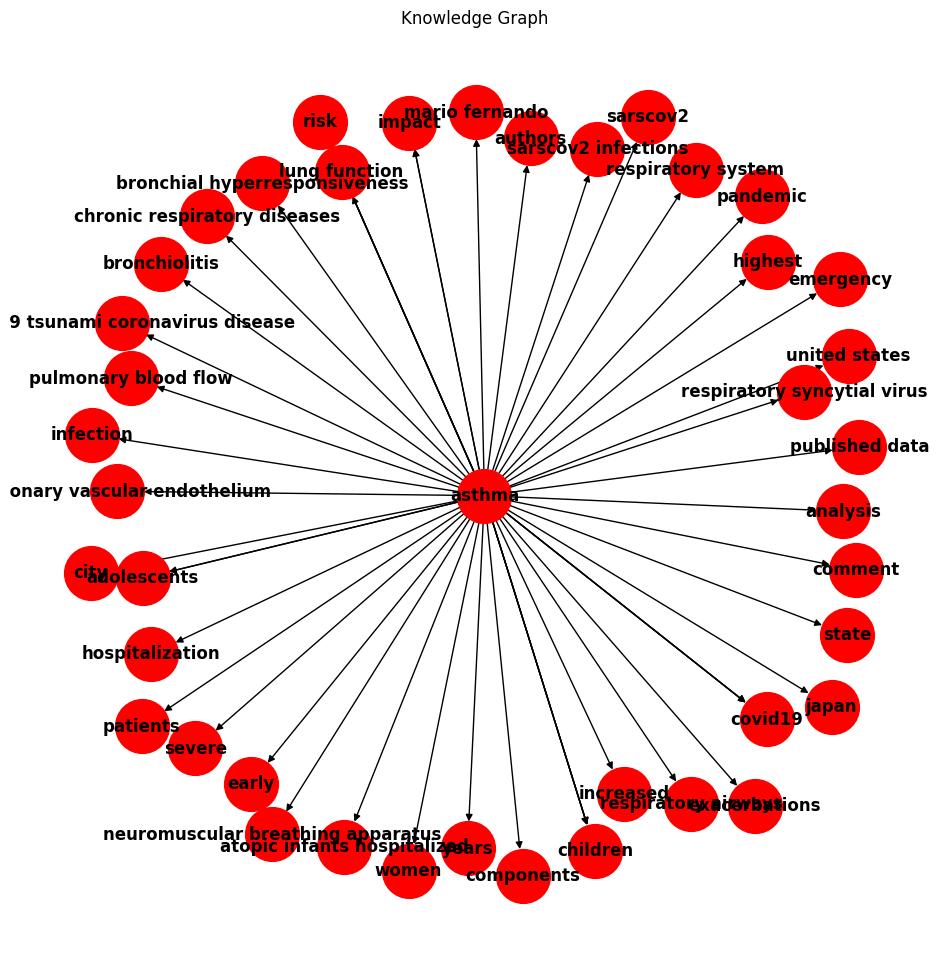

<br><br><font color='blue'><b><u>Summary:</u></b> </br><font color='purple'>Whether asthma constitutes a risk factor for COVID-19 is unclear. In the first search, eight systematic reviews were found, of which five were done in pediatric populations; none of the 67 primary studies included data on pediatric asthma as a comorbidity for COVID-19. An interactive real-time COVID-19 reporting system set up by the Center for Systemic Science and Engineering at Johns Hopkins University (3) shows, as of the time of this writing, more than 5.8 million confirmed cases and over 361,000 deaths worldwide (led by the U.S., with ~30% of all cases and ~28% of all deaths). DUHS serves as the main health care provider in Durham County, North Carolina, with an estimated 85% of Durham residents receiving care within DUHS. In comparison, in the United States of America, a country severely impacted by COVID-19, this number was less than 2 deaths/ million. Analyzing SIVEP-Gripe data, 13 our group found 14,638 cases of pediatric COVID-19 The outbreak of the coronavirus disease 2019 , caused by the novel severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2), has become an evolving global health crisis. In addition to these factors, changes in laboratory indices and pro-inflammatory cytokines, as well as possible complications, could indicate the progression of COVID-19 into a severe and critical stage. Within the last three years, the following companies 23 provided financial support for study activities at the Coordinating and Clinical Centers beyond the 24 third year of patient follow-up for the SARP network: AstraZeneca, Boehringer-Ingelheim, 25Genentech, GlaxoSmithKline, Sanofi-Genzyme-Regeneron, and TEVA. Post-acute COVID-19 syndrome or long-52 haul COVID does not appear to be more prevalent in the asthma population, a multi-disciplinary 53 approach to care is a reasonable option.</font></br><br><center><font color=purple><H1>Best Match Results</H1></font></center><br> Rank: 1<br><font color=red>Confidence score(Higher score is the better): 0.9147514486454474</font><br><font color=green> Title: Asthma and COVID-19 in children -a systematic review and call for data</font> <br>URL: https://doi.org/10.1002/ppul.24909; https://www.ncbi.nlm.nih.gov/pubmed/32558360/<br><font color=red> Article No : </font>bc354f2e1d3d52337f9e9b3b8927ad4378205875<br><font color=:orange>Context: </font><font color=blue> and call for data whether <font color=red>asthma</font> constitutes a risk factor... we aimed to assess whether <font color=red>asthma</font> the most common chronic... studies included data on pediatric <font color=red>asthma</font> as a comorbidity for... pubmed of which five reported <font color=red>asthma</font> in adults but none... constitutes a risk factor for <font color=red>covid19</font> is unclear here we... children is associated with higher <font color=red>covid19</font> risk or severity in... systematic reviews of sarscov2 and <font color=red>covid19</font> in pediatric populations and... searched pubmed for studies on <font color=red>covid19</font> or sarscov2 and asthmawheeze...  <font color=red>children</font> a systematic review and... most common chronic disease in <font color=red>children</font> is associated with higher... but none included data on <font color=red>children</font> in the third search... on asthma but none on <font color=red>children</font> we found one report...</font><br></br> Rank: 2<br><font color=red>Confidence score(Higher score is the better): 0.9095034277400496</font><br><font color=green> Title: Asthma and the Risk of SARS-CoV-2 Infection Among Children and Adolescents</font> <br>URL: http://medrxiv.org/cgi/content/short/2021.07.20.21260871v1?rss=1<br><font color=red> Article No : </font>90e42e9586d744cc2e01a7decb6afb0958f22f2a<br><font color=:orange>Context: </font><font color=blue> to evaluate the association between <font color=red>asthma</font> and the risk of... the duke exposure diagnosis of <font color=red>asthma</font> main outcomes and measures... 2020 we matched children with <font color=red>asthma</font> 11 to children without... asthma 11 to children without <font color=red>asthma</font> using propensity scores and... adolescents in the united states <font color=red>risk</font> factors for sarscov2 infection... association between asthma and the <font color=red>risk</font> of sarscov2 infection among... association between asthma and the <font color=red>risk</font> of sarscov2 infection we... was associated with a decreased <font color=red>risk</font> of sarscov2 infection risk... asthma and the risk of <font color=red>sarscov2</font> infection among children and... importance more than 4 million <font color=red>sarscov2</font> infections have occurred among... united states risk factors for <font color=red>sarscov2</font> infection among children remain... asthma and the risk of <font color=red>sarscov2</font> infection among children design...</font><br></br> Rank: 3<br><font color=red>Confidence score(Higher score is the better): 0.901482914868462</font><br><font color=green> Title: An update on the epidemiology of pediatric COVID-19 in Brazil</font> <br>URL: https://www.ncbi.nlm.nih.gov/pubmed/35442272/; https://doi.org/10.1590/1984-0462/2022/40/2021367<br><font color=red> Article No : </font>6ec1e92d50aeb7e334d3ce6484f8fa6b84f3c767<br><font color=:orange>Context: </font><font color=blue>  <font color=red>epidemiology</font> of pediatric covid19 in... update on the epidemiology of <font color=red>pediatric</font> covid19 in brazil the... in brazil the burden of <font color=red>pediatric</font> covid19 populations is wide... that approximately 40 of laboratoryconfirmed <font color=red>pediatric</font> covid19 survivors reported at... covid19 we also identified that <font color=red>pediatric</font> covid19 patients had a...</font><br></br> Rank: 4<br><font color=red>Confidence score(Higher score is the better): 0.8282545602682222</font><br><font color=green> Title: Risk and Protective Factors for COVID-19 Morbidity, Severity, and Mortality</font> <br>URL: https://doi.org/10.1007/s12016-022-08921-5; https://www.ncbi.nlm.nih.gov/pubmed/35044620/<br><font color=red> Article No : </font>27d1cbe5ed5953444302d718d5c8e49423f904ff<br><font color=:orange>Context: </font><font color=blue> crisis currently a number of <font color=red>risk</font> factors have been identified... similar to adults the main <font color=red>risk</font> factors in pediatric patients... supporting the rationale for the <font color=red>risk</font> and protective factors for... regions worldwide prompting questions about <font color=red>risk</font> and protective factors for... atopic conditions may act as <font color=red>protective</font> factors against the infection... rationale for the risk and <font color=red>protective</font> factors for the morbidity... prompting questions about risk and <font color=red>protective</font> factors for covid19with millions... understanding of the risk and <font color=red>protective</font> factors for covid19 will... currently a number of risk <font color=red>factors</font> have been identified to... disparities in addition to these <font color=red>factors</font> changes in laboratory indices... to adults the main risk <font color=red>factors</font> in pediatric patients include... conditions may act as protective <font color=red>factors</font> against the infection of...</font><br></br> Rank: 5<br><font color=red>Confidence score(Higher score is the better): 0.816374542547675</font><br><font color=green> Title: Journal Pre-proof COVID-19 Infections and Asthma</font> <br>URL: https://www.sciencedirect.com/science/article/pii/S2213219821012708?v=s5; https://www.ncbi.nlm.nih.gov/pubmed/34838708/; https://api.elsevier.com/content/article/pii/S2213219821012708; https://doi.org/10.1016/j.jaip.2021.10.072<br><font color=red> Article No : </font>695a4b9ca780371043a81da5d890d6436d8162df<br><font color=:orange>Context: </font><font color=blue> sarscov2 and coronavirus disease 40 <font color=red>covid19</font> has infected over 200... all without clear contraindications 49 <font color=red>covid19</font> specific treatment options are... association with worse outcomes postacute <font color=red>covid19</font> syndrome or long52 haul... with asthma infected with 87 <font color=red>covid19</font> with regards to severity...</font><br></br></br>

Response Time (sec):  10.766359567642212


In [82]:
query = "asthma and COVID-19 in pediatric populations and Is there evidence to suggest that asthma constitutes a risk factor for COVID-19 in children?"
totalreturn = 5
plot_kg = True 
basedon = "subject"

print("---------------------Results------------------------")
print("User query: ", query)
starttime = time.time()
top_paper = testingutility(query, fullarticles, nlp_ner_kw, totalreturn=totalreturn, 
               plot_kg=True, invertedindexkeys = imp_keys_doc_path, wholedf = data_df, 
                   dataversion = data_df_v2, 
                urldata = docurl, knowledgegraph = df_kg, 
                   wordembeddings = model_clinical,
                   basedon = "subject", extractpaper=True, summary=True)
endtime = time.time()
print("Response Time (sec): ", endtime-starttime)

**<font color="red">TESTING ANALYSIS</font>**


**Summary**

From the above results we can see that our extracted summary is better and has a semantic meaning

* **Response time analysis**

From the above results, we can see that our response time for the query is 7.13 sec. Response time is important factor while searching. Lesser response time is the better. Our results have response duration of 7.13 sec and it is good response time. 


* **Confidence score analysis**

From the above results, we can see that our query is **relation between asthma and COVID-19 in pediatric populations and Is there evidence to suggest that asthma constitutes a risk factor for COVID-19 in children?**. We have retrieved articles with highest confidence score of 0.91 followed by 0.90 and whereas the last confidence score from the retrieved articles is 0.81. These results particulary shows us that we have retrieved good similar articles to the question. 


* **Extracted paper analysis**

From the extracted paper we can first observe that, our extracted papers are very relevant to the query and finding the exact paper is difficult but the papers have extracted based on the user query keywords. Our top ranked paper is **Asthma and COVID-19 in children -a systematic review and call for data** and **Asthma and the Risk of SARS-CoV-2 Infection Among Children and Adolescents**. We can observe that papers are relevant and has good contecxtual meaning and our context snippet has releavnt keywords from the user query. 

* **User action**

If the user finds these articles intresting then we have also provided the URL for the corresponding articles where user can view the articles and download them. To verify the articles we have also provided title and article number. If the title is missing, we can use URL or article number to verify. 

**Sam: Test question**

---------------------Results------------------------
User query:  How can I protect myself and others from getting COVID-19


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.88it/s]
C:\anaconda3\envs\nlp_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


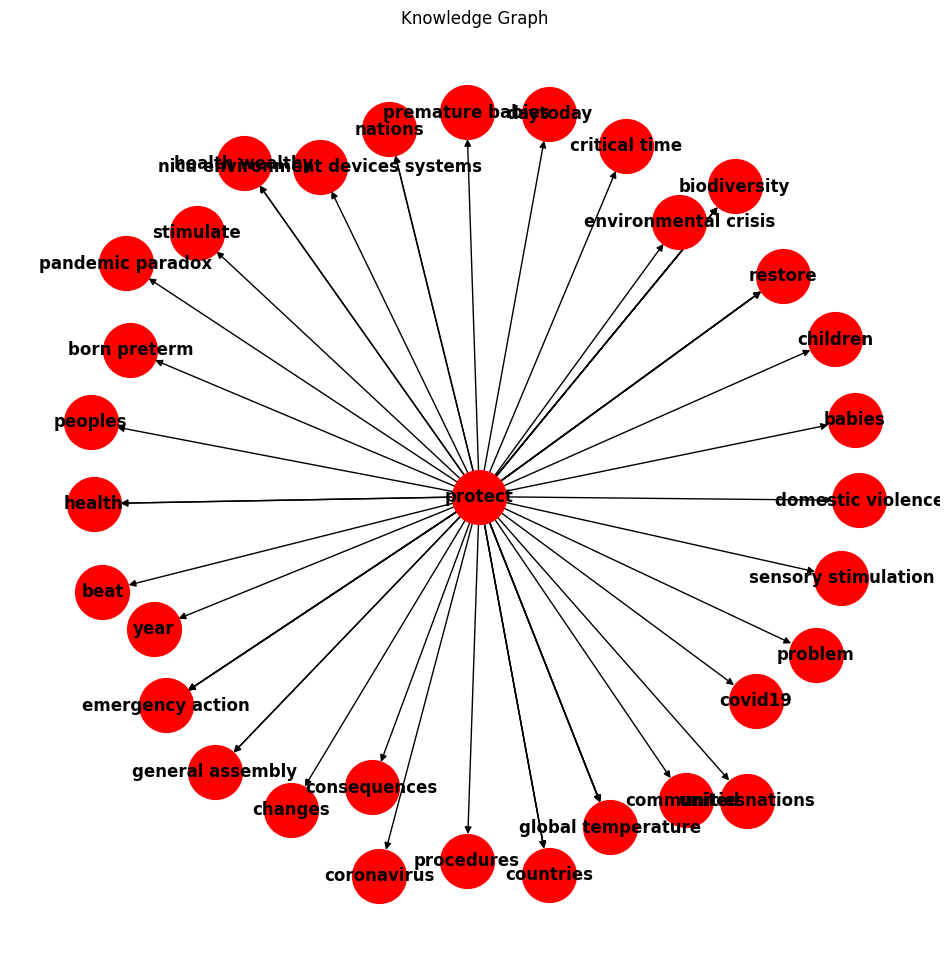

<br><br><font color='blue'><b><u>Summary:</u></b> </br><font color='purple'>Drawing from both the qualitative free-text responses and quantitative responses to an international survey of 1657 chaplains serving during the SARS-Cov-19 pandemic, we explore chaplains' emotional responses to the pandemic and how emotion connects to self-care. Which modes of self-care did you engage in? Chaplains wrote of the lack of time or means for appropriate self-care during the pandemic in their responses to open-ended questions. In this paper we explore the emotional world of chaplains during the pandemic and discuss the results from quantitative questions related to self-care modes and practices. It is understandable anyway, especially knowing that this viral infection has not been with us for too long, hardly a year, yet it has caused untold suffering, loss, pain, and long-term disabilities to many. After about an hour, I considered a COVID-19 PCR test for the child and the mother. About four days later, I developed persistent headache unresponsive to paracetamol and flu-like symptoms. Reflection can lead to change and new opportunities. Locating the study in the UK is relevant beyond the scope of the lockdowns, moreover, as anxiety and depression levels have been on the rise for young people (16) (17) (18) (19) (20) (21) (22) (23) (24) in the UK since 2017, especially for young women [17] . Examples in the UK include parks, pubs, restaurants and gyms. People experiencing homelessness along with concurrent disorders, such as mental health issues and substance use disorders, are particularly disadvantaged as they face barriers to healthcare services, high rates of hospitalization and discrimination from healthcare providers [7, 8] .Access to high quality end-of-life care (EOLC) is a basic human right [9] .</font></br><br><center><font color=purple><H1>Best Match Results</H1></font></center><br> Rank: 1<br><font color=red>Confidence score(Higher score is the better): 0.6561663521509655</font><br><font color=green> Title: Scared but Powerful: Healthcare Chaplains' Emotional Responses and Self-Care Modes during the SARS-Cov-19 Pandemic</font> <br>URL: https://www.ncbi.nlm.nih.gov/pubmed/33730912/; https://doi.org/10.1177/1542305021993761<br><font color=red> Article No : </font>a7c3adba7cee5c3f71d04f754d657ddd908caf3e<br><font color=:orange>Context: </font><font color=blue> most experienced by chaplains were <font color=red>scared</font> but powerful both of... the emotional world discussed above <font color=red>scared</font> but powerful many chaplains... facilitating selfcare practices for other <font color=red>healthcare</font> providers staff care and...  <font color=red>chaplains</font> emotional responses and selfcare... an international survey of 1657 <font color=red>chaplains</font> serving during the sarscov19... the sarscov19 pandemic we explore <font color=red>chaplains</font> emotional responses to the... modes of selfcare practiced by <font color=red>chaplains</font> including modes reported as...</font><br></br> Rank: 2<br><font color=red>Confidence score(Higher score is the better): 0.6495484477679482</font><br><font color=green> Title: My covid-19 experience: picking up the pieces</font> <br>URL: https://www.ncbi.nlm.nih.gov/pubmed/34394212/; https://doi.org/10.4314/ahs.v20i4.4<br><font color=red> Article No : </font>0abb0deb51f4e2da6e356e4d63cc2176a54718b2<br><font color=:orange>Context: </font><font color=blue> with the associated illness as <font color=red>covid19</font> as i write this... 2020 a total of 62729958 <font color=red>covid19</font> cases worldwide have been... people question the existence of <font color=red>covid19</font> both as a disease... who has suffered from the <font color=red>covid19</font> infection it is understandable... covid19 experience picking up the <font color=red>pieces</font> around december 2019 an... pieces around december 2019 an <font color=red>increasing</font> number of pneumonia cases...</font><br></br> Rank: 3<br><font color=red>Confidence score(Higher score is the better): 0.6412425180914594</font><br><font color=green> Title: nan</font> <br>URL: https://doi.org/10.1016/j.jht.2021.12.001; https://www.sciencedirect.com/science/article/pii/S0894113021001836; https://api.elsevier.com/content/article/pii/S0894113021001836<br><font color=red> Article No : </font>d99c877970d042782cb00eb1a0d390a9f75f1e54<br><font color=:orange>Context: </font><font color=blue> past year the definition of <font color=red>unprecedented</font> is never done or... times we have heard that <font color=red>phrase</font> so often during this... so often during this past <font color=red>year</font> the definition of unprecedented... never encountered before this past <font color=red>year</font> the american society of... the first time and this <font color=red>year</font> in person attendance is... to you in the past <font color=red>year</font> i am truly sorry...</font><br></br> Rank: 4<br><font color=red>Confidence score(Higher score is the better): 0.6325989653214097</font><br><font color=green> Title: 'It's Easily the Lowest I've Ever, Ever Got to': A Qualitative Study of Young Adults' Social Isolation during the COVID-19 Lockdowns in the UK</font> <br>URL: https://doi.org/10.3390/ijerph182211777; https://www.ncbi.nlm.nih.gov/pubmed/34831533/<br><font color=red> Article No : </font>94ace40035a3b608d36c9a4a02b30a8b31b36b14<br><font color=:orange>Context: </font><font color=blue> ever ever got to a <font color=red>qualitative</font> study of young adults... during the covid19 lockdowns the <font color=red>qualitative</font> nature of the study... themes emerging from the fifteen <font color=red>qualitative</font> interviews briefly summarisedto counter... ever got to a qualitative <font color=red>study</font> of young adults social... inaccessible during the pandemic this <font color=red>study</font> consequently investigates the social... the nhs 4 conclusions this <font color=red>study</font> highlights the extent of... groups 15 16 locating the <font color=red>study</font> in the uk is... to a qualitative study of <font color=red>young</font> adults social isolation during... social connectivity is key to <font color=red>young</font> peoples mental health local... investigates the social isolation of <font color=red>young</font> adults and their use... digital assets were key to <font color=red>young</font> peoples social connectivity but...</font><br></br> Rank: 5<br><font color=red>Confidence score(Higher score is the better): 0.6293682311086393</font><br><font color=green> Title: A first voice perspective of people experiencing homelessness on preferences for the end-of-life and end-of-life care during the COVID-19 pandemic</font> <br>URL: https://www.ncbi.nlm.nih.gov/pubmed/35428317/; https://doi.org/10.1186/s13104-022-06025-z<br><font color=red> Article No : </font>71e88e3774fbe70a5edf9d3e6c13bfbb4785e74a<br><font color=:orange>Context: </font><font color=blue> have been conducted from the <font color=red>perspective</font> of people experiencing homelessness... eol and eolc from the <font color=red>perspective</font> of people experiencing homelessness... a first voice perspective of <font color=red>people</font> experiencing homelessness on preferences... during the covid19 pandemic objective <font color=red>people</font> experiencing homelessness often encounter... eol and endoflife care for <font color=red>people</font> experiencing homelessness utilizing an... and social justice needs of <font color=red>people</font> experiencing homelessness by ensuring... voice perspective of people experiencing <font color=red>homelessness</font> on preferences for the... covid19 pandemic objective people experiencing <font color=red>homelessness</font> often encounter progressive illnesses... endoflife care for people experiencing <font color=red>homelessness</font> utilizing an interpretive phenomenology... current or previous experience of <font color=red>homelessness</font> and a diagnosis of...</font><br></br></br>

Response Time (sec):  9.120764017105103


In [77]:
query = "How can I protect myself and others from getting COVID-19"
totalreturn = 5 
basedon = "subject"

print("---------------------Results------------------------")
print("User query: ", query)
starttime = time.time()
top_paper = testingutility(query, fullarticles, nlp_ner_kw, totalreturn=totalreturn, 
               plot_kg=True, invertedindexkeys = imp_keys_doc_path, wholedf = data_df, 
                   dataversion = data_df_v2, 
                urldata = docurl, knowledgegraph = df_kg, 
                   wordembeddings = model_clinical,
                   basedon = "subject", extractpaper=True, summary=True)
endtime = time.time()
print("Response Time (sec): ", endtime-starttime)

**<font color="red">TESTING ANALYSIS</font>**


**Summary**

From the above results we can see that our extracted summary is better and has a semantic meaning

* **Response time analysis**

From the above results, we can see that our response time for the query is 9.12 sec. Response time is important factor while searching. Lesser response time is the better. Our results have response duration of 7.13 sec and it is good response time. 


* **Confidence score analysis**

From the above results, we can see that our query is **How can I protect myself and others from getting COVID-19**. We have retrieved articles with highest confidence score of 0.65 followed by 0.64 and whereas the last confidence score from the retrieved articles is 0.62. These results particulary shows us that we have retrieved good similar articles to the question. 


* **Extracted paper analysis**

From the extracted paper we can first observe that, our extracted papers are very relevant to the query and finding the exact paper is difficult but the papers have extracted based on the user query keywords. Our top ranked paper is **How can I protect myself and others from getting COVID-19**. We can observe that papers are relevant and has good contecxtual meaning and our context snippet has releavnt keywords from the user query. 

* **User action**

If the user finds these articles intresting then we have also provided the URL for the corresponding articles where user can view the articles and download them. To verify the articles we have also provided title and article number. If the title is missing, we can use URL or article number to verify. 

**Thamindu test question**

---------------------Results------------------------
User query:  effect of covid19 on diabetes patients


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.37it/s]
C:\anaconda3\envs\nlp_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


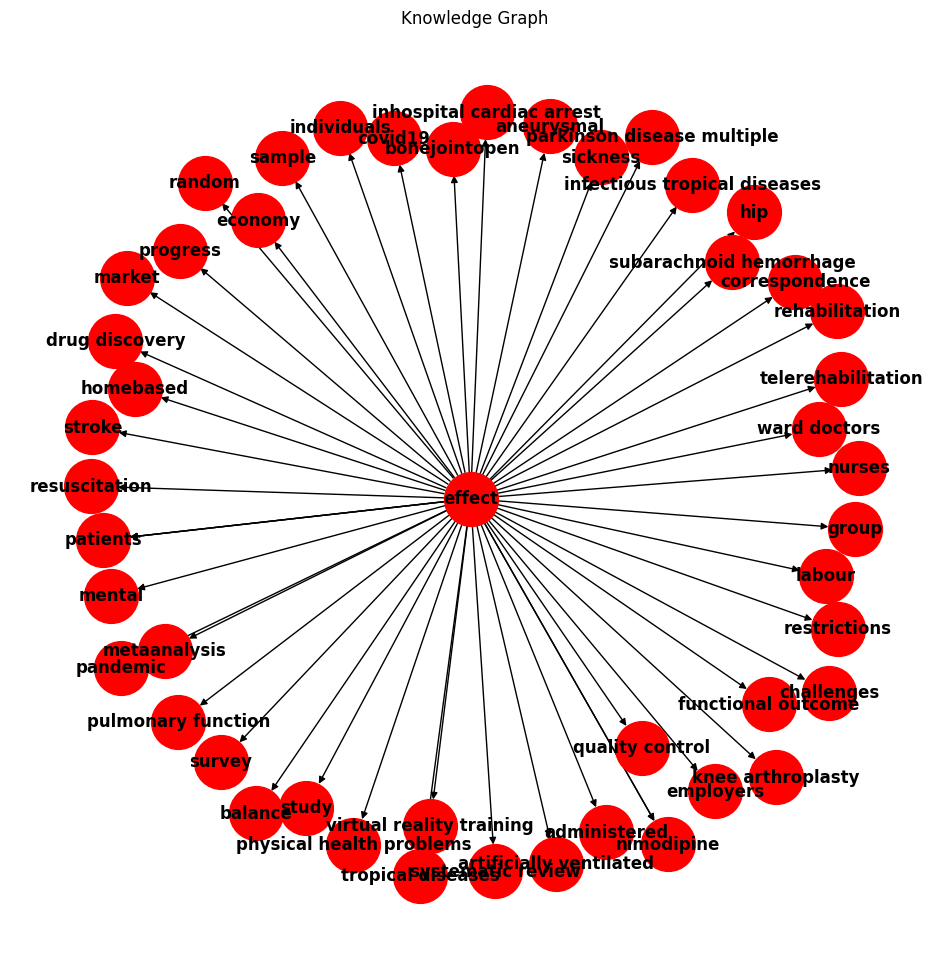

<br><br><font color='blue'><b><u>Summary:</u></b> </br><font color='purple'>Impact of obesity, fasting plasma glucose level, blood pressure, and renal function on the severity of COVID-19: a matter of sexual dimorphism?, An FPG ≥126 mg/dL was associated with poor outcomes in women (aOR, 2.06; 95% CI, 1.13-3.77) but not in men. 3, 4] Although these conditions are frequently associated with disease severity and fatality in other infectious diseases, their degree of association with severe COVID-19 remains unclear. The impact of baseline health condition on the disease course is difficult to evaluate using medical records, as the information on premorbid status recorded in admission records and epidemiological reports are often inaccurate or incomplete unless they are collected prospectively on purpose. The relationships were examined between CKD stage, laboratory parameters and mortality. All the patients enrolled in this study were Purpose of Review To summarize current knowledge of the impact of coronavirus disease 19 (COVID-19) on patients with systemic lupus erythematosus (SLE).Recent Findings Several observational studies, including case series, patient surveys, and patient registries, have examined the incidence and severity of COVID-19 in patients with SLE. 5 However, as many as 20% of patients may develop severe or critical disease resulting in requirement of oxygen support and hospital care or even admission to ICU to prevent and handle feared complications such as acute respiratory distress syndrome, sepsis, thromboembolism and even multiorgan failure. Hence, a systematic appraisal of the study quality of the available systematic reviews on the association between obesity and risk of severe a COVID-19 outcome and a discussion of their conclusions is needed. We evaluated the remaining studies for final inclusion in accordance with the inclusion criteria by full-text reading. The analysis was repeated including URI and bronchitis only and also for serious respiratory infections only.</font></br><br><center><font color=purple><H1>Best Match Results</H1></font></center><br> Rank: 1<br><font color=red>Confidence score(Higher score is the better): 0.8525845436705166</font><br><font color=green> Title: Journal Pre-proofs Impact of obesity, fasting plasma glucose level, blood pressure, and renal function on the severity of COVID-19: a matter of sexual dimorphism? Impact of obesity, fasting plasma glucose level, blood pressure, and renal function on the severity of COVID-19: a matter of sexual dimorphism?</font> <br>URL: https://doi.org/10.1016/j.diabres.2020.108515; https://www.sciencedirect.com/science/article/pii/S0168822720307725?v=s5; https://www.ncbi.nlm.nih.gov/pubmed/33096185/; https://api.elsevier.com/content/article/pii/S0168822720307725<br><font color=red> Article No : </font>962b634d80fd2e4ba0e474f7003486f89e37c7ed<br><font color=:orange>Context: </font><font color=blue> a matter of sexual dimorphism <font color=red>impact</font> of obesity fasting plasma... a matter of sexual dimorphism <font color=red>impact</font> of obesity fasting plasma... with severe covid19 remains unclearthe <font color=red>impact</font> of baseline health condition... before covid19 onsetto mitigate the <font color=red>impact</font> of confounders we constructed...</font><br></br> Rank: 2<br><font color=red>Confidence score(Higher score is the better): 0.8505648444229079</font><br><font color=green> Title: Chronic kidney disease predicts poor outcomes of COVID-19 patients</font> <br>URL: https://www.ncbi.nlm.nih.gov/pubmed/33394281/; https://doi.org/10.1007/s11255-020-02758-7<br><font color=red> Article No : </font>20506e91bdb2e80572ba3abc7871f9b64ec032d5<br><font color=:orange>Context: </font><font color=blue> explore the potential association between <font color=red>chronic</font> kidney disease ckd and... rate was calculated using the <font color=red>chronic</font> kidney disease epidemiology collaboration... that covid19 in people with <font color=red>chronic</font> comorbidities can more easily... observed more in those with <font color=red>chronic</font> kidney disease the current... the potential association between chronic <font color=red>kidney</font> disease ckd and the... diabetes mellitus p 0001 acute <font color=red>kidney</font> injury aki which was... defined as the presence of <font color=red>kidney</font> damage or decreased kidney... of kidney damage or decreased <font color=red>kidney</font> function for ≥ 3... potential association between chronic kidney <font color=red>disease</font> ckd and the severity... since the outbreak of coronavirus <font color=red>disease</font> 2019 covid 19 in... 19 in december 2019 the <font color=red>disease</font> has spread rapidly across... with several comorbidities including cardiovascular <font color=red>disease</font> and advanced age 5...</font><br></br> Rank: 3<br><font color=red>Confidence score(Higher score is the better): 0.8233238368818452</font><br><font color=green> Title: SARS-CoV-2 and Systemic Lupus Erythematosus</font> <br>URL: https://www.ncbi.nlm.nih.gov/pubmed/33511495/; https://doi.org/10.1007/s11926-020-00973-w<br><font color=red> Article No : </font>cd796ff26113b5059f4748a669f6cc96b14d2459<br><font color=:orange>Context: </font><font color=blue> comorbidities the complex interplay between <font color=red>sarscov2</font> and the host immunologic... the risk for infection with <font color=red>sarscov2</font> however more comprehensive studies... at increased risk for contracting <font color=red>sarscov2</font> and a more severe... through the respiratory tract 6 <font color=red>sarscov2</font> enters cells by binding... 19 covid19 on patients with <font color=red>systemic</font> lupus erythematosus slerecent findings... more comprehensive studies are needed <font color=red>systemic</font> lupus erythematosus sle is... clinical disease mainly manifests with <font color=red>systemic</font> and respiratory symptoms that... that limits viral replication and <font color=red>systemic</font> immune activation both the... covid19 on patients with systemic <font color=red>lupus</font> erythematosus slerecent findings several... comprehensive studies are needed systemic <font color=red>lupus</font> erythematosus sle is a... scaffold of sle and on <font color=red>lupus</font> disease activity nonetheless remains... suspected covid19 from the columbia <font color=red>lupus</font> cohort 7 were hospitalized...</font><br></br> Rank: 4<br><font color=red>Confidence score(Higher score is the better): 0.8176449666263803</font><br><font color=green> Title: Obesity augments the disease burden in COVID-19: Updated data from an umbrella review</font> <br>URL: https://doi.org/10.1111/cob.12508; https://www.ncbi.nlm.nih.gov/pubmed/35137524/<br><font color=red> Article No : </font>583d763fc37d343afcc6d5e02dcf383de1f8b414<br><font color=:orange>Context: </font><font color=blue> billion individuals experience overweight or <font color=red>obesity</font> 650 million with obesity... or obesity 650 million with <font color=red>obesity</font> 7 it is important... of in younger individuals with <font color=red>obesity</font> might be augmentedthis ubiquitous... explore the possible link between <font color=red>obesity</font> and covid19 severity it... mild or moderate course of <font color=red>disease</font> consisting of fever cough... may develop severe or critical <font color=red>disease</font> resulting in requirement of... or acute respiratory distress 5 <font color=red>disease</font> outcome 3 the included... analysis on the association between <font color=red>disease</font> progression and age 23...</font><br></br> Rank: 5<br><font color=red>Confidence score(Higher score is the better): 0.8093149458823967</font><br><font color=green> Title: Hydroxychloroquine and the risk of respiratory infections among RA patients</font> <br>URL: https://doi.org/10.1136/rmdopen-2020-001389; https://www.ncbi.nlm.nih.gov/pubmed/33161375/<br><font color=red> Article No : </font>e4f96be07bd24b27a6dcb2c5a84a2319d33eac2a<br><font color=:orange>Context: </font><font color=blue> to determine the effect of <font color=red>hydroxychloroquine</font> on the incidence of... benefit of either chloroquine or <font color=red>hydroxychloroquine</font> hcq in protecting from... divided into two cohorts the <font color=red>hydroxychloroquine</font> hcq cohort and csdmard... in patients with ra the <font color=red>risk</font> for respiratory infections was... using hcq have a lower <font color=red>risk</font> of such infections understanding... such infections understanding the baseline <font color=red>risk</font> of respiratory infections in... corrona registry to evaluate the <font color=red>risk</font> of respiratory infections among... hydroxychloroquine and the risk of <font color=red>respiratory</font> infections among ra patients... on the incidence of new <font color=red>respiratory</font> infections in a large... reviewed physicianreported infections including upper <font color=red>respiratory</font> infections uri bronchitis and... only and also for serious <font color=red>respiratory</font> infections only results no...</font><br></br></br>

Response Time (sec):  9.778346300125122


In [33]:
query = "effect of covid19 on diabetes patients"
totalreturn = 5
plot_kg = False 
basedon = "subject"

print("---------------------Results------------------------")
print("User query: ", query)
starttime = time.time()
top_paper = testingutility(query, fullarticles, nlp_ner_kw, totalreturn=totalreturn, 
               plot_kg=True, invertedindexkeys = imp_keys_doc_path, wholedf = data_df, 
                   dataversion = data_df_v2, 
                urldata = docurl, knowledgegraph = df_kg, 
                   wordembeddings = model_clinical,
                   basedon = "subject", extractpaper=True, summary=True)
endtime = time.time()
print("Response Time (sec): ", endtime-starttime)

**<font color="red">TESTING ANALYSIS</font>**


Summary

From the above results we can see that our extracted summary is better and has a semantic meaning


* **Response time analysis**

From the above results, we can see that our response time for the query is 8.6 sec. Response time is important factor while searching. Lesser response time is the better. Our results have response duration of 8.6 sec and it is good response time. 


* **Confidence score analysis**

From the above results, we can see that our query is **effect of covid19 on diabetes patients**. We have retrieved articles with highest confidence score of 0.8525 followed by 0.850 and whereas the last confidence score from the retrieved articles is 0.80. These results particulary shows us that we have retrieved good similar articles to the question.  

* **Extracted paper analysis**

From the extracted paper we can first observe that, our extracted papers are very relevant to the query and finding the exact paper is difficult but the papers have extracted based on the user query keywords. Our top ranked paper is **Journal Pre-proofs Impact of obesity, fasting plasma glucose level, blood pressure, and renal function on the severity of COVID-19: a matter of sexual dimorphism?** and **Chronic kidney disease predicts poor outcomes of COVID-19 patients**. We can observe that papers are relevant and has good contecxtual meaning and our context snippet has releavnt keywords from the user query. 

* **User action**

If the user finds these articles intresting then we have also provided the URL for the corresponding articles where user can view the articles and download them. To verify the articles we have also provided title and article number. If the title is missing, we can use URL or article number to verify. 

**Melroy test question**

---------------------Results------------------------
User query:  importance of immunity foods during covid19


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.05it/s]
C:\anaconda3\envs\nlp_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


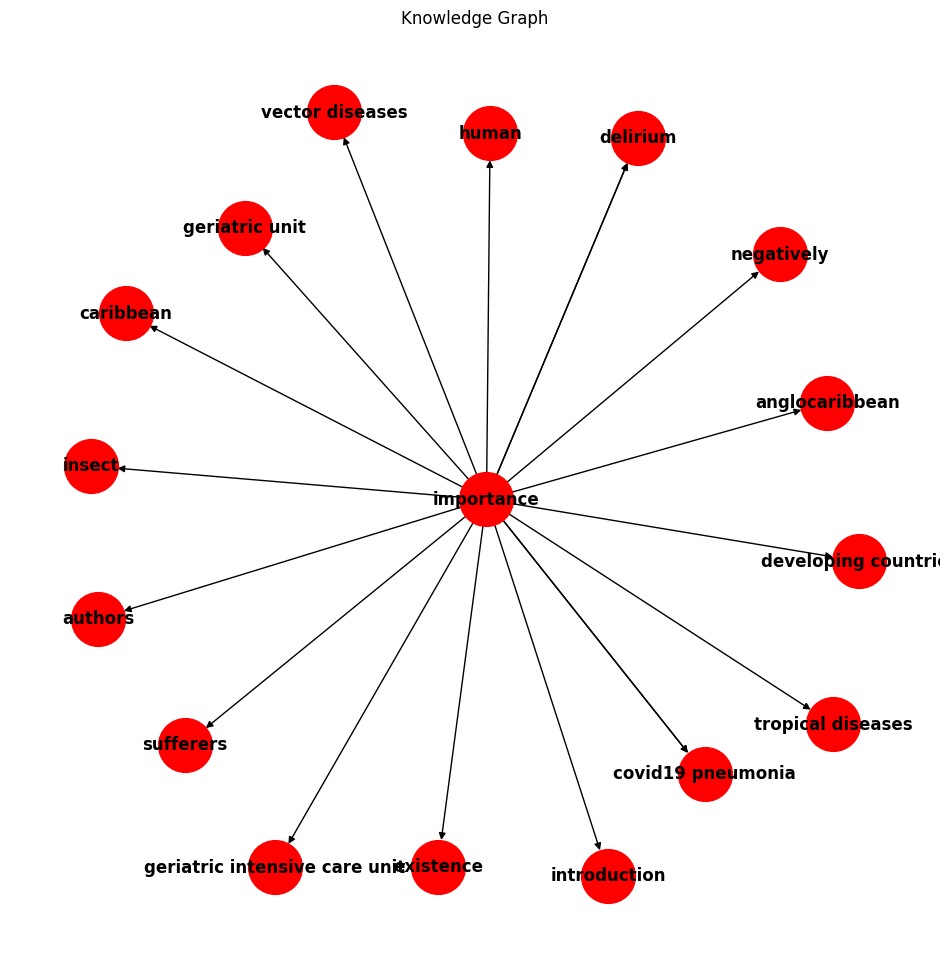

<br><br><font color='blue'><b><u>Summary:</u></b> </br><font color='purple'>1) Background: The COVID-19 pandemic and the imposition of strict but necessary measures to prevent the spread of the new coronavirus have been, and still are, major stress factors for adults, children, and adolescents. The antioxidant activity proved to be considerably higher than the control sample. A healthy diet, compliance with safety conditions and finding appropriate and safe methods to increase the body's immunity is a good alternative to a major transition through harder times, such as pandemics. In 2019, Romania exported food and animals worth 4.77 billion euros, while imports were over 6.7 billion euros, according to data from the National Institute of Statistics. Antioxidant activity is another benefit of volatile oils. In adults with good innate cellular and humoral immunity propagation of virus can be limited and viral load reaching alveoli can be reduced thus recovery can take place within 2-3 weeks with mild symptoms [3] .Humoral immunity prevents the viruses to enter new cells while cell-mediated immunity targets on eradicating virus-infected cells [15, 1] . causing damage to multiple organs known as Cytokine storm [16, 17] . Furthermore, some publications in Saudi Arabia were encouraging consuming the concoction of camel urine and lime as a proactive measure against COVID-19.In some areas, people were advised to inhale steam from boiled herbal concoction. Additionally, in high-fat-fed animal experimental models, researchers described dysregulated ACE2 expression as increasing the risk of COVID-19 infection (7) .Lockdowns may worsen not only the weight but also the eating habits of children, since homes are likely stocked with ultra-processed and calorie-dense comfort foods (8) .</font></br><br><center><font color=purple><H1>Best Match Results</H1></font></center><br> Rank: 1<br><font color=red>Confidence score(Higher score is the better): 0.7515769806980586</font><br><font color=green> Title: Use of Yoghurt Enhanced with Volatile Plant Oils Encapsulated in Sodium Alginate to Increase the Human Body's Immunity in the Present Fight Against Stress</font> <br>URL: https://www.ncbi.nlm.nih.gov/pubmed/33086508/; https://doi.org/10.3390/ijerph17207588<br><font color=red> Article No : </font>7507862810acc51265fb57f2b5e7a563de0a952b<br><font color=:orange>Context: </font><font color=blue> paper is to create a <font color=red>yoghurt</font> with high antioxidant capacity... to enrich the cow milk <font color=red>yoghurt</font> were extracted as volatile... the antioxidant activity of the <font color=red>yoghurt</font> was determined the 22diphenyl1picrylhydrazyl... results show that cow milk <font color=red>yoghurt</font> enhanced with volatile oils... show that cow milk yoghurt <font color=red>enhanced</font> with volatile oils of... use of yoghurt enhanced with <font color=red>volatile</font> plant oils encapsulated in... according to various recent studies <font color=red>volatile</font> oils from various aromatic... milk yoghurt were extracted as <font color=red>volatile</font> oils out of four... cow milk yoghurt enhanced with <font color=red>volatile</font> oils of basil lavender...</font><br></br> Rank: 2<br><font color=red>Confidence score(Higher score is the better): 0.7226313754240308</font><br><font color=green> Title: Journal Pre-proof Immunity Against COVID-19: Potential Role of Ayush Kwath Manuscript Title: Immunity Against COVID-19: Potential Role of Ayush Kwath Immunity Against COVID-19: Potential Role of Ayush Kwath</font> <br>URL: https://api.elsevier.com/content/article/pii/S0975947620300668; https://www.ncbi.nlm.nih.gov/pubmed/32837101/; https://doi.org/10.1016/j.jaim.2020.08.003; https://www.sciencedirect.com/science/article/pii/S0975947620300668?v=s5<br><font color=red> Article No : </font>103781d2bc53b7512afd7a25bb092317b59c99b1<br><font color=:orange>Context: </font><font color=blue> of ayush kwath manuscript title <font color=red>immunity</font> against covid19 potential role... potential role of ayush kwath <font color=red>immunity</font> against covid19 potential role... ayush kwath to improve the <font color=red>immunity</font> and combat the infection... to review the role of <font color=red>immunity</font> in pathogenesis of covid19...</font><br></br> Rank: 3<br><font color=red>Confidence score(Higher score is the better): 0.7159006876487051</font><br><font color=green> Title: Promotion of unproved and potential dangerous measures in fighting COVID-19 pandemic: urgent need for vigilant appropriate public communication and generation of scientific evidence Promotion of unproved and potential dangerous measures in fighting COVID-19 pandemic: urgent need for vigilant appropriate public communication and generation of scientific evidence</font> <br>URL: https://www.ncbi.nlm.nih.gov/pubmed/33456653/; https://doi.org/10.11604/pamj.supp.2020.37.29.25547<br><font color=red> Article No : </font>fb15862058631dce7796696fa105a1a78bcc4edf<br><font color=:orange>Context: </font><font color=blue> and generation of scientific evidence <font color=red>promotion</font> of unproved and potential...  <font color=red>potential</font> dangerous measures in fighting... evidence promotion of unproved and <font color=red>potential</font> dangerous measures in fighting... of unproved and potential dangerous <font color=red>measures</font> in fighting covid19 pandemic... of unproved and potential dangerous <font color=red>measures</font> in fighting covid19 pandemic... disease some of the promoted <font color=red>measures</font> are not only associated... to failure to follow appropriate <font color=red>measures</font> it is crucial to...</font><br></br> Rank: 4<br><font color=red>Confidence score(Higher score is the better): 0.7124242732887269</font><br><font color=green> Title: Special Attention to Diet and Physical Activity in Children and Adolescents With Obesity During the Coronavirus Disease-2019 Pandemic</font> <br>URL: https://www.ncbi.nlm.nih.gov/pubmed/32676491/; https://doi.org/10.3389/fped.2020.00407<br><font color=red> Article No : </font>095db70e90d355ff2d774e18b0d5e076389e1630<br><font color=:orange>Context: </font><font color=blue> dietary supplements maintaining a healthy <font color=red>diet</font> is an important part... overall healthfrontiers in pediatrics wwwfrontiersinorg <font color=red>diet</font> and nutrition play an... infectionskeeping children on a healthy <font color=red>diet</font> in a safe home... and also to have funhealthy <font color=red>diet</font> and behaviors such as... special attention to diet and <font color=red>physical</font> activity in children and... routine of children including regular <font color=red>physical</font> activity and excercise this... social lockdown as is promoting <font color=red>physical</font> activity table 1 children... physically active to protect their <font color=red>physical</font> and emotional health during... attention to diet and physical <font color=red>activity</font> in children and adolescents... of children including regular physical <font color=red>activity</font> and excercise this increased... lockdown as is promoting physical <font color=red>activity</font> table 1 children need... growth 10 in particular physical <font color=red>activity</font> pa contributes to daily...</font><br></br> Rank: 5<br><font color=red>Confidence score(Higher score is the better): 0.699483586990441</font><br><font color=green> Title: nan</font> <br>URL: https://doi.org/10.3892/mmr.2020.11127; https://www.ncbi.nlm.nih.gov/pubmed/32377709/<br><font color=red> Article No : </font>0a6ce864e9696cf6bc21a64bb8b1abda99d4744a<br><font color=:orange>Context: </font><font color=blue> the mortality risk of the <font color=red>sarscov2</font> patients 2 the center... an increased genetic similarity between <font color=red>sarscov2</font> determining covid19 sarscov 80... in icu patients infected with <font color=red>sarscov2</font> the expression of specific... but also glomerulonephritis asthma and <font color=red>pandemic</font> h1n1 influenza virus 94... current sarscov2 pandemic challenges the <font color=red>health</font> systems across the world... those in a prerequisite unbalanced <font color=red>health</font> conditionobesity is one of... comorbidities 1516 have become major <font color=red>health</font> problems in hospitalized patients... well as immune interplaythe world <font color=red>health</font> organization who has characterized...</font><br></br></br>

Response Time (sec):  9.845085620880127


In [84]:
query = "importance of immunity foods during covid19"
totalreturn = 5
plot_kg = False 
basedon = "subject"

print("---------------------Results------------------------")
print("User query: ", query)
starttime = time.time()
top_paper = testingutility(query, fullarticles, nlp_ner_kw, totalreturn=totalreturn, 
               plot_kg=True, invertedindexkeys = imp_keys_doc_path, wholedf = data_df, 
                   dataversion = data_df_v2, 
                urldata = docurl, knowledgegraph = df_kg, 
                   wordembeddings = model_clinical,
                   basedon = "subject", extractpaper=True, summary=True)
endtime = time.time()
print("Response Time (sec): ", endtime-starttime)

**<font color="red">TESTING ANALYSIS</font>**

**Summary**

From the above analysis we can see that our summary has good semantic meaning

* **Response time analysis**

From the above results, we can see that our response time for the query is 6.8 sec. Response time is important factor while searching. Lesser response time is the better. Our results have response duration of 6.8 sec and it is good response time. 


* **Confidence score analysis**

From the above results, we can see that our query is **importance of immunity foods during covid19**. We have retrieved articles with highest confidence score of 0.775 followed by 0.72 and whereas the last confidence score from the retrieved articles is 0.54. These results particulary shows us that we have retrieved good similar articles to the question.  

* **Extracted paper analysis**

From the extracted paper we can first observe that, our extracted papers are very relevant to the query and finding the exact paper is difficult but the papers have extracted based on the user query keywords. Our top ranked paper is **Use of Yoghurt Enhanced with Volatile Plant Oils Encapsulated in Sodium Alginate to Increase the Human Body's Immunity in the Present Fight Against Stress** and **Journal Pre-proof Immunity Against COVID-19: Potential Role of Ayush Kwath Manuscript Title: Immunity Against COVID-19: Potential Role of Ayush Kwath Immunity Against COVID-19: Potential Role of Ayush Kwath**. We can observe that papers are relevant and has good contecxtual meaning and our context snippet has releavnt keywords from the user query. 

* **User action**

If the user finds these articles intresting then we have also provided the URL for the corresponding articles where user can view the articles and download them. To verify the articles we have also provided title and article number. If the title is missing, we can use URL or article number to verify. 

In [32]:
from IPython.display import display, Markdown, Latex

## <font color="purple">5. TEST UTILITY ANALYSIS</font>


In this section, we are evaluating the results of our testing utility function. In this evaluation measure, we have used Mean reciprocal rank (MRR) metric and Mean average precision (MAP) to calculate the efficiency of our question answering recommendation system. 

**We have used the question framing from the kaggle/target_tables and from the dataset. Following are our 10 questions:**

1. impact of COVID-19 on people with substance use disorder (SUD) in Austria

2. methods used by the expert panel to develop nursing surge capacity strategies for management of critically ill adults with COVID-19 in intensive care units

3. Bayesian method used for estimating the seroprevalence of SARS-CoV-2 antibodies in the worldwide population

4. significance of thromboembolic events in COVID-19 patients
5. stability of SARS-CoV-2 IgG in different laboratory temperature conditions and blood sample types
6. benefits and limitations of using unidimensional and multidimensional instruments for assessing psychological responses to COVID-19 and how have the psychometric properties of the FCV-19S been evaluated
7. impact of COVID-19 on energy prices, and how does it vary across different energy sources and time frames
8. relationship between COVID-19 and liver injury, and how was this relationship studied in the systematic review and meta-analysis
9. effect of face masks on voice production during the COVID-19 pandemic
10. relation between asthma and COVID-19 in pediatric populations and Is there evidence to suggest that asthma constitutes a risk factor for COVID-19 in children?


We have used above complex questions because, we needed to test if our system is able to rerieve the articles faster with good contextual articles. By Testing the system with compelx question we obtain the trust from the system that it can give the good results and we can trust it. 

**Scoring metrics**

**In this evaluation we have used Mean reciprocal rank (MRR) and Mean average precision (MAP) scores.**

MRR scores are in the range of 0 to 1 and scores greater than 0.0 indicates that system is able to retrieve the correct articles. However, having MRR greater than 0.5 indicates that 50% of the articles are correctly predicted and MRR score greater than 0.8 indicates that best system. 

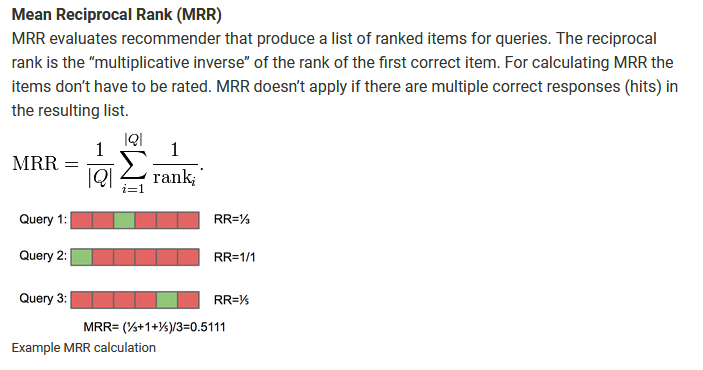

(Reference: https://www.blabladata.com/2014/10/26/evaluating-recommender-systems/)

From the above figure we can see that we obtain the ranking of our correct artilces after ranking and we use the mean method to get the inverse ranking. If our correct article is at the top 1 rank then RR= 1 and similary if our all the articles are correctly predicted at top 1 then, we have MRR = 1.0 which is a perfect score. If our articles are not present in the top ranked articles then, our MRR scores are very close to 0.0 which is a bad score.

MAP scores are in the range of 0 to 1 and scores greater than 0 indicates that system is able to retrieve the articles however, scores greater than 0.5 indicates that we have 50% of correct articles. MAP score = 1 is the best score.

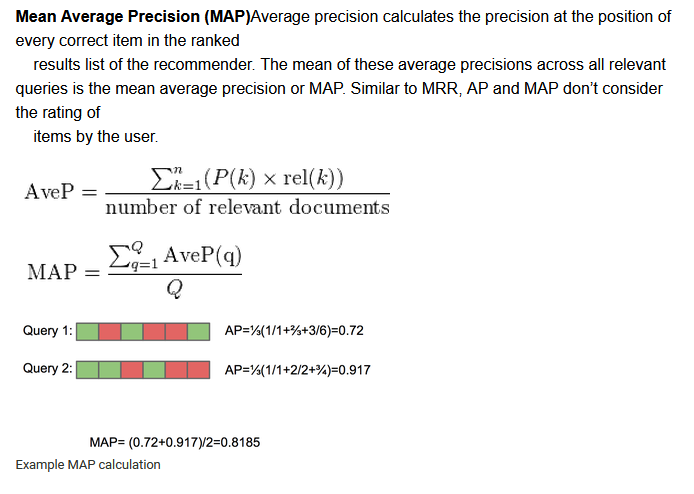

**Since, we are using each query at a time, the scores from MRR and MAP is similar.**


**Steps to solve**

* Step 1: Load the question and answer dataframe 
* Step 2: Pass all the question and answer to the MRR function
* Step 3: Analyse the MRR results 

In [85]:
# Load the question and answer dataframe

qna = pd.read_csv("QnA.csv")
qna 

PaperID  \
0  689a550c62653f70dad65d0b438c3a8bbc23aedd   
1  3150f31687f2775f3515ee8def82557e05b06f06   
2  80e3b987da656dbd065c081da61c94f2b54eb619   
3  4eb0f78e44d8fce971534174b28dbc184718eeca   
4  364e83693a41ab3ee9f8dab6a2fccf7cfaa5f036   
5  8d250234a63f000016e5e3e735d2e78e85b1bb00   
6  b48c9508d537e82172758c2d9660148602fc1b03   
7  268cf63d2bd687dadb3e341e230d13e487ea957f   
8  0edaa2a7b948e6ec677008bffd87ebb24ba99f11   
9  bc354f2e1d3d52337f9e9b3b8927ad4378205875   

                                            Question  
0  impact of COVID-19 on people with substance us...  
1  methods used by the expert panel to develop nu...  
2  Bayesian method used for estimating the seropr...  
3  significance of thromboembolic events in COVID...  
4  stability of SARS-CoV-2 IgG in different labor...  
5  benefits and limitations of using unidimension...  
6  impact of COVID-19 on energy prices, and how d...  
7  relationship between COVID-19 and liver injury...  
8  effect of face masks on voice production durin...  
9  relation between asthma and COVID-19 in pediat...

In [86]:
# Convering the dataframe into list format 

questions = list(qna["Question"])
answers = list(qna["PaperID"])

In [87]:
def mrrmetric(quest, answer, articles, nermodel, imp_keys_doc_path,
             data_df_v2, docurl, df_kg, model_clinical):
    
    '''This function calculates the MRR metric from the given question and 
    answer
    
                Input arguments: 

                quest: question 
                answer: answer list 
                articles: cleaned data 
                nermodel: NER entity model 
                imp_keys_doc_path: inverted index keys 
                data_df_v2: cleaned dataframe 
                docurl: document URL
                df_kg: Knowledge graph dataframe 
                model_clinical: Word embedidngs by word2vec
    
    '''
    
    # reciprocal ranks
    rr_rank = []
    
    # looping each question and answer and checking its rank
    for q, a in zip(quest, answer): 
        
        # we use testing utility function to obtain the top 10 articles
        top10_token = testingutility(q, articles, nermodel, plot_kg=False,
                                     totalreturn=10,
                                    invertedindexkeys = imp_keys_doc_path,
                                    dataversion = data_df_v2,
                                    urldata = docurl, knowledgegraph = df_kg,
                                    wordembeddings = model_clinical,
                                    extractpaper=False)
        
        # we extract the document ID of extarcted top papers
        docid_ls_x = list(top10_token["docID"])
        
        # we loop paper ids to get the paperid
        articlepaperids = []

        for dix in docid_ls_x:

            article_extract = data_df_v2.iloc[int(dix[3:])]
            articlepaperids.append(article_extract["PaperId"])
            
        # if answer paper id is in articles paper ids we rank.
        if a in articlepaperids:
            rr_rank.append(1/(articlepaperids.index(a)+1))
        else:
            rr_rank.append(0.0)
            
    return np.mean(rr_rank)

In [88]:
# MRR metric
mrr_ = mrrmetric(questions, answers, fullarticles, nlp_ner_kw, imp_keys_doc_path,
         data_df_v2, docurl, df_kg, model_clinical)

# Display MRR metric
print("MRR metric: ", mrr_)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.80it/s]
C:\anaconda3\envs\nlp_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.01it/s]
C:\anaconda3\envs\nlp_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.13it/s]
C:\anaconda3\envs\nlp_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the

MRR metric:  0.85


**<font color="red">Conclusion: MRR metric analysis</font>**

From the above analysis, we can see that we have obtained 0.85 MRR metric. We suggests that our system is able to fetch 85% correct articles. 

Though our questions were complex, we were able to retrieve them correctly. Therefore in order to make more robust system we should have good inverted index keys and tfidf keywords and our word embedidngs should be availble from the domain specific. 

Therefore, by using above approach we can still obtain better results.

## <font color="purple">6. SUMMARIZATION MODEL ANALYSIS</font>

In [91]:
query = "impact of COVID-19 on energy prices, and how does it vary across different energy sources and time frames"
totalreturn = 5
plot_kg = False 
extractpaper = False
basedon = "subject"
print("User query: ", query)
top_paper = testingutility(query, fullarticles, nlp_ner_kw, totalreturn=totalreturn, 
               plot_kg=False, invertedindexkeys = imp_keys_doc_path, wholedf = data_df, 
                   dataversion = data_df_v2, 
                urldata = docurl, knowledgegraph = df_kg, 
                   wordembeddings = model_clinical,
                   basedon = "subject", extractpaper=False, summary=False)

art_id = [int(x[3:]) for x in top_paper["docID"]]
summary_top5 = summarizetop5(art_id, data_df, data_df_v2)
html_summary = "<br>"+"<font color='blue'>"+"<b><u>Summary:</u></b> </br>"+"<font color='purple'>"+summary_top5+"</font>"
Markdown(html_summary)

User query:  impact of COVID-19 on energy prices, and how does it vary across different energy sources and time frames


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.16it/s]
C:\anaconda3\envs\nlp_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<br><font color='blue'><b><u>Summary:</u></b> </br><font color='purple'>The energy market is extremely vulnerable to the uncertainty caused by the pandemic and leads to global lockdowns and stagnant economic activity. However, the impact of the COVID-19 is greater on the oil prices (OPs) as compared to the natural gas (NGP) and the heating oil price (HOP). It explores that global energy consumption has increased rapidly in the last three decades, driven by robust economic growth (Azadeh and Tarverdian, 2007; Aydin, 2015a) . /home/eae NARDL model that allows to capture long-term asymmetric reactions. 6 The COVID-19 pandemic troubled global supply and demand chains, 7 but its influence is different for various kinds of commodities, as opposed to the 2008-09 global recession when nearly all commodity prices encountered great and lasting drops. "However, accelerated storage conditions should also be taken into consideration not only when establishing expiration dating, but also to factor in distribution and end-user times and conditions, as they provide insightful information into the maintenance of molecular conformation, biological activity, and understanding of degradation pathways. The increase in environmental concerns has led to the intensification of technical innovations to reduce energy consumption (creating high-efficiency equipment) and to produce green energy, which are accompanied by financial and social innovations, but also by changing consumer attitudes and behavior towards various categories of renewable energy [9] [10] [11] [12] . Changing the structure of the economy can be a solution by transitioning from more energy-intensive industries to less energy-intensive sectors. Firstly, as the sources of MSW play an essential role in the means of subsequent valorization, the factors affecting the generation of MSW and its prediction methods are introduced.</font>

In [92]:
query = "effect of face masks on voice production during the COVID-19 pandemic"
totalreturn = 5
plot_kg = False 
extractpaper = False
basedon = "subject"
print("User query: ", query)
top_paper = testingutility(query, fullarticles, nlp_ner_kw, totalreturn=totalreturn, 
               plot_kg=False, invertedindexkeys = imp_keys_doc_path, wholedf = data_df, 
                   dataversion = data_df_v2, 
                urldata = docurl, knowledgegraph = df_kg, 
                   wordembeddings = model_clinical,
                   basedon = "subject", extractpaper=False, summary=False)

art_id = [int(x[3:]) for x in top_paper["docID"]]
summary_top5 = summarizetop5(art_id, data_df, data_df_v2)
html_summary = "<br>"+"<font color='blue'>"+"<b><u>Summary:</u></b> </br>"+"<font color='purple'>"+summary_top5+"</font>"
Markdown(html_summary)

User query:  effect of face masks on voice production during the COVID-19 pandemic


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.62it/s]
C:\anaconda3\envs\nlp_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<br><font color='blue'><b><u>Summary:</u></b> </br><font color='purple'>The Coronavirus Disease 2019 is an ongoing global pandemic and wearing face mask is recommended across the globe to break the transmission chain of infection. KN95 (Chinese standard) mask consists of 4 layers-outermost and innermost layer of spun-bond polypropylene, along with two layers made respectively of melt-blown polypropylene filter material, and cotton fibers, in the middle [3] . These findings have theoretical and practical implications. 2020) , whereas a study based in Beijing, China, exploring transmission in families with at least one laboratory confirmed COVID-19 case found that "face mask use by the primary case and family contacts before the primary case developed symptoms was 79% effective in reducing transmission" ).Yet, since wearing a face covering represents a significant change in people's habitual behaviour, we might expect that people would be reluctant to wear one. We quantify the response of contact rates, reported cases and transmission of COVID-19, to public health contact-restriction orders, and examine the associations among these three variables in the province of British Columbia, Canada. For instance, from the unchangeable features of others' face we can acquire information concerning their age, gender, and, more in general, identity (Haxby et al., Past research on whether hyperchoice deteriorates decision experience is mixed. A total of 116 older adults and 112 younger adults were recruited from Amazon Mechanical Turk. Dependent variables were post-choice difficulty and satisfaction. However, as reviewed below, past research on the effect of hyperchoice on decision experience was not consistent.</font>

In [93]:
query = "relationship between COVID-19 and liver injury, and how was this relationship studied in the systematic review and meta-analysis"
totalreturn = 5
plot_kg = False 
extractpaper = False
basedon = "subject"
print("User query: ", query)
top_paper = testingutility(query, fullarticles, nlp_ner_kw, totalreturn=totalreturn, 
               plot_kg=False, invertedindexkeys = imp_keys_doc_path, wholedf = data_df, 
                   dataversion = data_df_v2, 
                urldata = docurl, knowledgegraph = df_kg, 
                   wordembeddings = model_clinical,
                   basedon = "subject", extractpaper=False, summary=False)

art_id = [int(x[3:]) for x in top_paper["docID"]]
summary_top5 = summarizetop5(art_id, data_df, data_df_v2)
html_summary = "<br>"+"<font color='blue'>"+"<b><u>Summary:</u></b> </br>"+"<font color='purple'>"+summary_top5+"</font>"
Markdown(html_summary)

User query:  relationship between COVID-19 and liver injury, and how was this relationship studied in the systematic review and meta-analysis


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]
C:\anaconda3\envs\nlp_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<br><font color='blue'><b><u>Summary:</u></b> </br><font color='purple'>e relationship between liver fibrosis scores and clinical outcomes in patients with COVID-19 is not compressively assessed. Regarding other liver scores, one unit elevation in APRI increased the risk of death by 178% (RR: 2.78, 95% CI: 1.10-6.99, P � 0.03). Independent extraction of the data was done by two independent authors. Abnormal liver tests may be associated with the virus or the drug therapy. In addition, these tests may be normal in patients who have advanced liver disease; in COVID, we stated that liver enzymes are abnormal and we discussed that in the "Discussion" section. Our goal is to systematically review current data through laboratory tests and liver tissue pathology to confirm the correlation of liver involvement in SARS-CoV-2 infection patients and detect the prognosis relationship with COVID-19 patients. We performed a systematic review of the literature and meta-analysis to determine differences in serum lipid levels, such as TC, LDL-C, HDL-C, and TG, between patients with COVID-19 and healthy controls, and to assess the association of these lipid levels at admission with severity and mortality among patients with COVID-19.The systematic review was performed following the PRISMA guidelines (15) . The complete search strategy is described in the supplementary document (Appendix Section I). Authors VC and MM reviewed the study designs of the selected studies. Finally, 119 full texts were screened and 51 studies were excluded for being outside the topic of interest.</font>

In [94]:
query = "Can I get COVID-19 more than once?"
totalreturn = 5
plot_kg = False 
extractpaper = False
basedon = "subject"
print("User query: ", query)
top_paper = testingutility(query, fullarticles, nlp_ner_kw, totalreturn=totalreturn, 
               plot_kg=False, invertedindexkeys = imp_keys_doc_path, wholedf = data_df, 
                   dataversion = data_df_v2, 
                urldata = docurl, knowledgegraph = df_kg, 
                   wordembeddings = model_clinical,
                   basedon = "subject", extractpaper=False, summary=False)

art_id = [int(x[3:]) for x in top_paper["docID"]]
summary_top5 = summarizetop5(art_id, data_df, data_df_v2)
html_summary = "<br>"+"<font color='blue'>"+"<b><u>Summary:</u></b> </br>"+"<font color='purple'>"+summary_top5+"</font>"
Markdown(html_summary)

User query:  Can I get COVID-19 more than once?


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.59it/s]
C:\anaconda3\envs\nlp_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<br><font color='blue'><b><u>Summary:</u></b> </br><font color='purple'>T h e ne w e ngl a nd jou r na l o f m e dicine S evere acute respiratory syndrome coronavirus 2 (SARS-CoV-2), the virus that causes coronavirus disease 2019 (Covid- 19) , can infect host cells by means of interaction with membrane-bound angiotensin-converting enzyme 2 (ACE2) on respiratory epithelium. The findings indicate gaps in surveillance systems, particularly in low -and middle-income countries and an abundance of information on local and national uses and misuses of antibiotics. National policies should build upon existing structures, responsibilities and practices to manage the supply and prescription of antimicrobials. 2 Projections indicated that a 14-day quarantine period sequesters 99% of individuals who have been exposed and would ultimately develop COVID-19.The CDC guideline on a 14-day quarantine has been adopted globally by most organisations and government agencies. The European CDC (ECDC) published revised quarantine requirements allowing quarantine to be discontinued if the result from a SARS-CoV-2Strengths and limitations of this study ► We developed a novel forward-time simulation approach allowing the modelling of individual There is a need to provide quality education without discrimination or prejudice to all students. Perceived relatedness is supported as students indicated that the anonymous peer review allowed them to learn from their peers. How students and lecturers recognise the differences in terms of demographics (Sadowski, Stewart, & Pediaditis, 2018) . To effectively teach diverse, digitally literate students, the literature indicates the importance of providing feedback to provide improved learning in higher education (Jonsson, 2013) .Additionally, lecturers are working remotely, via electronic learning management systems (eLMS), during the Covid-19 pandemic. Whereas a minuscule amount of time is spent on addressing students ability to display their understanding of the concepts taught. A random number generator was used to select for a convenience sample of 25 UCCs per state. For the 49 centers that provided the wait time for test results, the median time was 120 hours (interquartile range 96 hours to 144 hours).Of UCCs that did not offer testing, 97 (51.3%) referred individuals to other clinics that could possibly test for COVID-19, and 37 (24.8%) directly referred individuals to a specific emergency department.</font>

In [95]:
query = "stability of SARS-CoV-2 IgG in different laboratory temperature conditions and blood sample types"
totalreturn = 5
plot_kg = False 
extractpaper = False
basedon = "subject"
print("User query: ", query)
top_paper = testingutility(query, fullarticles, nlp_ner_kw, totalreturn=totalreturn, 
               plot_kg=False, invertedindexkeys = imp_keys_doc_path, wholedf = data_df, 
                   dataversion = data_df_v2, 
                urldata = docurl, knowledgegraph = df_kg, 
                   wordembeddings = model_clinical,
                   basedon = "subject", extractpaper=False, summary=False)

art_id = [int(x[3:]) for x in top_paper["docID"]]
summary_top5 = summarizetop5(art_id, data_df, data_df_v2)
html_summary = "<br>"+"<font color='blue'>"+"<b><u>Summary:</u></b> </br>"+"<font color='purple'>"+summary_top5+"</font>"
Markdown(html_summary)

User query:  stability of SARS-CoV-2 IgG in different laboratory temperature conditions and blood sample types


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.26it/s]
C:\anaconda3\envs\nlp_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<br><font color='blue'><b><u>Summary:</u></b> </br><font color='purple'>Highlights SARS-CoV-2 IgG in serum, plasma, and heparinized-plasma was consistently detected across a wide array of serological assays when tested daily while put through up to 12 freeze-thaw cycles. RESULTS: All three specimen types were collected from 34 COVID-19 recovered seropositive individuals (≥21 days post-symptoms). IgM detection was variable due to the labile nature of this antibody class. Results: After the first vaccination, the prevalence of IgG directed against the (trimeric) SARS-CoV-2 S-protein and its receptor binding domain (RBD) varied from 55-95% (AZD1222) to 100% (BNT162b2), depending on the vaccine regimen and the SARS-CoV-2 antigen used. The anti-SARS-CoV-2 IgG concentrations and the B.1.1.7-neutralising titres were significantly higher after heterologous vaccination compared to the homologous AZD1222 scheme. We demonstrated here that after immunization of chickens with our recombinant S1 protein, IgY neutralizing antibodies were generated against the SARS-CoV-2 spike protein S1 subunit; therefore, showing the potential use of IgY to block the entry of this virus. Numerous studies have demonstrated SARS-CoV-2 has infected over 160 million people and resulted in more than 3.3 million deaths, and we still face many challenges in the rollout of vaccines. Furthermore, some of these vaccines require ultra-low temperature storage and show only limited stability at 2-8 ˚C (19) , making transport and global distribution challenging, especially to resource limited countries. Additionally, immunization of transgenic mice expressing human angiotensin- 10 converting enzyme 2 (ACE2) with spike protein via HD-MAP delivery and adjuvanted with QS21 provided complete protection from a lethal The outbreak of COVID-19 and its continued spread have seriously threatened public health. Fourth, it is also important for seroepidemiological study for analyzing the infection rate and population immunity rate in different areas (8, 9) .At present, COVID-19 antibodies are detected mainly by enzyme-linked immunosorbent assay (ELISA) (10) and colloidal gold lateral flow immunoassays (LFIAs) (11) .</font>

**<font color="red">Conclusion</font>**

From the above summary and query we can see that our summaries are good and has good sematic meaning. Therefore our selected model for summarization that is SciBert is better. 

## <font color="purple">6. USER PROMPT</font>


**<font color="red">Steps to solve</font>**

In this section, we developed an application for text summarization based retrieved articles. In jupyter notebook, I have made simple python function, where we pass input and we get the desired results. In deployment app, we used **Flask** application to create API and we deployed the flask app locally. 

<br><center><font color="orange"><H3>Flask app demo</H3></font></center></br>

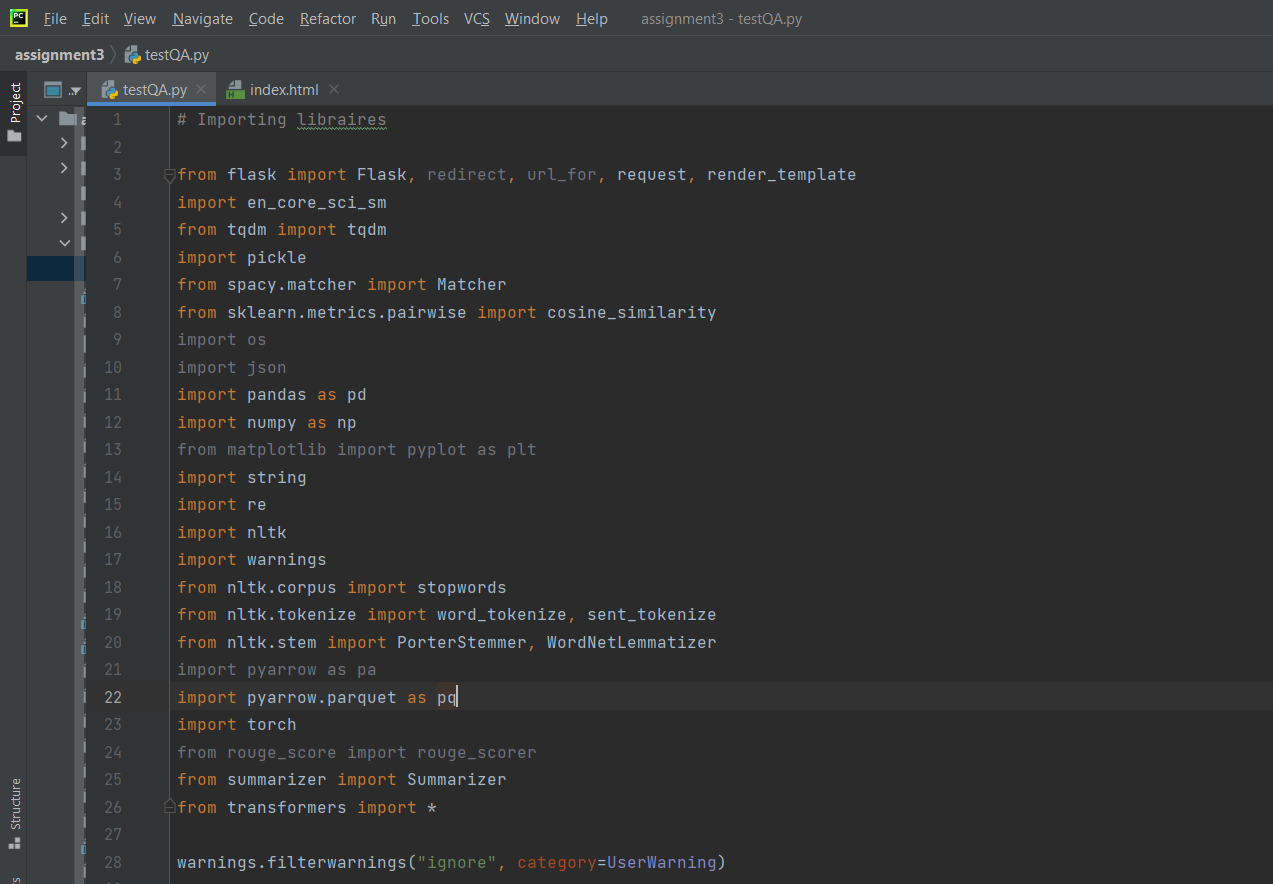

Demo for the **Flask** app is availble in my private youtube video. Please clicke here to view the demo. 

Youtube: https://youtu.be/IpJfCE33r48

**<font color="red">Screenshot of the demo</font>**

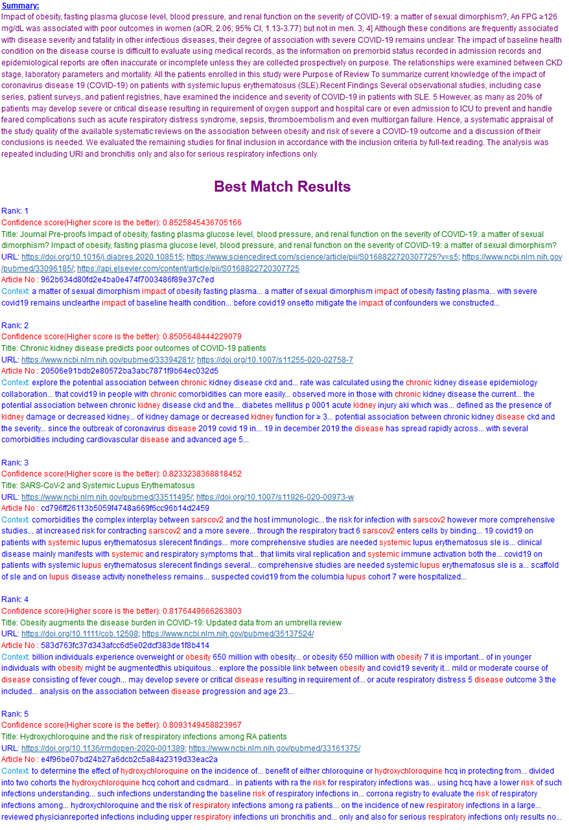


**<font color="red">NOTE: PLEASE VIEW THE DEMO VIDEO BY LANDSCAPE MODE FOR BETTER QUALITY</font>**

<br><center><font color="orange"><H3>Jupyter notebook app demo</H3></font></center></br>
In the jupyter notebook demo app, we have create a python function **testingutility()** it takes various input arguments and returns the knowledge graph plot for the query and the relevant articles corresponding to the query. The ranked articles are ranked using cosine similarity approach. Following are the input arguments: 

* *query*: *Input user query* 
* *articles*: *cleaned articles from the dataset*
* *wholedf*" *whole data*
* *nermodel: NER model*
* *totalreturn: total relevant articles required*
* *plot_kg: If False, no plotting and if True, we plot the knowledge graph*
* *invertedindexkeys: keywords from the inverted index* 
* *dataversion: second cleaned data* 
* *urldata: datasets URL* 
* *knowledgegraph = knowledge graph dataframe* 
* *wordembeddings = word2vec embeddings* 
* *basedon: knowledge graph based on relation/subject or target* 
* *extractpaper: if True, we extract papers, if False, we do not extract paper*


**<font color="purple">Example 1</font>**

------------------Results-----------------------
User query:  reliability of using saliva as a noninvasive alternative to nasopharyngeal swabs for PCR testing of SARS-CoV-2


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.20it/s]
C:\anaconda3\envs\nlp_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


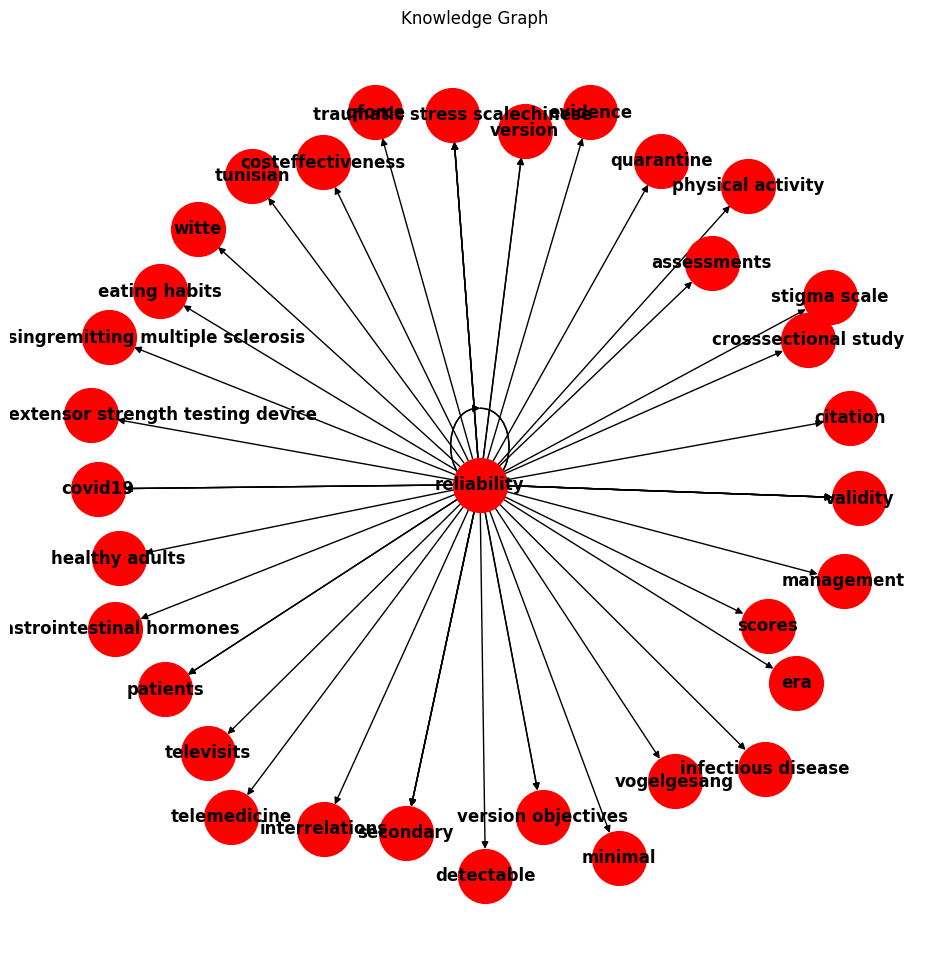

<br><br><font color='blue'><b><u>Summary:</u></b> </br><font color='purple'>Widespread SARS-CoV-2 testing is highly valuable for identifying asymptomatic/presymptomatic individuals to slow community disease transmission. Efforts for more portable nucleic acid-based methods have been recently reported 9 . In comparison to cut-offs defined by SARS-CoV-2-positive samples, internal positive controls, and references from a federal laboratory, 90.85% (923 of 1016) of swabs contained NA concentrations enabling SARS-CoV-2 recognition. The herein of 22This article is protected by copyright. One way to determine the quality of samples and RT-qPCR test results is to quantify a human housekeeping gene as internal references 25, 26 .However, since the availability of PCR test reagents is limited and the number of possible targets is restricted in most diagnostics devices, we aimed for an alternative approach to assess the quality of clinical specimens. The emergency use authorization of most of the commonly used platforms for SARS-CoV-2 testing is approved for nasopharyngeal swab (NPS) specimens. The specimens were collected prospectively in the ED, when a patient with suspected COVID-19 was being investigated, following institutional and national guidelines for testing (2) or randomly in the hospital COVID unit from patients not requiring mechanical ventilation. Características basales de la cohorte (edad/sexo, comorbilidades, medicaciones crónicas) se establecieron a 01/03/2020 y se registraron todos los casos de COVID19-confirmada ocurridos en miembros de la cohorte hasta 30/06/2020. Coronavirus; SARS-COV-2; COVID19; Incidencia; Riesgo. In fact, in individuals with ASD, especially adolescents and young adults, sleep initiation and maintenance are often refractory to standard treatments and can interfere with their ability to function.</font></br><br><center><font color=purple><H1>Best Match Results</H1></font></center><br> Rank: 1<br><font color=red>Confidence score(Higher score is the better): 0.7755664862032876</font><br><font color=green> Title: Ultrasensitive assay for saliva-based SARS-CoV-2 antigen detection</font> <br>URL: https://doi.org/10.1101/2021.02.17.21251863; http://medrxiv.org/cgi/content/short/2021.02.17.21251863v1?rss=1<br><font color=red> Article No : </font>438daf53f9408279e8b1529c5213b21795cd4a73<br><font color=:orange>Context: </font><font color=blue> here we report the first <font color=red>ultrasensitive</font> salivabased sarscov2 antigen assay... here we report the first <font color=red>ultrasensitive</font> salivabased n antigen assay... splex assay we demonstrate the <font color=red>ultrasensitive</font> sarscov2 nucleocapsid n antigen... were obtained with the splex <font color=red>ultrasensitive</font> ecl immunoassay platform meso... first ultrasensitive salivabased sarscov2 antigen <font color=red>assay</font> with an analytical sensitivity... noncovid19 and covid19 patients our <font color=red>assay</font> displayed absolute specificity and... 86 cases for comparison our <font color=red>assay</font> showed high concordance with... specificity of the salivabased splex <font color=red>assay</font> demonstrating its clinical value...  <font color=red>sarscov2</font> antigen detection widespread sarscov2... salivabased sarscov2 antigen detection widespread <font color=red>sarscov2</font> testing is highly valuable... highly reliable easy and quick <font color=red>sarscov2</font> diagnostic tests that are... the widespread use of salivabased <font color=red>sarscov2</font> rapid antigen tests is...</font><br></br> Rank: 2<br><font color=red>Confidence score(Higher score is the better): 0.7256903572393745</font><br><font color=green> Title: Over 90% of clinical swabs used for SARS-CoV-2 diagnostics contain sufficient nucleic acid concentrations</font> <br>URL: https://www.ncbi.nlm.nih.gov/pubmed/33289117/; https://doi.org/10.1002/jmv.26706<br><font color=red> Article No : </font>b7dd89b9c882f9963a013bc3720b3382c1a884f6<br><font color=:orange>Context: </font><font color=blue> we determined na concentrations in <font color=red>clinical</font> samples used for sarscov2... negative for sarscov2 before the <font color=red>clinical</font> manifestation was confirmed by... tested positive 19 given the <font color=red>clinical</font> political and socioeconomic consequences... can use various types of <font color=red>clinical</font> specimens for rtqpcr diagnostics...  <font color=red>swabs</font> used for sarscov2 diagnostics... na derived from oroor nasopharyngeal <font color=red>swabs</font> constitute the current gold... 9085 923 of 1016 of <font color=red>swabs</font> contained na concentrations enabling... na concentrations enabling sarscov2 recognition <font color=red>swabs</font> collected by local health... of clinical swabs used for <font color=red>sarscov2</font> diagnostics contain sufficient nucleic... the covid19 pandemic caused by <font color=red>sarscov2</font> reliable diagnostics are absolutely... diagnostics are absolutely indispensable molecular <font color=red>sarscov2</font> diagnostics based on nucleic... in clinical samples used for <font color=red>sarscov2</font> testing applying an naspecific...</font><br></br> Rank: 3<br><font color=red>Confidence score(Higher score is the better): 0.7023996645588909</font><br><font color=green> Title: Saliva as an Alternate Specimen Source for Detection of SARS- CoV-2 in Symptomatic Patients Using Cepheid Xpert Xpress SARS-CoV-2</font> <br>URL: https://www.ncbi.nlm.nih.gov/pubmed/32414838/; https://doi.org/10.1128/jcm.01109-20<br><font color=red> Article No : </font>8251cf05743ff62f352382471bb9539c71a34443<br><font color=:orange>Context: </font><font color=blue> our institution sought to validate <font color=red>saliva</font> specimens for the diagnosis... franklin lakes nj with unpreserved <font color=red>saliva</font> collected in the emergency... unit was disseminated to encourage <font color=red>saliva</font> not sputum collection also... 30 minutes prior to collection <font color=red>saliva</font> was collected in sterile...  <font color=red>specimen</font> source for detection of... liquid nonviscous components of each <font color=red>specimen</font> were drawn into the... and coaching could selfcollect the <font color=red>specimen</font> these differences could reduce... liquid nonviscous components of each <font color=red>specimen</font> were drawn into the... an alternate specimen source for <font color=red>detection</font> of sars cov2 in... targets e and n2 the <font color=red>detection</font> of both targets or... is considered positive and the <font color=red>detection</font> of e alone is... targets e and n2 the <font color=red>detection</font> of both targets or...</font><br></br> Rank: 4<br><font color=red>Confidence score(Higher score is the better): 0.6904760141201889</font><br><font color=green> Title: nan</font> <br>URL: https://www.ncbi.nlm.nih.gov/pubmed/34074472/; https://www.sciencedirect.com/science/article/pii/S0025775321002402?v=s5; https://api.elsevier.com/content/article/pii/S0025775321002402; https://doi.org/10.1016/j.medcli.2021.03.027<br><font color=red> Article No : </font>11f6a755ff4d3da328207eb97366e8855ff1e838<br><font color=:orange>Context: </font><font color=blue> e p r o o <font color=red>fobjetivo</font> analizar incidencia y riesgosusceptibilidad... p r o o fobjetivo <font color=red>analizar</font> incidencia y riesgosusceptibilidad de... r o o fobjetivo analizar <font color=red>incidencia</font> y riesgosusceptibilidad de sufrir... un área con relativamente baja <font color=red>incidencia</font> de covid19 edad institucionalización... con menor riesgocoronavirus sarscov2 covid19 <font color=red>incidencia</font> riesgothe novel severe acute...</font><br></br> Rank: 5<br><font color=red>Confidence score(Higher score is the better): 0.5487600320278259</font><br><font color=green> Title: Personalized Medicine Transdermal Electrical Neuromodulation for Anxiety and Sleep Problems in High-Functioning Autism Spectrum Disorder: Feasibility and Preliminary Findings</font> <br>URL: https://doi.org/10.3390/jpm11121307; https://www.ncbi.nlm.nih.gov/pubmed/34945779/<br><font color=red> Article No : </font>05f10e076624b7039c393f51a2036f145c8e3b58<br><font color=:orange>Context: </font><font color=blue> medicine transdermal electrical neuromodulation for <font color=red>anxiety</font> and sleep problems in... re transdermal electrical neuromodulation for <font color=red>anxiety</font> and sleep problems in... thus alternative approaches to treat <font color=red>anxiety</font> are needed for children... asd new approaches to managing <font color=red>anxiety</font> and sleep quality could... electrical neuromodulation for anxiety and <font color=red>sleep</font> problems in highfunctioning autism... electrical neuromodulation for anxiety and <font color=red>sleep</font> problems in highfunctioning autism... in children with asd for <font color=red>sleep</font> initiation but not for... sleep initiation but not for <font color=red>sleep</font> maintenance 32 36 good...</font><br></br></br>

Response Time (sec):  10.018661260604858


In [96]:
# Input arguments 
query = "reliability of using saliva as a noninvasive alternative to nasopharyngeal swabs for PCR testing of SARS-CoV-2"
totalreturn = 5
plot_kg = True 
basedon = "subject"

print("------------------Results-----------------------")
print("User query: ", query)

# Application run 
starttime = time.time()
top_paper = testingutility(query, fullarticles, nlp_ner_kw, totalreturn=totalreturn, 
               plot_kg=True, invertedindexkeys = imp_keys_doc_path, wholedf = data_df, 
                   dataversion = data_df_v2, 
                urldata = docurl, knowledgegraph = df_kg, 
                   wordembeddings = model_clinical,
                   basedon = "subject", extractpaper=True, summary=True)
endtime = time.time()
print("Response Time (sec): ", endtime-starttime)

**<font color="red">TESTING ANALYSIS</font>**

* **Response time analysis**

From the above results, we can see that our response time for the query is 7.57 sec. Response time is important factor while searching. Lesser response time is the better. Our results have response duration of 7.57 sec and it is good response time. 


* **Confidence score analysis**

From the above results, we can see that our query is **reliability of using saliva as a noninvasive alternative to nasopharyngeal swabs for PCR testing of SARS-CoV-2**. We have retrieved articles with highest confidence score of 0.775 followed by 0.72 and whereas the last confidence score from the retrieved articles is 0.54. These results particulary shows us that we have retrieved good similar articles to the question. 

* **Knowledge graph analysis**

From the query and output analysis we can observe that, we have obtained good knowledge graph and this graph is based on the word "reliability". Here we can observe that reliability is related to various medical terms but we are focusing on "covid19 articles" and we can observe from below that relaiability is connected to the "covid19 node" and it is also conncected to the "infectious disease node". However, in the begining it is difficult to understand the relation between "reliability", "covid19" and "infectious disease" but it clears according to the question. Because, covid19 is the infectious disease, and nasopharyngeal swabs and saliva test are the reliable testing measure for the covid19. 

* **Extracted paper analysis**

From the extracted paper we can first observe that, our extracted papers are very relevant to the query and finding the exact paper is difficult but the papers have extracted based on the user query keywords. Our top ranked paper is **Ultrasensitive assay for saliva-based SARS-CoV-2 antigen detection** and **Over 90% of clinical swabs used for SARS-CoV-2 diagnostics contain sufficient nucleic acid concentrations**. We can observe that papers are relevant and has good contecxtual meaning and our context snippet has releavnt keywords from the user query. 

* **User action**

If the user finds these articles intresting then we have also provided the URL for the corresponding articles where user can view the articles and download them. To verify the articles we have also provided title and article number. If the title is missing, we can use URL or article number to verify. 

**<font color="purple">Exmaple 2</font>**

------------------Results-----------------------
User query:  effect of face masks on voice production during the COVID-19 pandemic


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]
C:\anaconda3\envs\nlp_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


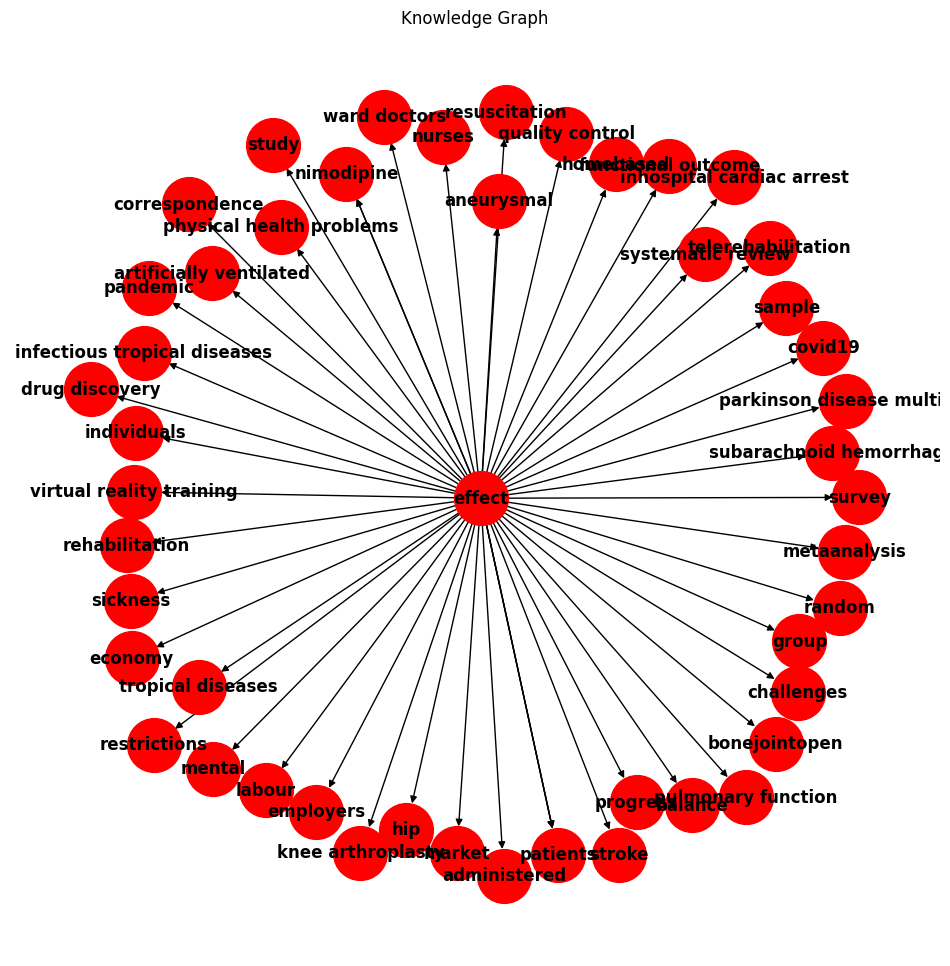

<br><br><font color='blue'><b><u>Summary:</u></b> </br><font color='purple'>The Coronavirus Disease 2019 is an ongoing global pandemic and wearing face mask is recommended across the globe to break the transmission chain of infection. KN95 (Chinese standard) mask consists of 4 layers-outermost and innermost layer of spun-bond polypropylene, along with two layers made respectively of melt-blown polypropylene filter material, and cotton fibers, in the middle [3] . These findings have theoretical and practical implications. 2020) , whereas a study based in Beijing, China, exploring transmission in families with at least one laboratory confirmed COVID-19 case found that "face mask use by the primary case and family contacts before the primary case developed symptoms was 79% effective in reducing transmission" ).Yet, since wearing a face covering represents a significant change in people's habitual behaviour, we might expect that people would be reluctant to wear one. We quantify the response of contact rates, reported cases and transmission of COVID-19, to public health contact-restriction orders, and examine the associations among these three variables in the province of British Columbia, Canada. For instance, from the unchangeable features of others' face we can acquire information concerning their age, gender, and, more in general, identity (Haxby et al., Past research on whether hyperchoice deteriorates decision experience is mixed. A total of 116 older adults and 112 younger adults were recruited from Amazon Mechanical Turk. Dependent variables were post-choice difficulty and satisfaction. However, as reviewed below, past research on the effect of hyperchoice on decision experience was not consistent.</font></br><br><center><font color=purple><H1>Best Match Results</H1></font></center><br> Rank: 1<br><font color=red>Confidence score(Higher score is the better): 0.5422747765338458</font><br><font color=green> Title: Effect of face mask on voice production during COVID-19 pandemic: A systematic review</font> <br>URL: https://doi.org/10.1016/j.jvoice.2021.09.027; https://www.ncbi.nlm.nih.gov/pubmed/34802856/; https://www.sciencedirect.com/science/article/pii/S0892199721003271?v=s5; https://api.elsevier.com/content/article/pii/S0892199721003271<br><font color=red> Article No : </font>0edaa2a7b948e6ec677008bffd87ebb24ba99f11<br><font color=:orange>Context: </font><font color=blue> a systematic review exploring the <font color=red>effect</font> of various masks on... as various professionals regarding the <font color=red>effect</font> of wearing different masks... research study designs were included <font color=red>effect</font> of wearing the mask... lowest level of evidence 17 <font color=red>effect</font> or influence or impact... ongoing global pandemic and wearing <font color=red>face</font> mask is recommended across... the spread of infection 2 <font color=red>face</font> masks are an essential... or influence or impact 2 <font color=red>face</font> mask or face cover... impact 2 face mask or <font color=red>face</font> cover or face guard... global pandemic and wearing face <font color=red>mask</font> is recommended across the... surgical and fabric masks n95 <font color=red>mask</font> us standard usually consists... the middle kn95 chinese standard <font color=red>mask</font> consists of 4 layersoutermost... might be uncomfortable 4 surgical <font color=red>mask</font> medicalprocedure mask approved by...</font><br></br> Rank: 2<br><font color=red>Confidence score(Higher score is the better): 0.5409049711422049</font><br><font color=green> Title: Priming reasoning increases intentions to wear a face covering to slow down COVID-19 transmission</font> <br>URL: https://arxiv.org/pdf/2006.11273v1.pdf<br><font color=red> Article No : </font>3f4aaa9ccc0f6737343da89f4ed26d27ecb9aaba<br><font color=:orange>Context: </font><font color=blue> in the usa showing that <font color=red>priming</font> people to rely on... covering compared to the baseline <font color=red>priming</font> reasoning promotes intentions to... wear a face covering whereas <font color=red>priming</font> emotion has no significant... the following research question does <font color=red>priming</font> people to rely on... rely on their emotions significantly <font color=red>increases</font> their intentions to wear... a threat to their community <font color=red>increases</font> intentions to wear a... to rely on their reasoning <font color=red>increases</font> intentions to wear a... the baseline priming reasoning significantly <font color=red>increases</font> intentions to wear a... their emotions significantly increases their <font color=red>intentions</font> to wear a face... the baseline priming reasoning promotes <font color=red>intentions</font> to wear a face... and scalable intervention to promote <font color=red>intentions</font> to wear a face... on the cognitive basis of <font color=red>intentions</font> to wear a face...</font><br></br> Rank: 3<br><font color=red>Confidence score(Higher score is the better): 0.5372133624385811</font><br><font color=green> Title: Social Contacts and Transmission of COVID-19 in British Columbia, Canada</font> <br>URL: https://www.ncbi.nlm.nih.gov/pubmed/35592086/; https://doi.org/10.3389/fpubh.2022.867425<br><font color=red> Article No : </font>999572781ebb1f5fcaf124721c4c24a4724db2c3<br><font color=:orange>Context: </font><font color=blue> transmission of covid19 from a <font color=red>social</font> contacts survey reported case... and spread based on the <font color=red>social</font> contacts and mixing patterns... examine the relations between selfreported <font color=red>social</font> contact patterns public health... have analyzed population patterns of <font color=red>social</font> contacts and their connection... of covid19 from a social <font color=red>contacts</font> survey reported case counts... to quantify lagged associations between <font color=red>contacts</font> rates daily cases and... spread based on the social <font color=red>contacts</font> and mixing patterns of... population 1 2 3 effective <font color=red>contacts</font> interactions that allow pathogen... a driving force behind the <font color=red>transmission</font> of many infectious respiratory... rates and their relation to <font color=red>transmission</font> and the impact of... contact rates reported cases and <font color=red>transmission</font> of covid19 to public... contact rates daily cases and <font color=red>transmission</font> of covid19 from a...</font><br></br> Rank: 4<br><font color=red>Confidence score(Higher score is the better): 0.5351900685856663</font><br><font color=green> Title: Standard Article i-Perception</font> <br>URL: https://www.ncbi.nlm.nih.gov/pubmed/34925752/; https://doi.org/10.1177/20416695211058480<br><font color=red> Article No : </font>1fde0881bd5803ba66e9e839d0fa3b04fd80462d<br><font color=:orange>Context: </font><font color=blue> interacting with others wearing a <font color=red>face</font> mask has become a... pandemic however the impact of <font color=red>face</font> masks on cognitive mechanisms... which the daily use of <font color=red>face</font> masks before covid19 pandemic... a task irrelevant averted gaze <font color=red>face</font> wearing a mask or... with others wearing a face <font color=red>mask</font> has become a regular... averted gaze face wearing a <font color=red>mask</font> or not acted as... both experiments independent of the <font color=red>mask</font> condition these findings suggest... perceived is wearing a face <font color=red>mask</font> from the covid19 outbreak...</font><br></br> Rank: 5<br><font color=red>Confidence score(Higher score is the better): 0.5270444780935395</font><br><font color=green> Title: Decision experience in hyperchoice: the role of numeracy and age differences</font> <br>URL: https://doi.org/10.1007/s12144-020-01041-3; https://www.ncbi.nlm.nih.gov/pubmed/32952368/<br><font color=red> Article No : </font>128884e963e365b11d51ff16118e85904bf3840f<br><font color=:orange>Context: </font><font color=blue> research on whether hyperchoice deteriorates <font color=red>decision</font> experience is mixed the... hyperchoice was related to greater <font color=red>decision</font> difficulty in both choice... adults older adults reported greater <font color=red>decision</font> difficulty and lower decision... greater decision difficulty and lower <font color=red>decision</font> satisfaction regardless of choice... a special choice condition termed <font color=red>hyperchoice</font> past research on whether... hyperchoice past research on whether <font color=red>hyperchoice</font> deteriorates decision experience is... experience in the scenario of <font color=red>hyperchoice</font> may be moderated by... was manipulated to create a <font color=red>hyperchoice</font> condition sixteen options and... in hyperchoice the role of <font color=red>numeracy</font> and age differences due... moderated by individual characteristics including <font color=red>numeracy</font> and age differences a... turk along with the raschbased <font color=red>numeracy</font> scale each participant completed... there was an interaction between <font color=red>numeracy</font> and hyperchoice in the...</font><br></br></br>

Response Time (sec):  9.627160549163818


In [97]:
# Input arguments 
query = "effect of face masks on voice production during the COVID-19 pandemic"
totalreturn = 5
plot_kg = True 
basedon = "subject"

print("------------------Results-----------------------")
print("User query: ", query)

# Application run 
starttime = time.time()
top_paper = testingutility(query, fullarticles, nlp_ner_kw, totalreturn=totalreturn, 
               plot_kg=True, invertedindexkeys = imp_keys_doc_path, wholedf = data_df, 
                   dataversion = data_df_v2, 
                urldata = docurl, knowledgegraph = df_kg, 
                   wordembeddings = model_clinical,
                   basedon = "subject", extractpaper=True, summary=True)
endtime = time.time()
print("Response Time (sec): ", endtime-starttime)

**<font color="red">TESTING ANALYSIS</font>**

* **Response time analysis**

From the above results, we can see that our response time for the query is 7.79 sec. Response time is important factor while searching. Lesser response time is the better. Our results have response duration of 7.79 sec and it is good response time. 


* **Confidence score analysis**

From the above results, we can see that our query is **effect of face masks on voice production during the COVID-19 pandemic**. We have retrieved articles with highest confidence score of 0.542 followed by 0.540 and whereas the last confidence score from the retrieved articles is 0.52. These results particulary shows us that we have retrieved good similar articles to the question. Since, the confidence scores are very close to each other we can say that these ectracted articles are similar to each other. 

* **Knowledge graph analysis**

From the query and output analysis we can observe that, we have obtained good knowledge graph and this graph is based on the word "effect". Here we can observe that effect is related to various medical terms but we are focusing on "covid19 articles" and we can observe from below that effect is connected to the "covid19 node" and it is also conncected to the "health and nurses". However, in the begining it is difficult to understand the relation between "effect", "covid19" and "health and nurses" but it clears according to the question. Because, covid19 is the infectious disease, and face mask can help in preventing the covid19 which inturn helps the health of the patients and wearing face mask by nurses it also helps them from getting the covid19 from the positive covid19 patients. 

* **Extracted paper analysis**

From the extracted paper we can first observe that, our extracted papers are very relevant to the query and finding the exact paper is difficult but the papers have extracted based on the user query keywords. Our top ranked paper is **Effect of face mask on voice production during COVID-19 pandemic: A systematic review** and **Priming reasoning increases intentions to wear a face covering to slow down COVID-19 transmission**. We can observe that papers are relevant and has good contecxtual meaning and our context snippet has releavnt keywords from the user query. 

* **User action**

If the user finds these articles intresting then we have also provided the URL for the corresponding articles where user can view the articles and download them. To verify the articles we have also provided title and article number. If the title is missing, we can use URL or article number to verify. 

**<font color="purple">Example 3</font>**

------------------Results-----------------------
User query:  relationship between COVID-19 and liver injury, and how was this relationship studied in the systematic review and meta-analysis


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.66it/s]
C:\anaconda3\envs\nlp_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


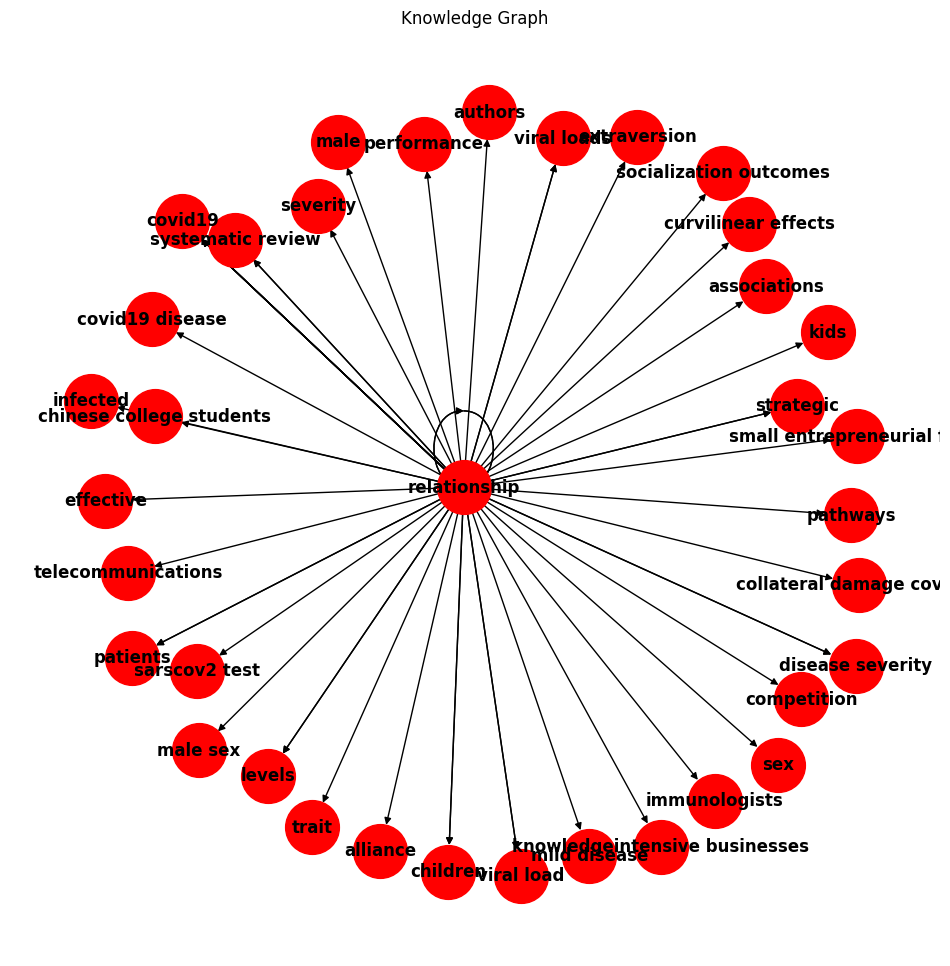

<br><br><font color='blue'><b><u>Summary:</u></b> </br><font color='purple'>e relationship between liver fibrosis scores and clinical outcomes in patients with COVID-19 is not compressively assessed. Regarding other liver scores, one unit elevation in APRI increased the risk of death by 178% (RR: 2.78, 95% CI: 1.10-6.99, P � 0.03). Independent extraction of the data was done by two independent authors. Abnormal liver tests may be associated with the virus or the drug therapy. In addition, these tests may be normal in patients who have advanced liver disease; in COVID, we stated that liver enzymes are abnormal and we discussed that in the "Discussion" section. Our goal is to systematically review current data through laboratory tests and liver tissue pathology to confirm the correlation of liver involvement in SARS-CoV-2 infection patients and detect the prognosis relationship with COVID-19 patients. We performed a systematic review of the literature and meta-analysis to determine differences in serum lipid levels, such as TC, LDL-C, HDL-C, and TG, between patients with COVID-19 and healthy controls, and to assess the association of these lipid levels at admission with severity and mortality among patients with COVID-19.The systematic review was performed following the PRISMA guidelines (15) . The complete search strategy is described in the supplementary document (Appendix Section I). Authors VC and MM reviewed the study designs of the selected studies. Finally, 119 full texts were screened and 51 studies were excluded for being outside the topic of interest.</font></br><br><center><font color=purple><H1>Best Match Results</H1></font></center><br> Rank: 1<br><font color=red>Confidence score(Higher score is the better): 0.6875559010016148</font><br><font color=green> Title: Liver Fibrosis Scores and Hospitalization, Mechanical Ventilation, Severity, and Death in Patients with COVID-19: A Systematic Review and Dose-Response Meta-Analysis</font> <br>URL: https://www.ncbi.nlm.nih.gov/pubmed/35369116/; https://doi.org/10.1155/2022/7235860<br><font color=red> Article No : </font>099ecfe929746e4dda1bfe11ea2394e70168b7e6<br><font color=:orange>Context: </font><font color=blue> and aim e relationship between <font color=red>liver</font> fibrosis scores and clinical... that assessed the relationship between <font color=red>liver</font> fibrosis scores eg fib4... nonlinearity � 018 regarding other <font color=red>liver</font> scores one unit elevation... our doseresponse metaanalysis suggests high <font color=red>liver</font> fibrosis scores are associated... aim e relationship between liver <font color=red>fibrosis</font> scores and clinical outcomes... assessed the relationship between liver <font color=red>fibrosis</font> scores eg fib4 nafld... fibrosis scores eg fib4 nafld <font color=red>fibrosis</font> score nfs and aspartate... doseresponse metaanalysis suggests high liver <font color=red>fibrosis</font> scores are associated with... e relationship between liver fibrosis <font color=red>scores</font> and clinical outcomes in... the relationship between liver fibrosis <font color=red>scores</font> eg fib4 nafld fibrosis... � 018 regarding other liver <font color=red>scores</font> one unit elevation in... metaanalysis suggests high liver fibrosis <font color=red>scores</font> are associated with worse...</font><br></br> Rank: 2<br><font color=red>Confidence score(Higher score is the better): 0.6643563280081533</font><br><font color=green> Title: Liver injury with COVID-19: laboratory and histopathological outcome-systematic review and meta-analysis</font> <br>URL: https://doi.org/10.1186/s43066-022-00171-6; https://www.ncbi.nlm.nih.gov/pubmed/35096428/<br><font color=red> Article No : </font>268cf63d2bd687dadb3e341e230d13e487ea957f<br><font color=:orange>Context: </font><font color=blue> been reported the mechanism of <font color=red>liver</font> injury is poorly understoodthis... data through laboratory tests and <font color=red>liver</font> tissue pathology to ascertain... to ascertain the correlation of <font color=red>liver</font> involvement in sarscov2 infection... that patients with underlying abnormal <font color=red>liver</font> function andor histopathological finding... respiratory distress syndrome but hepatic <font color=red>injury</font> has also been reported... reported the mechanism of liver <font color=red>injury</font> is poorly understoodthis review... the drug therapy the hepatic <font color=red>injury</font> detected in the early... histopathology or covid19 and hepatic <font color=red>injury</font> or hepatic cell failure... times higher odds of severe <font color=red>covid19</font> outcomes when data from... autopsy from cases with severe <font color=red>covid19</font> and in four of... observed that the severity of <font color=red>covid19</font> was associated with more... significant attribute of severe critical <font color=red>covid19</font> 5 abnormal liver tests...</font><br></br> Rank: 3<br><font color=red>Confidence score(Higher score is the better): 0.6628914854482657</font><br><font color=green> Title: Association of Lipid Levels With COVID-19 Infection, Disease Severity and Mortality: A Systematic Review and Meta-Analysis</font> <br>URL: https://doi.org/10.3389/fcvm.2022.862999; https://www.ncbi.nlm.nih.gov/pubmed/35402531/<br><font color=red> Article No : </font>026f4c2b4dabc05b361576a465b35538ad04bdcb<br><font color=:orange>Context: </font><font color=blue> severityseveral studies have reported an <font color=red>association</font> between covid19 severity and... but the magnitudes of the <font color=red>association</font> between covid19 and total... controls and to assess the <font color=red>association</font> of these lipid levels... result in a statistically significant <font color=red>association</font> between the mean difference... in constant interaction with the <font color=red>lipid</font> rafts in the host... covid19 infection and low serum <font color=red>lipid</font> levels is unclear but... unclear but the low serum <font color=red>lipid</font> levels have been hypothesized... 2 we hypothesized that serum <font color=red>lipid</font> levels may serve as... covid19 severity and low serum <font color=red>levels</font> of hdlc 7 8... infection and low serum lipid <font color=red>levels</font> is unclear but the... but the low serum lipid <font color=red>levels</font> have been hypothesized to... been attributed to low hdlc <font color=red>levels</font> following inflammation 12 13...</font><br></br> Rank: 4<br><font color=red>Confidence score(Higher score is the better): 0.6481507065708962</font><br><font color=green> Title: A systematic review and meta-analysis</font> <br>URL: https://www.ncbi.nlm.nih.gov/pubmed/33530232/; https://doi.org/10.1097/md.0000000000024369<br><font color=red> Article No : </font>f47b098f59d2a2b1eb1b66cc3ba61bf51d06dc98<br><font color=:orange>Context: </font><font color=blue> some reference for clinical practicethe <font color=red>systematic</font> review and metaanalysis has... https wwwcrdyorkacukprospero we reported this <font color=red>systematic</font> review and metaanalysis according... degree of liver injuryin this <font color=red>systematic</font> review and metaanalysis we... perform a metaanalysis to systematically <font color=red>review</font> and analyze the effects... reference for clinical practicethe systematic <font color=red>review</font> and metaanalysis has been... wwwcrdyorkacukprospero we reported this systematic <font color=red>review</font> and metaanalysis according to... of liver injuryin this systematic <font color=red>review</font> and metaanalysis we found...  <font color=red>metaanalysis</font> introduction the evidence for... infection the results of the <font color=red>metaanalysis</font> showed that among the... patients but there is no <font color=red>metaanalysis</font> study on liver injury... study is to perform a <font color=red>metaanalysis</font> to systematically review and...</font><br></br> Rank: 5<br><font color=red>Confidence score(Higher score is the better): 0.6411439825647574</font><br><font color=green> Title: COVID-19 related thrombosis: A mini-review</font> <br>URL: https://www.ncbi.nlm.nih.gov/pubmed/35403487/; https://doi.org/10.1177/02683555211052170<br><font color=red> Article No : </font>8a06ee250c677fb90eb4b621530958ffa3549743<br><font color=:orange>Context: </font><font color=blue> a minireview coronavirus disease 2019 <font color=red>covid19</font> caused by severe acute... 2019 1 pulmonary manifestations of <font color=red>covid19</font> are common and can... pulmonary manifestations the incidence of <font color=red>covid19</font> associated thrombosis is high... pathophysiology behind the prevalence of <font color=red>covid19</font> thrombosis is not entirely... the incidence of covid19 associated <font color=red>thrombosis</font> is high affecting both... vte followed by deep vein <font color=red>thrombosis</font> dvt 5 higher risk... behind the prevalence of covid19 <font color=red>thrombosis</font> is not entirely clear... the literature on covid19 related <font color=red>thrombosis</font> via pubmed according to...  <font color=red>minireview</font> coronavirus disease 2019 covid19...</font><br></br></br>

Response Time (sec):  9.573848962783813


In [98]:
# Input arguments 
query = "relationship between COVID-19 and liver injury, and how was this relationship studied in the systematic review and meta-analysis"
totalreturn = 5
plot_kg = True 
basedon = "subject"

print("------------------Results-----------------------")
print("User query: ", query)

# Application run 
starttime = time.time()
top_paper = testingutility(query, fullarticles, nlp_ner_kw, totalreturn=totalreturn, 
               plot_kg=True, invertedindexkeys = imp_keys_doc_path, wholedf = data_df, 
                   dataversion = data_df_v2, 
                urldata = docurl, knowledgegraph = df_kg, 
                   wordembeddings = model_clinical,
                   basedon = "subject", extractpaper=True, summary=True)
endtime = time.time()
print("Response Time (sec): ", endtime-starttime)

**<font color="red">TESTING ANALYSIS</font>**

* **Response time analysis**

From the above results, we can see that our response time for the query is 7.89 sec. Response time is important factor while searching. Lesser response time is the better. Our results have response duration of 7.89 sec and it is good response time. 


* **Confidence score analysis**

From the above results, we can see that our query is **relationship between COVID-19 and liver injury, and how was this relationship studied in the systematic review and meta-analysis**. We have retrieved articles with highest confidence score of 0.68 followed by 0.66 and whereas the last confidence score from the retrieved articles is 0.64. These results particulary shows us that we have retrieved good similar articles to the question. Since, the confidence scores are very close to each other we can say that these ectracted articles are similar to each other. 

* **Knowledge graph analysis**

From the query and output analysis we can observe that, we have obtained good knowledge graph and this graph is based on the word "relationship". Since, our query is based on comparision between COVID-19 and Liver injury it makes clear that user need articles based on relationship. Here we can observe that "relationship" is related to various medical terms but we are focusing on "covid19 articles" and we can observe from below that "relationship" is connected to the "covid19 node and sarscov-2" and it is also conncected to the "infect". However, in the begining it is difficult to understand the relation between "relationship", "covid19, liver and sarscov-2" and "infect" but it clears according to the question. Because, covid19 and liver injury is the infectious disease. 

* **Extracted paper analysis**

From the extracted paper we can first observe that, our extracted papers are very relevant to the query and finding the exact paper is difficult but the papers have extracted based on the user query keywords. Our top ranked paper is **Liver Fibrosis Scores and Hospitalization, Mechanical Ventilation, Severity, and Death in Patients with COVID-19: A Systematic Review and Dose-Response Meta-Analysis** and **Liver injury with COVID-19: laboratory and histopathological outcome-systematic review and meta-analysis**. We can observe that papers are relevant and has good contecxtual meaning and our context snippet has releavnt keywords from the user query. 

* **User action**

If the user finds these articles intresting then we have also provided the URL for the corresponding articles where user can view the articles and download them. To verify the articles we have also provided title and article number. If the title is missing, we can use URL or article number to verify. 

* **<font color="red">References</font>**

1. https://arrow.apache.org/docs/python/index.html
2. https://github.com/gweissman/clinical_embeddings
3. https://allenai.github.io/scispacy/
4. Interactive Question Answering Systems: Literature Review, https://arxiv.org/abs/2209.01621
5. https://flask.palletsprojects.com/en/2.2.x/
6. Question Answering over Knowledge Graphs with Neural Machine Translation and Entity Linking, https://arxiv.org/abs/2107.02865
7. https://nlp.stanford.edu/IR-book/html/htmledition/a-first-take-at-building-an-inverted-index-1.html
8. http://ai.stanford.edu/blog/introduction-to-knowledge-graphs/
9. https://web.stanford.edu/class/cs224n/readings/cs224n-2019-notes01-wordvecs1.pdf
10. https://www.machinelearningplus.com/nlp/cosine-similarity/